# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2025
## Практическое задание 4. Регрессионный анализ
### Дедлайн --- 29 ноября 16:00

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.


В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека `scipy.stats`. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook c:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

In [1]:
import numpy as np
from scipy import stats as sps
from sklearn.model_selection import train_test_split # ура, лаба по ml пригодилась
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import statsmodels.stats as sts

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

*Замечание*. Как и в прошлом задании, при проверке гипотез мы используем уровень значимости $\alpha=0.05$.

## Задача 1. Трамвайчик

*Данная задача стоит 10 баллов.*

Важно: в учебных целях в первой задаче **запрещено** использовать готовые реализации линейной регрессии и методов для неё (например, из пакета *scikit-learn*).

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние.

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$

где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 0, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i^t$ независимы и распределены по закону $N(0, \sigma^2)$.

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для дисперсии ошибки приращения расстояния, из которой выразите оценку дисперсии отсчета времени $\sigma^2$.

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [2]:
# !pip install -q gdown
# !gdown https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J

Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

In [3]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Визуализируйте данные и сделайте выводы о том, верно ли что линейная регрессионная модель имеет смысл

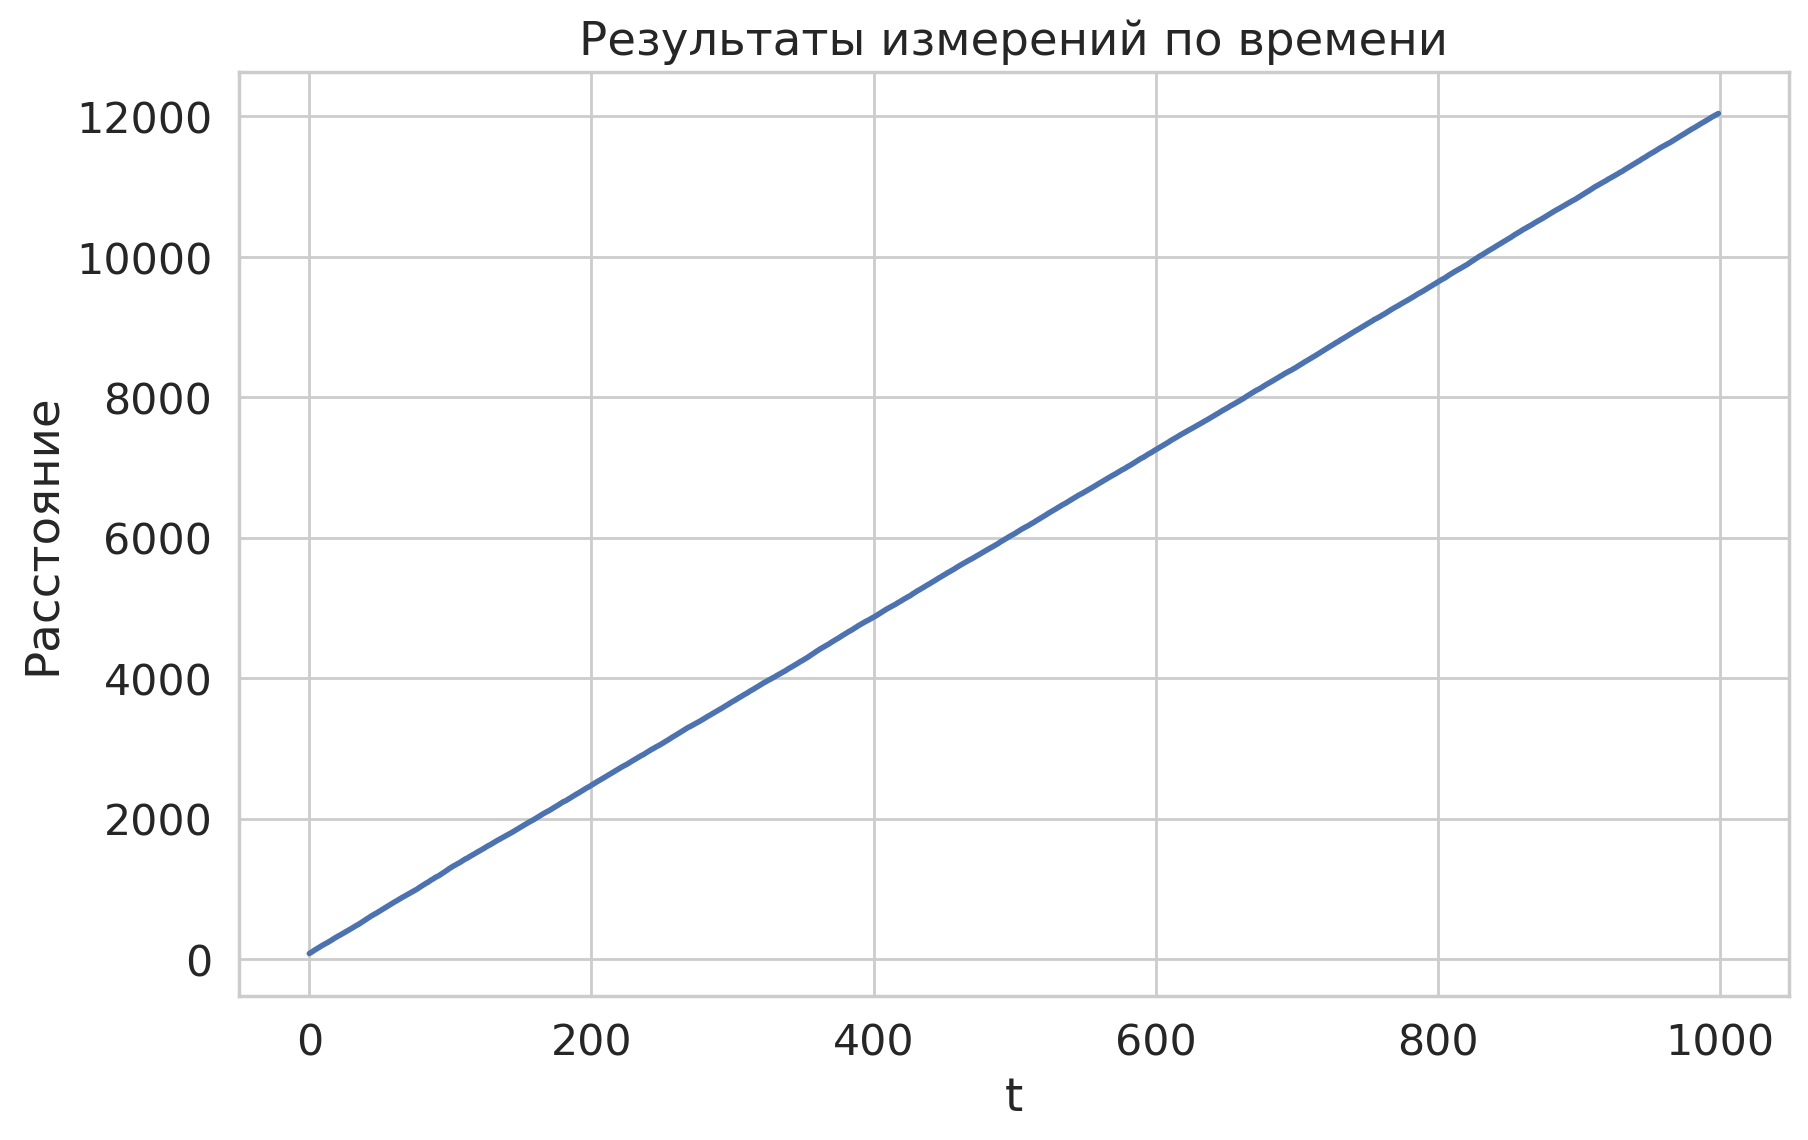

In [4]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(X.shape[0]), X, lw=2)
plt.xlabel("t"); plt.ylabel("Расстояние"); plt.title("Результаты измерений по времени")
plt.show()

<font color="#ae69c9ff">

Виден тренд на линейную зависимость, разумно предположить, что более сильная модель здесь скорее всего не потребуется; хватит обычной лин. регресии.

#### 1. Сведите задачу к гауссовской линейной модели

<font color="#ae69c9ff">

Пусть $Y = \begin{pmatrix} X_0 \\ X_1 - X_0 \\ \dots \\ X_n - X_{n-1} \end{pmatrix}$, тогда $Y = \begin{pmatrix} \beta_1 + \varepsilon_0^t * \beta_2 \\ \beta_2 + \varepsilon_1^t * \beta_2 \\ \dots \\ \beta_2 + \varepsilon_n^t * \beta_2 \end{pmatrix} = \begin{pmatrix} 1 \ 0 \\ 0 \ 1 \\ \dots \\ 0 \ 1 \end{pmatrix} \begin{pmatrix} \beta_1 \\ \beta_2 \end{pmatrix} + \varepsilon^t \beta_2$

Т.к. $\varepsilon_i^t * \beta_2$ - н.о.р.с.в. ~$N(0, \sigma^2 * \beta_2^2)$, то задача сведена к гаусс. лин. гер.. Смущает зависимость дисперсии от параметра, но, как будто бы, это здесь ничего не портит по причине того, что в известных мне теоремах не требовалась какая-то особая дисперсия, а так же параметр в исходном виде - константа, поэтому корректно им жанглировать

In [5]:
Y = X - np.r_[0, *X[:-1]]

#### 2. Найдите оценку параметров

Укажите, чему равна матрица (Z в терминах методички) в задаче:

И найдите параметры $\beta_1$, $\beta_2$

<font color="#ae69c9ff">

$Z = \begin{pmatrix} 1 \ 0 \\ 0 \ 1 \\ \dots \\ 0 \ 1 \end{pmatrix}$, см блок выше

Как мы знаем с курса статов, $\hat\theta = (Z^\top Z)^{-1}Z^\top Y$, $(Z^\top Z)^-1 = \begin{pmatrix} 1 & 0 \\ 0 & n-1 \end{pmatrix}^{-1} = \begin{pmatrix} 1 & 0 \\ 0 & \frac{1}{n-1} \end{pmatrix}$, т.е.: $\hat\theta = \begin{pmatrix} Y_0 \\ \frac{\sum_{i=1}^n Y_i}{n-1} \end{pmatrix}$ (посчитать - очев)

In [6]:
n = 1000
beta1, beta2 = Y[0], Y[1:].mean()
print(beta1, beta2)

82.0053 11.970782982982984


*Ошибкой* или *остатком* называют разность между наблюдаемым значением целевой величины и предсказанием модели на основе соответствующих признаков. Проверьте, насколько точна модель при помощи подсчёта ошибок. Выведите сами ошибки на график и проанализируйте его.

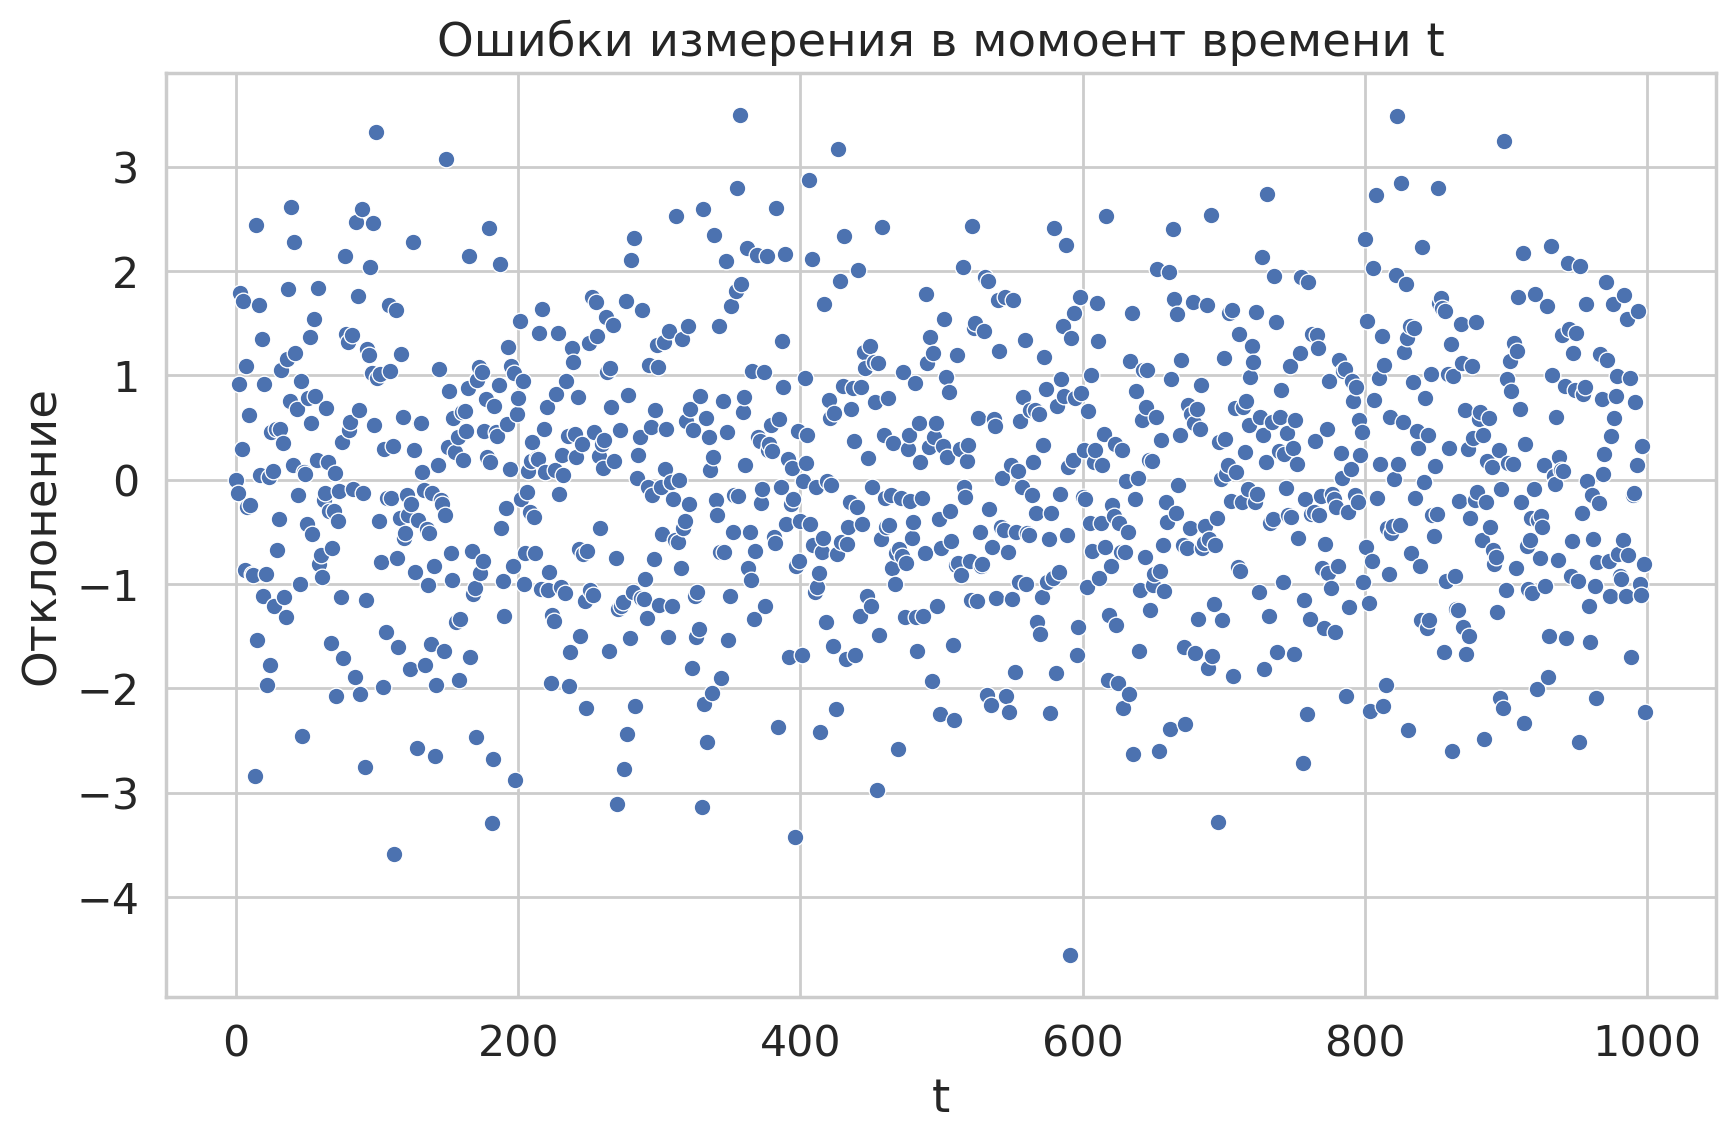

In [7]:
eps_hat = Y - np.r_[beta1, np.full(n - 1, beta2)]

plt.figure(figsize=(10,6))
sns.scatterplot(eps_hat)
plt.xlabel("t"); plt.ylabel("Отклонение"); plt.title("Ошибки измерения в момоент времени t")
plt.show()

<font color="#ae69c9ff">

Выглядит хорошо, ни неверной спецификации, ни гетероскедастичности не обнаружено

Проверьте, что ошибка нормальна. Для этого можно использовать QQ-plot. Если хотите, можете использовать критерии нормальности

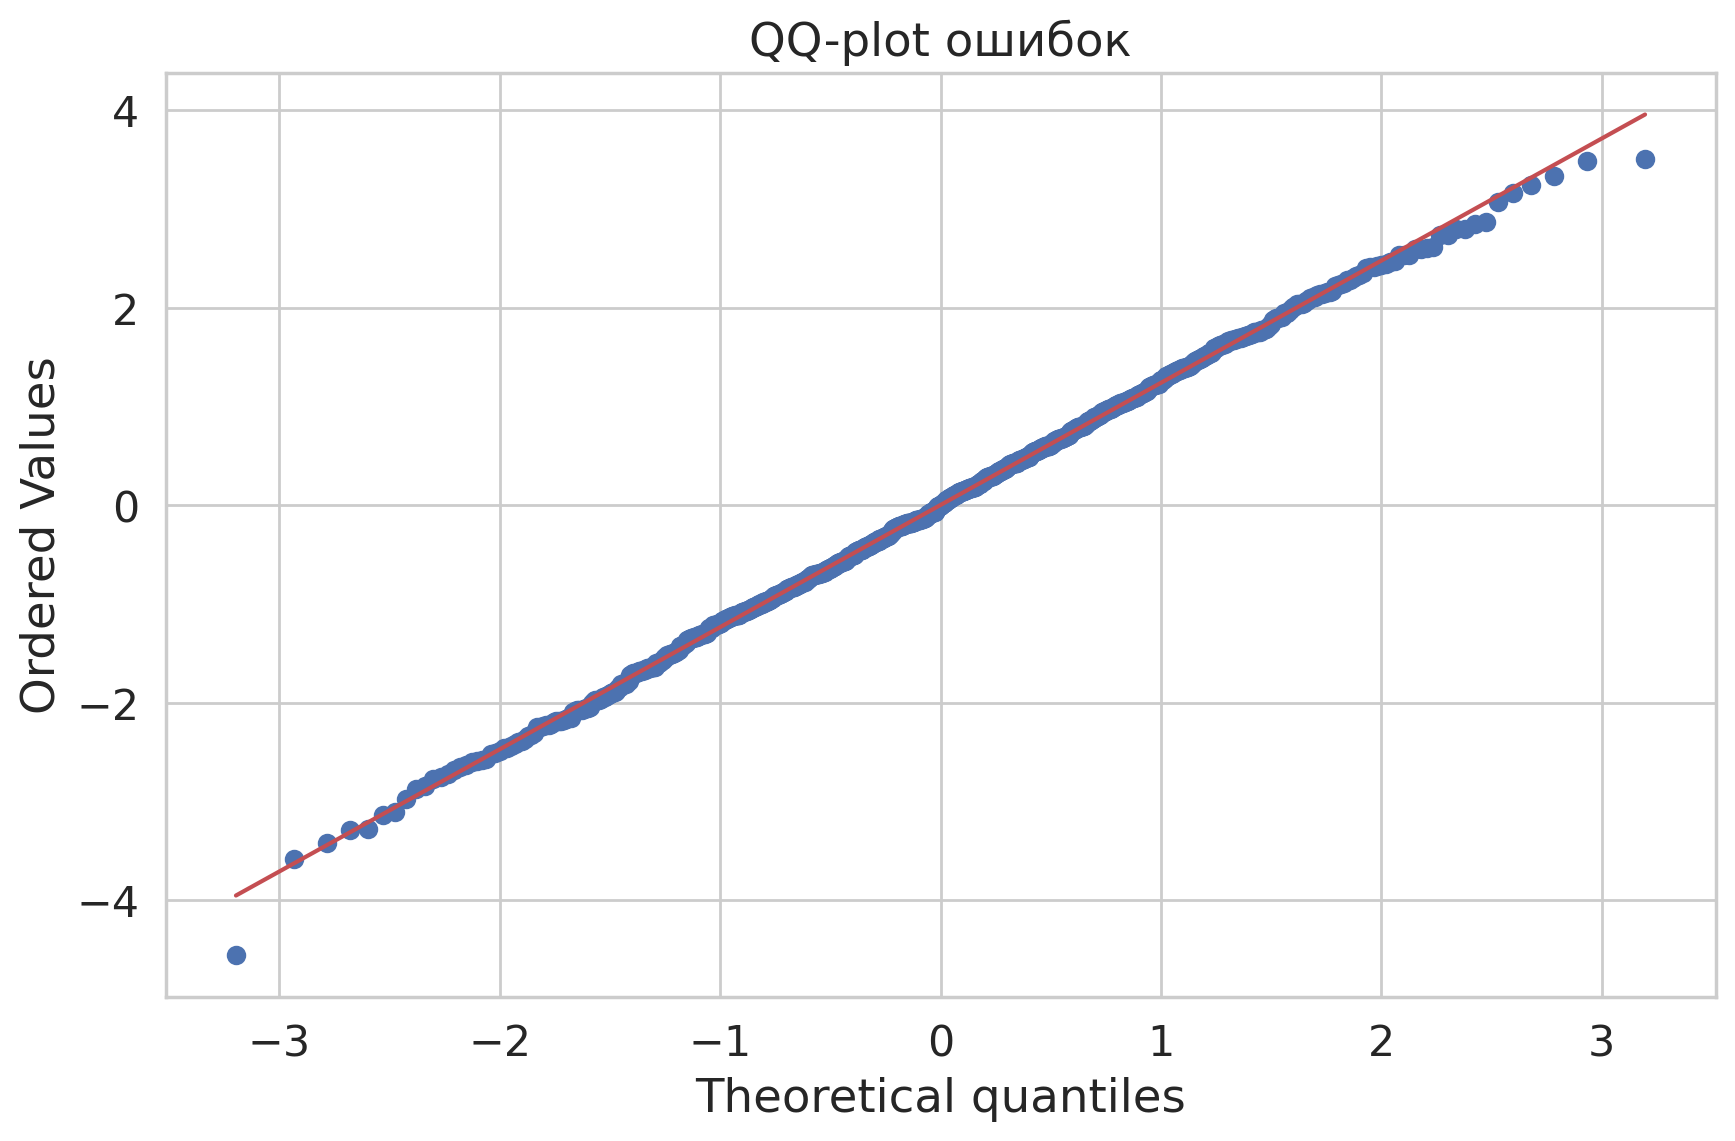

In [8]:
plt.figure(figsize=(10,6))
sps.probplot(eps_hat, dist="norm", plot=plt)
plt.title("QQ-plot ошибок")
plt.show()

In [9]:
ALPHA = 0.05

pvalue = sps.shapiro(eps_hat).pvalue
print("По мнению критерия Шапиро-Уилка нормальность распределения ошибок", "отвергается" if pvalue < ALPHA else "не отвергается")

По мнению критерия Шапиро-Уилка нормальность распределения ошибок не отвергается


<font color="#ae69c9ff">

В принципе, полностью быть уверенным в нормальности распределения быть нельзя, но оно скорее нормально, чем нет

Бонусная часть про робастность (+5 баллов):

Возможно измерения в задаче содержат разные аномалии, что плохо скажется на оценке наименьших квадратов. Попробуйте применить знания из второго практического задания о робастных оценках и построить оценку с BP выше нуля разными методами. Такие методы называются "робастной регрессией", но определение M-оценки в них то же, что и в обычной робастной статистике.

<font color="#ae69c9ff">

В этой задаче можно взять оценку медианой (распредлеение обещает быть симметричным).

На основании второго прака + семинаров, мы знаем, что такие оценки, как медиана, усечённое среднее и оценка через функцию влияния Хьюберта - робастные, заменим ими среднее при подсчёте $\beta_2$.

Корректность / фан-факт (я просто +- долго думал над корректностью): $\beta_1$ и $\beta_2$ независимы, первое не оценивается робастно, а второе вот да. Поэтому будет корректно оценить только $\beta_2$

In [10]:
print(r"Исходная оценка $\beta_2$:", beta2) # Print терпит, за юникодовские символы нынче баниить принято

beta2_med = np.median(Y[1:])
print(r"Робастная оценка $\beta_2 через медиану$:", beta2_med)


beta2_trunc_mean = np.sort(Y[1:])[int((n-1)*0.25):int(-(n-1)*0.25)].mean()
print(r"Робастная оценка $\beta_2 через усечённое среднее$:", beta2_trunc_mean)


def psi_huber(X, c): return np.clip(X, -c, c)

def gd(theta, X, psi, c, lr=0.1, it=500, prec=1e-8): # ура, Apple изробрели копипаст в 1981.  
    th = theta
    for _ in range(it):
        g = -np.mean(psi(X - th, c))
        th -= lr * g
        if abs(g) < prec: break
    return th

theta = np.median(Y[1:])
beta2_huber = gd(theta, Y[1:], psi_huber,  15)
print(r"Робастная оценка $\beta_2 через функцию Хьюберта$:", beta2_huber)

Исходная оценка $\beta_2$: 11.970782982982984
Робастная оценка $\beta_2 через медиану$: 11.96329999999989
Робастная оценка $\beta_2 через усечённое среднее$: 11.968954890219576
Робастная оценка $\beta_2 через функцию Хьюберта$: 11.970782974557379


<font color="#ae69c9ff">

Оценки имеют BP явно больше 0, почему? - см. второй прак + лекцию по соотв. теме

Явного отличия от полученной ранее оценки я не наблюдаю. Хочется предположить, что данные не имеют "критической массы" (я не знаю, как это описать иначе) выбросов

#### 3. Оцените дисперсию ошибки отсчёта времени $\varepsilon_i^t$.

Найдите *несмещённую* оценку дисперсии ошибки приращения расстояния $\varepsilon_i$. По ней найдите оценку дисперсии ошибки отсчёта времени $\varepsilon_i^t$.

<font color="#ae69c9ff">

Либо я что-то не понимаю, либо здесь меня просят посчитать оценку $\frac{1}{n-1} \sum_{i=1}^n (Y_i - a_i)^2$, где $a_i$ - значение на $i$-й строке метрицы $\begin{pmatrix} 1 \ 0 \\ 0 \ 1 \\ \dots \\ 0 \ 1 \end{pmatrix} \cdot \begin{pmatrix} \hat\beta_1 \\ \hat\beta_2 \end{pmatrix}$. Вроде как классическая оценка...

Короче, думаю, что разобрался. Идея: исходно $\beta_2$ - параметр, т.е. константа, а после полученная его оценка - уже с.в.. При вычислении дисперсии ошибки приращения расстояния $\varepsilon_i$ на параметр можно забить, а уже после, при подсчёте дисперсии ошибки отсчёта времени $\varepsilon_i^t$, мы живём в мире, где выборка фиксирована и параметр подменяется численн посчитанной его оценкой. На основании какой теормеы? - наверняка я не уверен, но как будто бы ЗБЧ + несмещённость и состоятельность оценки + лемма Слуцкого. Есть ощущение, что получить несмещённую оценку $\varepsilon_i^t$ в нашем случае нальзя.

In [11]:
Z = np.r_[[[1, 0]], np.full((n - 1, 2), (0, 1))]
sigma2 = lambda theta: np.sum((Y - Z @ theta) ** 2) / (n - 1)

sigma2_eps_dif = [sigma2((beta1, theta_2)) for theta_2 in [beta2, beta2_med, beta2_trunc_mean, beta2_huber]] # А мы их че, зря считали?
sigma2_eps_t_dif = [sigma2_eps_dif[i] / [beta2, beta2_med, beta2_trunc_mean, beta2_huber][i] ** 2 for i in range(4)]


print(r"Исходная несмещённая оценка дисперсии $\varepsilon_i$:", sigma2_eps_dif[0]) # print всё ещё терпит, юникода не будет.
print(r"Робастная оценка дисперсии $\varepsilon_i$ по медиане:", sigma2_eps_dif[1])
print(r"Робастная оценка дисперсии $\varepsilon_i$ по усечённому среднему:", sigma2_eps_dif[2])
print(r"Робастная оценка дисперсии $\varepsilon_i$ по функции Хьюбера:", sigma2_eps_dif[3])

print()

print(r"Исходная оценка дисперсии $\varepsilon_i^t$:", sigma2_eps_t_dif[0])
print(r"Робастная оценка дисперсии времени $\varepsilon_i^t$ по медиане:", sigma2_eps_t_dif[1])
print(r"Робастная оценка дисперсии $\varepsilon_i^t$ по усечённому среднему:", sigma2_eps_t_dif[2])
print(r"Робастная оценка дисперсии $\varepsilon_i^t$ по функции Хьюбера:", sigma2_eps_t_dif[3])

Исходная несмещённая оценка дисперсии $\varepsilon_i$: 1.5237180999706548
Робастная оценка дисперсии $\varepsilon_i$ по медиане: 1.52377409500498
Робастная оценка дисперсии $\varepsilon_i$ по усечённому среднему: 1.5237214418938063
Робастная оценка дисперсии $\varepsilon_i$ по функции Хьюбера: 1.5237180999706548

Исходная оценка дисперсии $\varepsilon_i^t$: 0.010633090525597827
Робастная оценка дисперсии времени $\varepsilon_i^t$ по медиане: 0.010646787817099069
Робастная оценка дисперсии $\varepsilon_i^t$ по усечённому среднему: 0.010636362217815415
Робастная оценка дисперсии $\varepsilon_i^t$ по функции Хьюбера: 0.010633090540565977


<font color="#ae69c9ff">

Уже здесь достаточно хорошо видно, что робастность вообще не улучшила результат.

#### 4. Измерьте качество модели (способы измерения можно подчерпнуть из лекций)

<font color="#ae69c9ff">

Хочется посчитать $R^2$ и $MSE$, но первое здесь в принципе бесполезно (мы оцениваем $\beta_2$ средним, а $\beta_1$ одним измерением. Если взять $R^2$ для второго параметра - получим 0. В общем же случае получим что-то не репрезентативное), а $MSE$ мы уже посчитали: получили $1.5237\dots$ - это дисперсия шума. Ну, посчитаем ещё $MAPE$ явно

In [12]:
mape = lambda theta: np.sum(np.abs(Y - Z @ theta) / Y) / 1000
mape_dif = [mape((beta1, theta_2)) for theta_2 in [beta2, beta2_med, beta2_trunc_mean, beta2_huber]]

print(r"MAPE для исходной оценки $\beta_2$:", mape_dif[0])
print(r"MAPE для робастной оценки $\beta_2 по медиане:", mape_dif[1])
print(r"MAPE для робастной оценки $\beta_2 по усечённому среднему:", mape_dif[2])
print(r"MAPE для робастной оценки $\beta_2 по функции Хьюбера:", mape_dif[3])

MAPE для исходной оценки $\beta_2$: 0.08464235493493441
MAPE для робастной оценки $\beta_2 по медиане: 0.08458881956590122
MAPE для робастной оценки $\beta_2 по усечённому среднему: 0.08462927624413197
MAPE для робастной оценки $\beta_2 по функции Хьюбера: 0.08464235487465525


**Вывод:**

<font color="#ae69c9ff">

- Робастность в данной задаче не актуальна по причине очень хороших исходных данных
- Линейная модель прекрасно описала поставленную задачу, получили mape всего 8% во всех случаях, что есть достаточно хороший результат

## Задача 2. Непараметрическая регрессия и метод Надарая-Ватсона

*Данная задача стоит 5 баллов.*

Иногда вытаскивать информативные признаки из данных сложно, а регрессию делать хочется. Тогда можно построить нечто похожее на ядерную оценку плотности, но для регрессионной задачи. Она основана на вычислении значения в новой точке по значениям в соседних точках (похожее Вы видели на курсе машинного обучения, но для классификации и без статистики).

Перед выполнением изучите формулу Надарая-Ватсона из лекции или статьи на Википедии: https://en.wikipedia.org/wiki/Kernel_regression

1) Сгенерируйте выборку для линейной регрессии руками (использовать реальные данные может быть нецелесообразно из-за проблем с визуализацией результата и проклятия размерностей).

Пусть в модели будет одна фича $x$ и по ней вычисляется отклик $y = ax + b + \varepsilon$, где ошибки $\varepsilon$ независимы и нормальны, а параметры $a$ и $b$ выберите сами.

In [13]:
N = 1600
seed = 42

X = sps.uniform(0, 4).rvs(N, random_state=seed)
Y = 5 * X + 7 + sps.norm(0, 4).rvs(N, random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

<font color="#ae69c9ff">

В какой-то момент у нас возникнет естественно ежелание подобрать гиперпараметр но основе качества модели и дисперсии в системе. Сделаем это на валидационной выборке

Сгенерируйте тестовую выборку тем же способом и посчитайте отклик из формулы Надарая-Ватсона для хотя бы трёх разных ядер (примеры ядер: https://en.wikipedia.org/wiki/Kernel_(statistics)). Сравните ошибки.

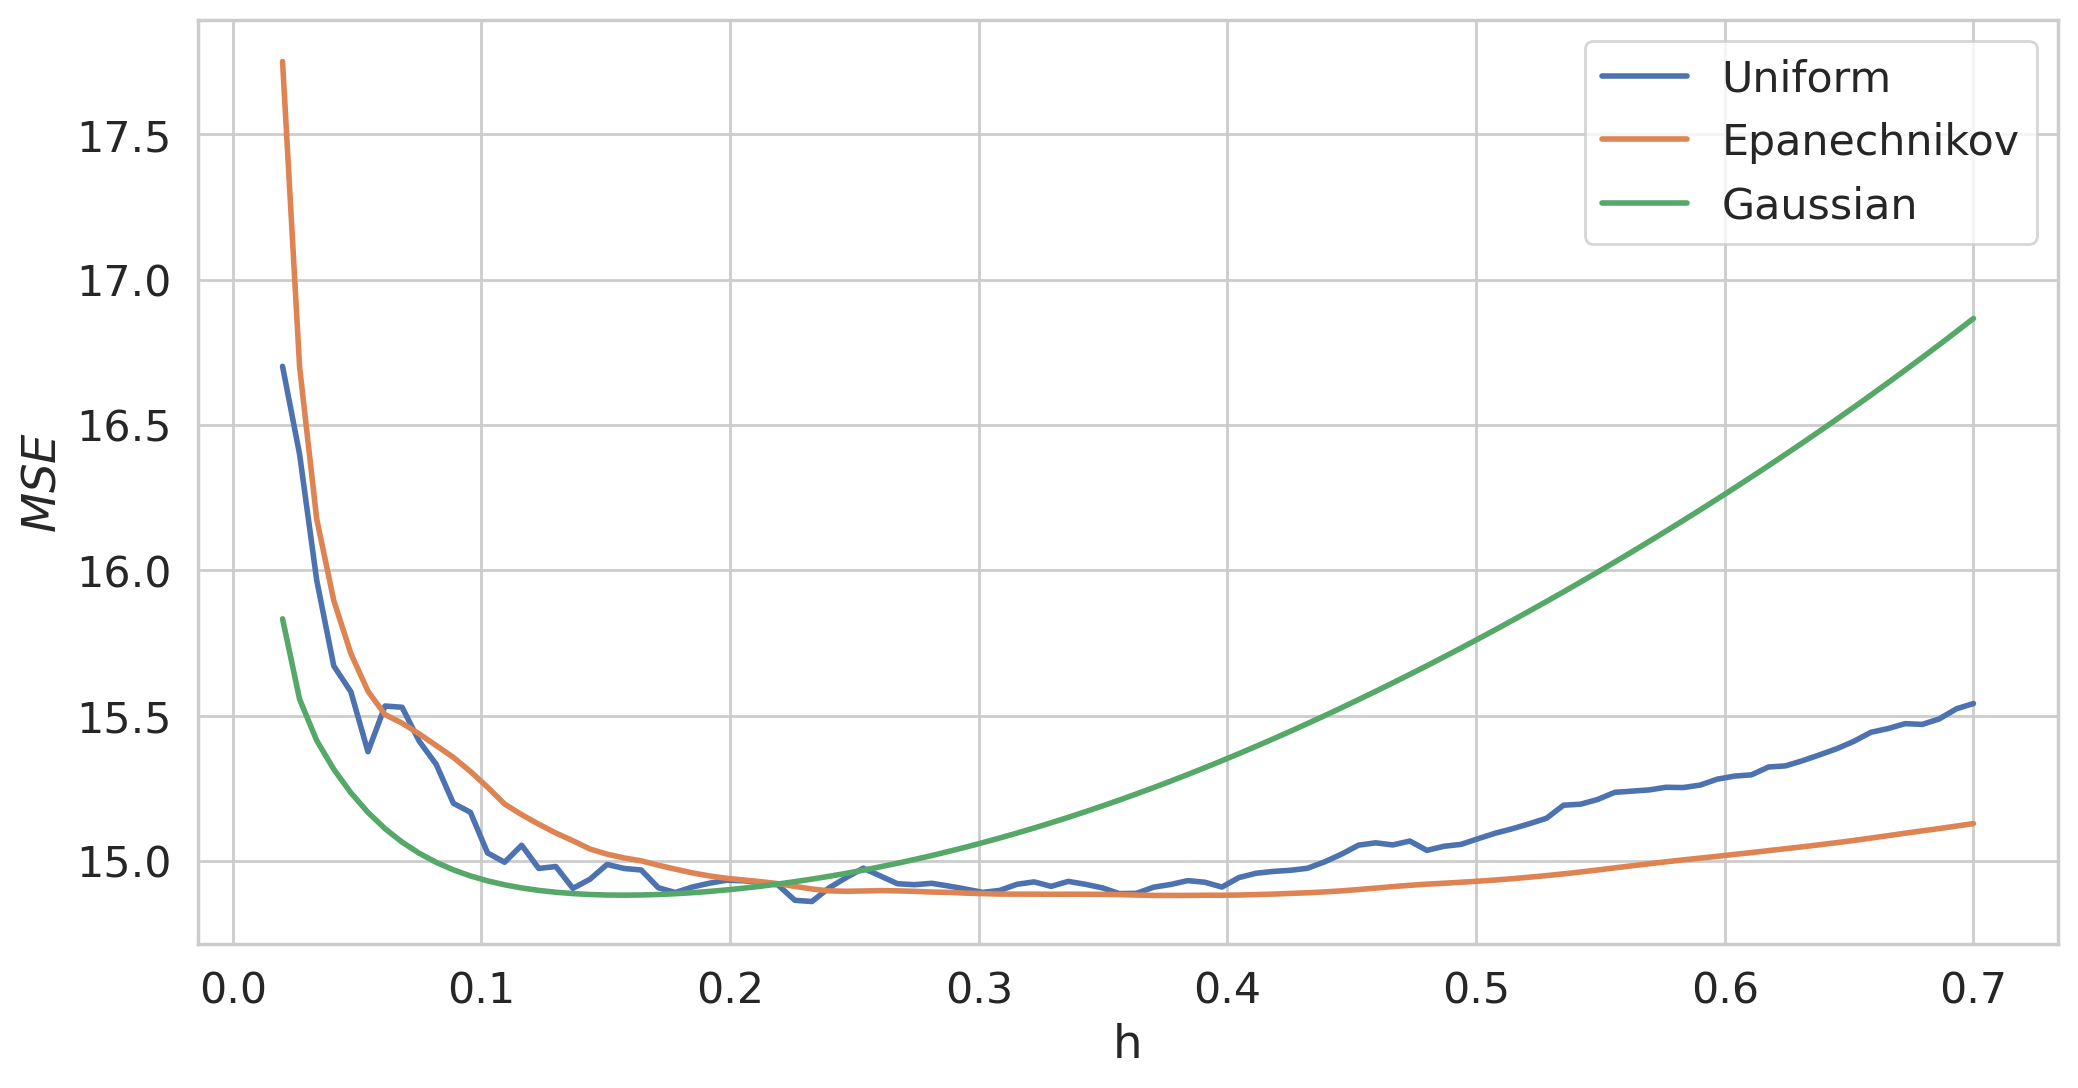

In [14]:
mse = lambda K, X, Y, h: np.mean( (Y - (lambda A: (A @ Y_train) / A.sum(axis=1))    (K((X[:, None] - X_train[None, :]) / h))) ** 2 )
# ЙОУ!!! Мечта детства номер 6 (писать ООООЧ большие формулы) - исполнена

K_uni = lambda u: 0.5 * (np.abs(u) <= 1)
K_epa = lambda u: 3 / 4 * (1.0 - u ** 2) * (np.abs(u) <= 1)
K_gaus = lambda u: (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

Kernels = [K_uni, K_epa, K_gaus]
lables = ["Uniform", "Epanechnikov", "Gaussian"]

h_grid = np.linspace(0.02, 0.7, 100) # ну вот это векторизовывать за бесплатно по баллам вайба не нахожу

plt.figure(figsize=(12,6))
[plt.plot(h_grid, [mse(Kernels[j], X_val, Y_val, h) for h in h_grid], lw=2, label=lables[j]) for j in range(3)]
plt.xlabel("h"); plt.ylabel(r"$MSE$"); plt.legend(loc="best")
plt.show()

In [15]:
h = 0.22
[print("MSE для", lables[j], "ядровой функции", mse(Kernels[j], X_test, Y_test, h)) for j in range(3)]

MSE для Uniform ядровой функции 16.05270078501595
MSE для Epanechnikov ядровой функции 16.08428070179074
MSE для Gaussian ядровой функции 15.991555010835539


[None, None, None]

<font color="#ae69c9ff">

При различных $N$ (рассматривались значения $1600-16000$) получаются существенно различные результаты оптимального $h$. Я связываю это с тем, что оценка через Нерыдая-Ватсона (извините) получается с высокой дисперсией (да наши исходные данные не могут похвастаться низкой дисперсией ошибок), т.о. единственный путь из пока известных мне к детерминизму $h$ в этой модели - существенное увеличение выборки

Визуализируйте Ваши предсказания (постройте кривую предсказаний по сетке x с шагом 0.01)

/tmp/ipykernel_2083725/2231640526.py:4: RuntimeWarning: invalid value encountered in divide
  model = lambda K, h, X: (lambda A: (A @ Y_train) / A.sum(axis=1))   (K((X[:, None] - X_train[None, :]) / h))


<Figure size 1200x1800 with 0 Axes>

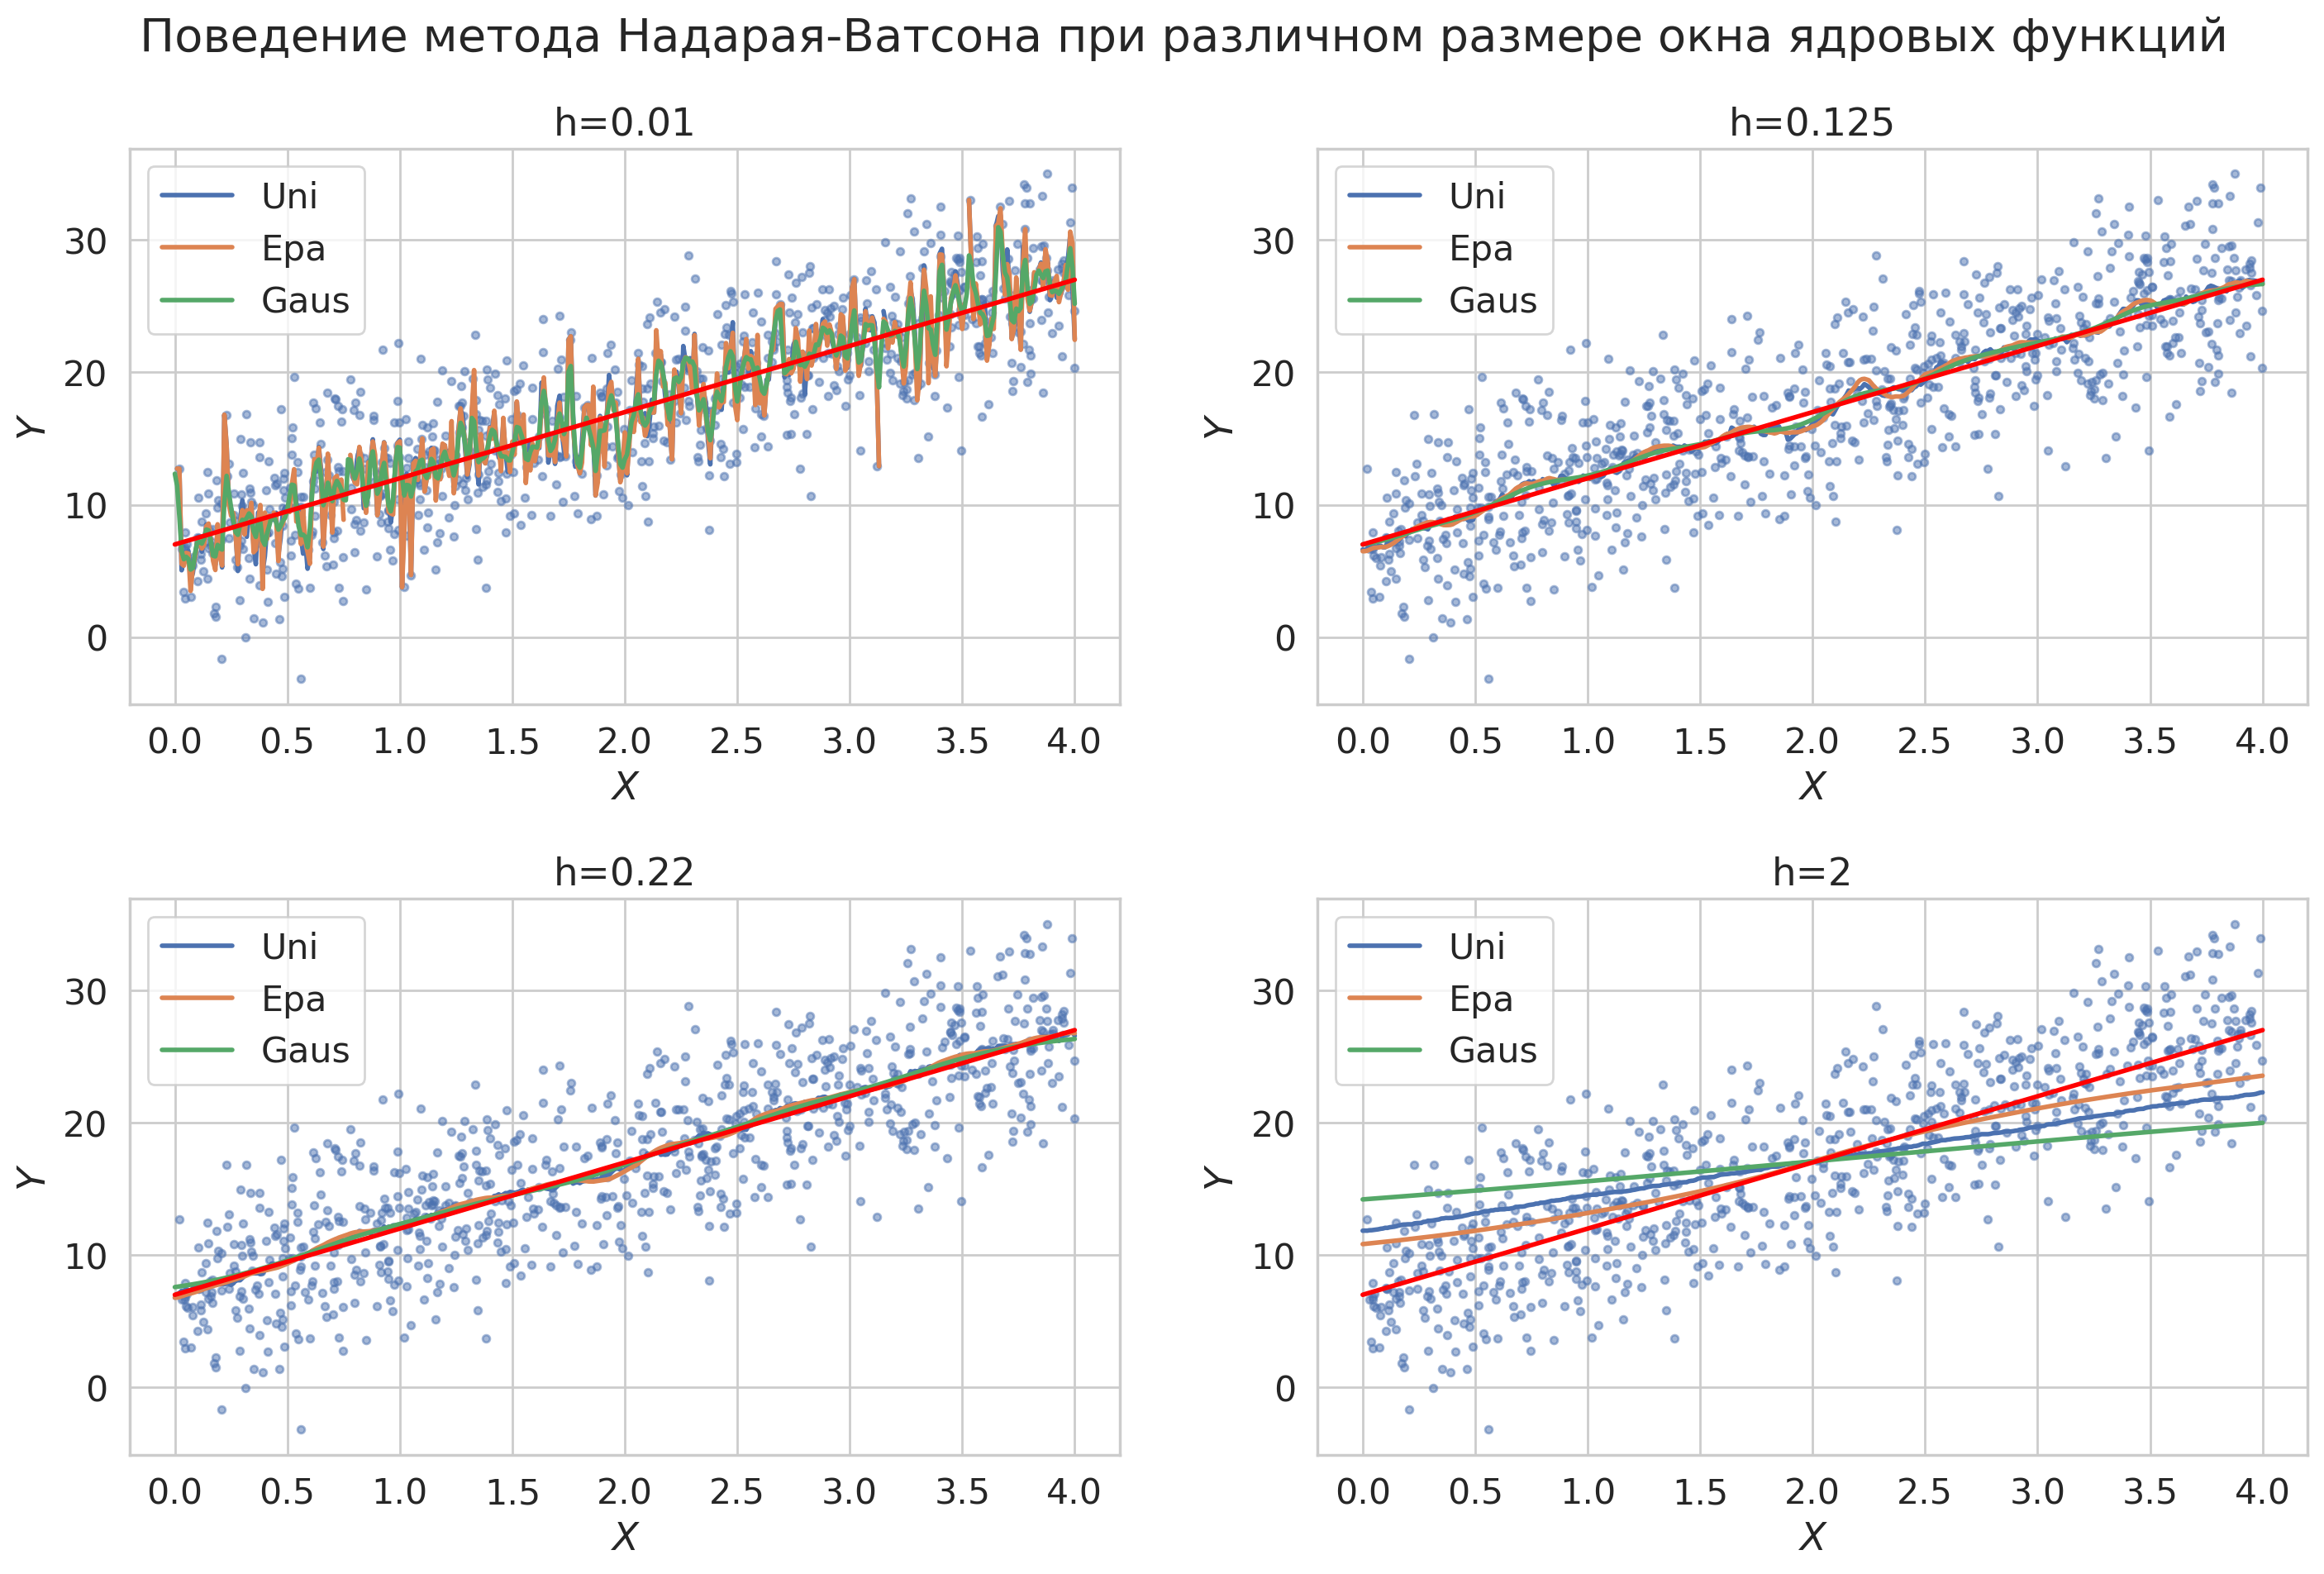

In [16]:
x_grid = np.linspace(0, 4, 401)
h_grid = [0.01, 0.125, 0.22, 2]

model = lambda K, h, X: (lambda A: (A @ Y_train) / A.sum(axis=1))   (K((X[:, None] - X_train[None, :]) / h))

plt.figure(figsize=(12,18))
fig, axes_raw = plt.subplots(2, 2, figsize=(17, 10))
fig.subplots_adjust(hspace=0.35, top=0.9)
axes = axes_raw.ravel()
fig.suptitle("Поведение метода Надарая-Ватсона при различном размере окна ядровых функций")
lables = ["Uni", "Epa", "Gaus"]

for i in range(4):
    axes[i].scatter(X_train, Y_train, s=10, alpha=0.5) # Пожертвуем названием ради читаемости графика
    [axes[i].plot(x_grid, model(Kernels[j], h_grid[i], x_grid), label=lables[j], lw=2) for j in range(3)]
    axes[i].plot(x_grid, 5 * x_grid + 7, lw=2, c="red")
    axes[i].set_xlabel(r"$X$"); axes[i].set_ylabel(r"$Y$"); axes[i].set_title(r"h=" + str(h_grid[i])); axes[i].legend(loc="best")
plt.show()

<font color="#ae69c9ff">

На машинке Нейчев рассказывал про bias–variance trade-off и вот, собственно, оно наглядно. При малом $h$ получается переобучение, при большом - модель слишком проста и очень плохо обратывает хвосты.

Очевидно, разные ядра дают разный результат, но здесь пока чего-то супер интересного я не вижу, ибо сама функция простая

Ну и да, яркая красная линия на графике - целевая функция. Она не помещалась в легенду с сохранением читаемости

Заметим, что мы нигде не оценивали сами параметры, но смогли решить финальную задачу -- предсказывать $y$ по $x$.

А теперь поймём, что для этого не нужна линейность.

Проделайте рассуждения выше для нелинейных зависимостей (например, $y = sin(kx) + \varepsilon, y = log(x) + \varepsilon, y = x^k + \varepsilon$ и т.д.). Постройте графики предсказаний и сравните их с истинными функциями.

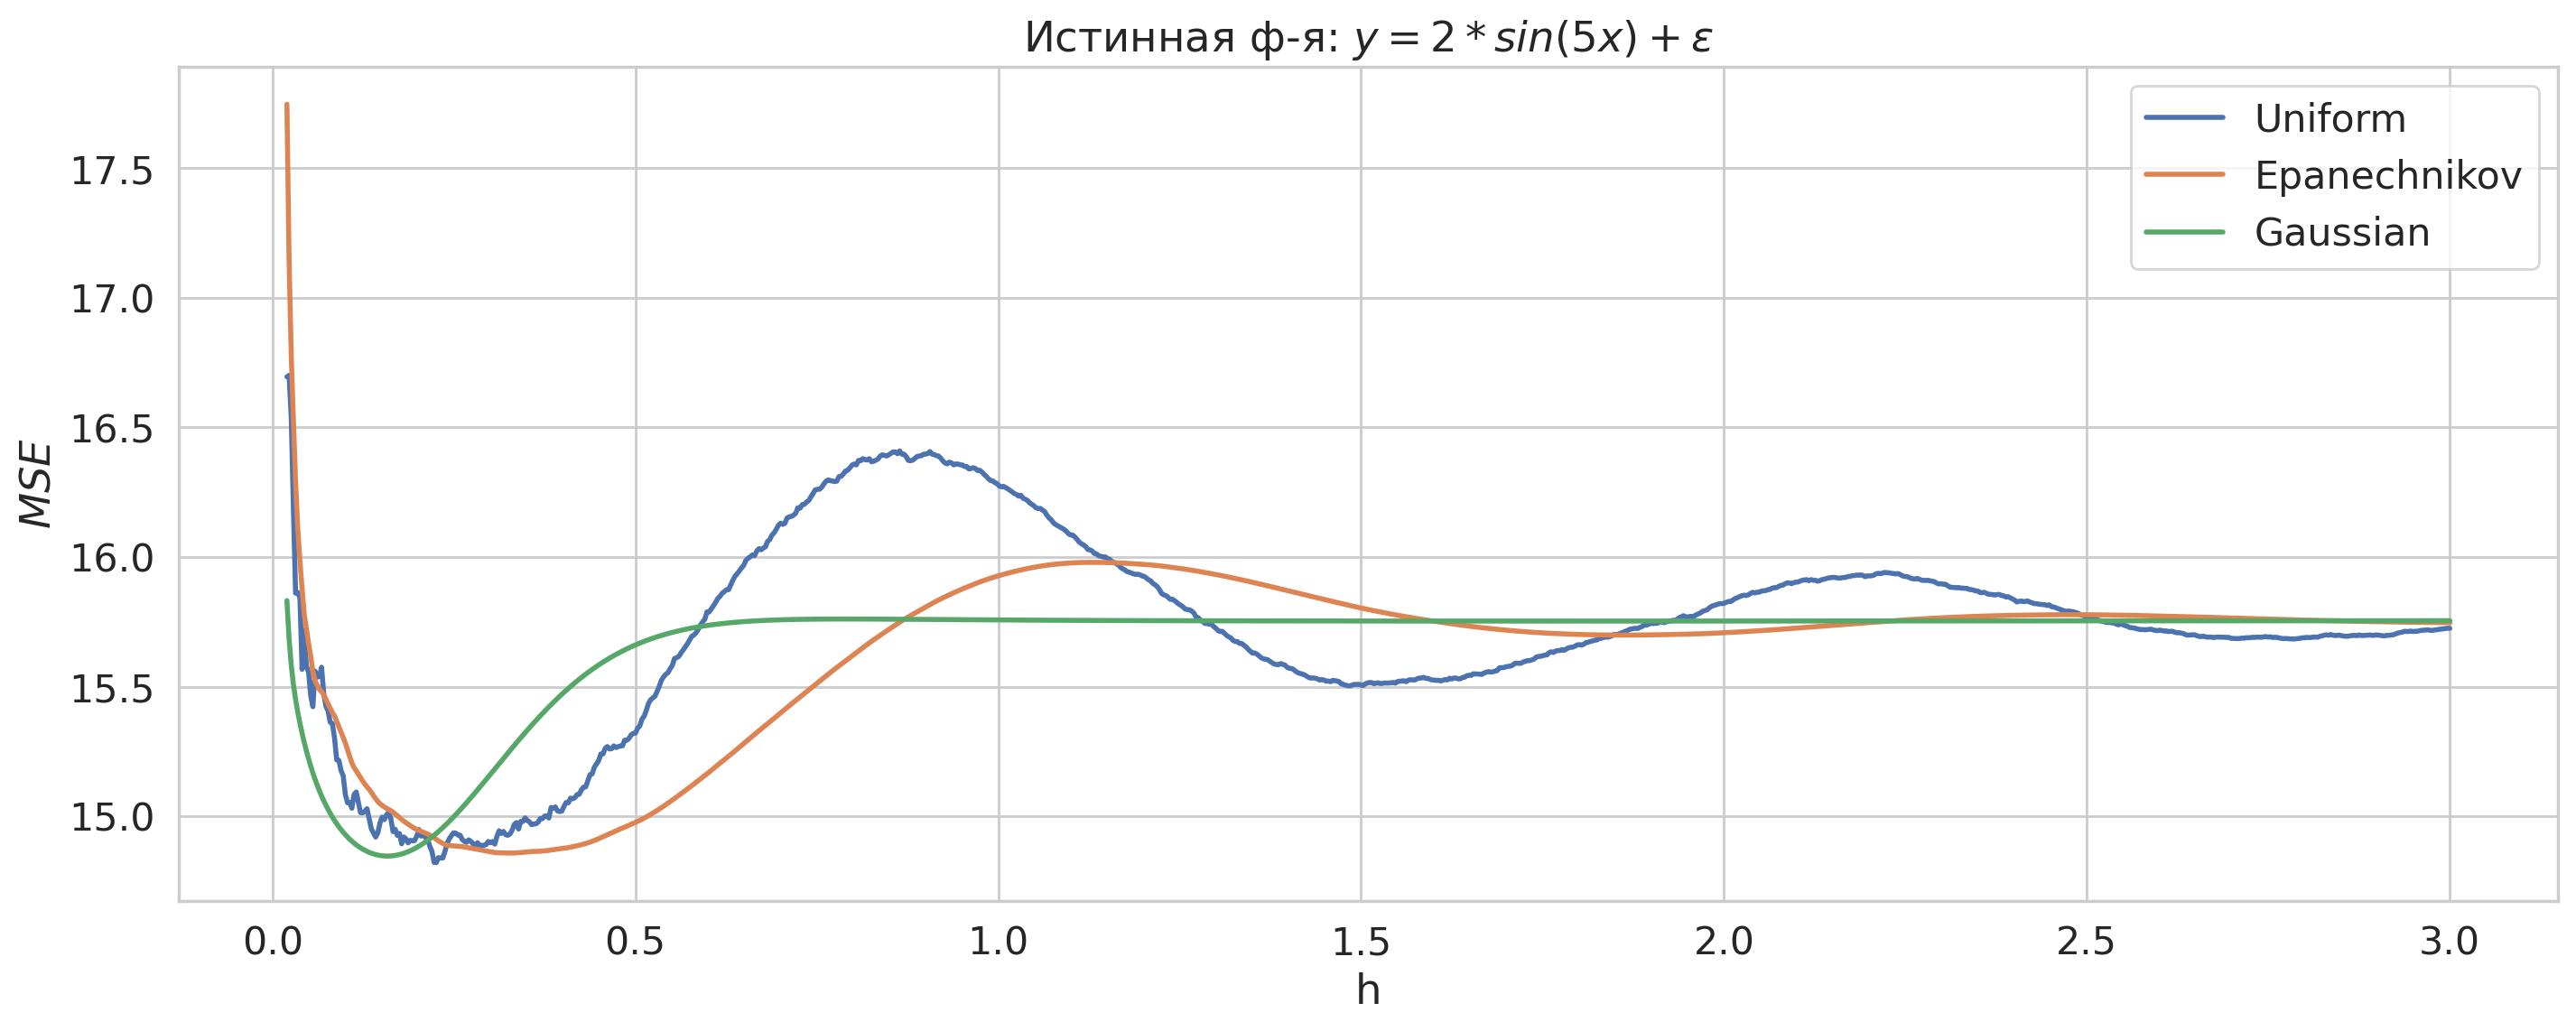

/tmp/ipykernel_2083725/2440401931.py:18: RuntimeWarning: invalid value encountered in divide
  model = lambda K, h, X: (lambda A: (A @ Y_train) / A.sum(axis=1))   (K((X[:, None] - X_train[None, :]) / h))


<Figure size 1200x1800 with 0 Axes>

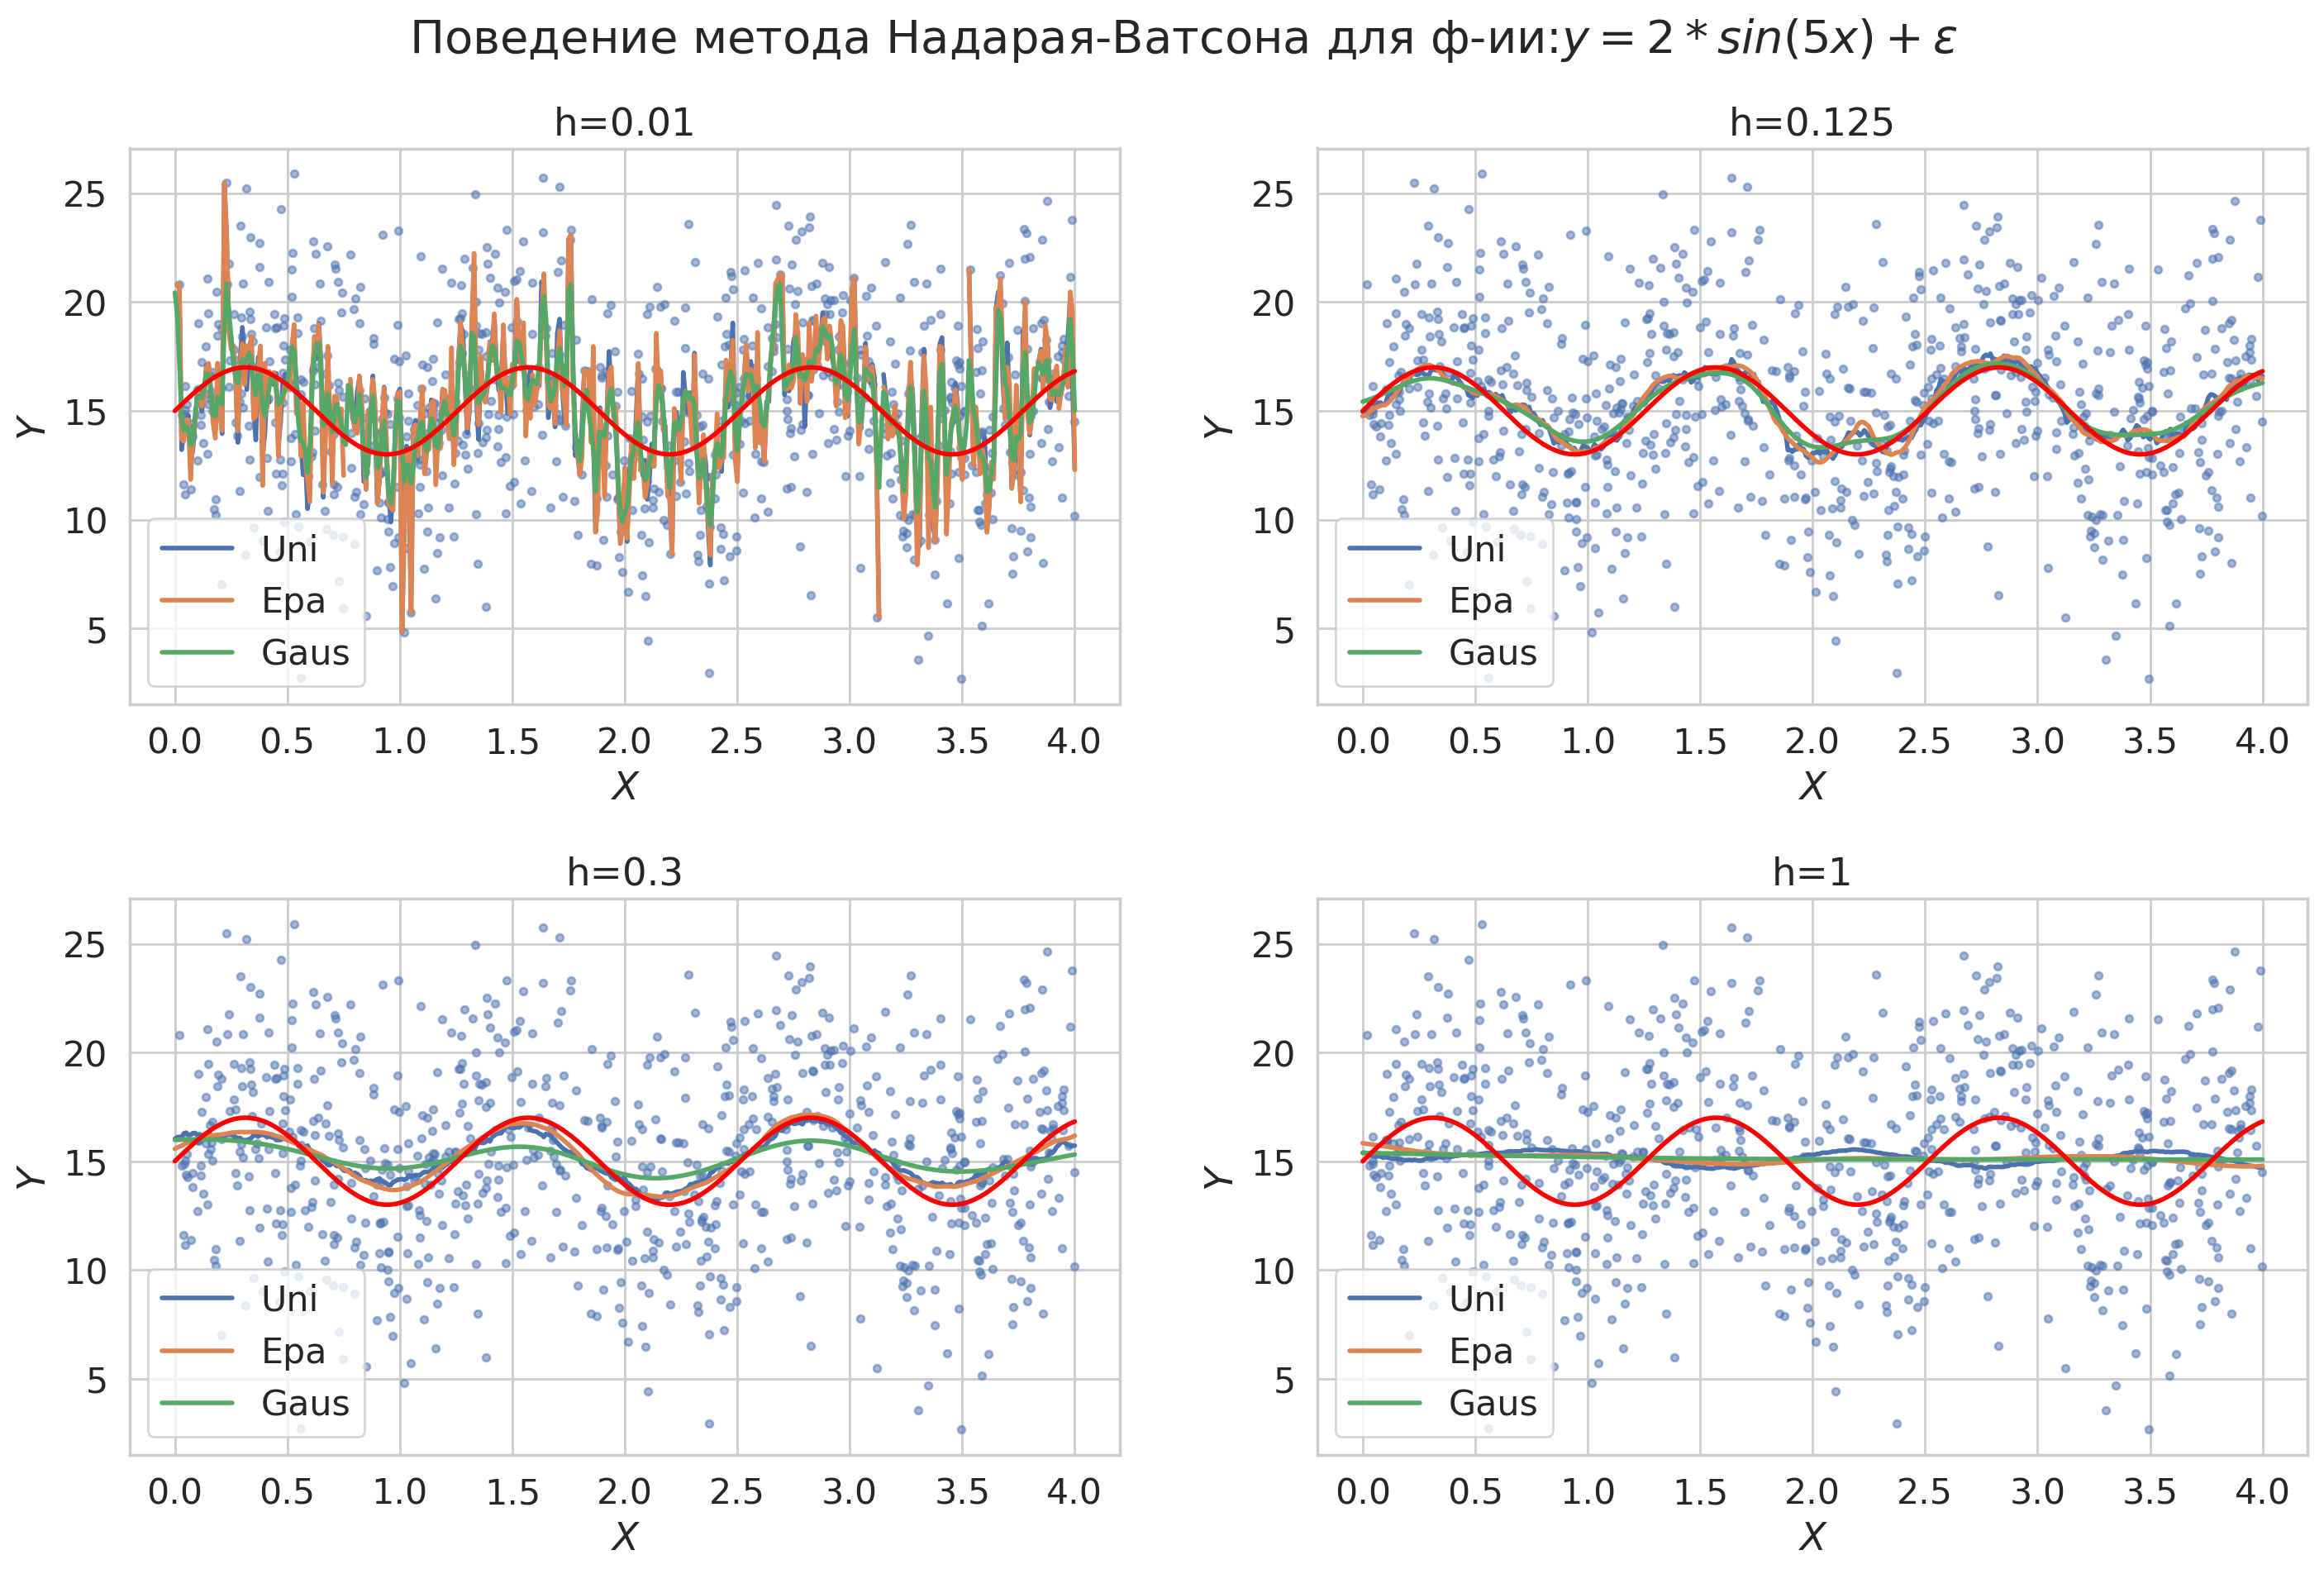

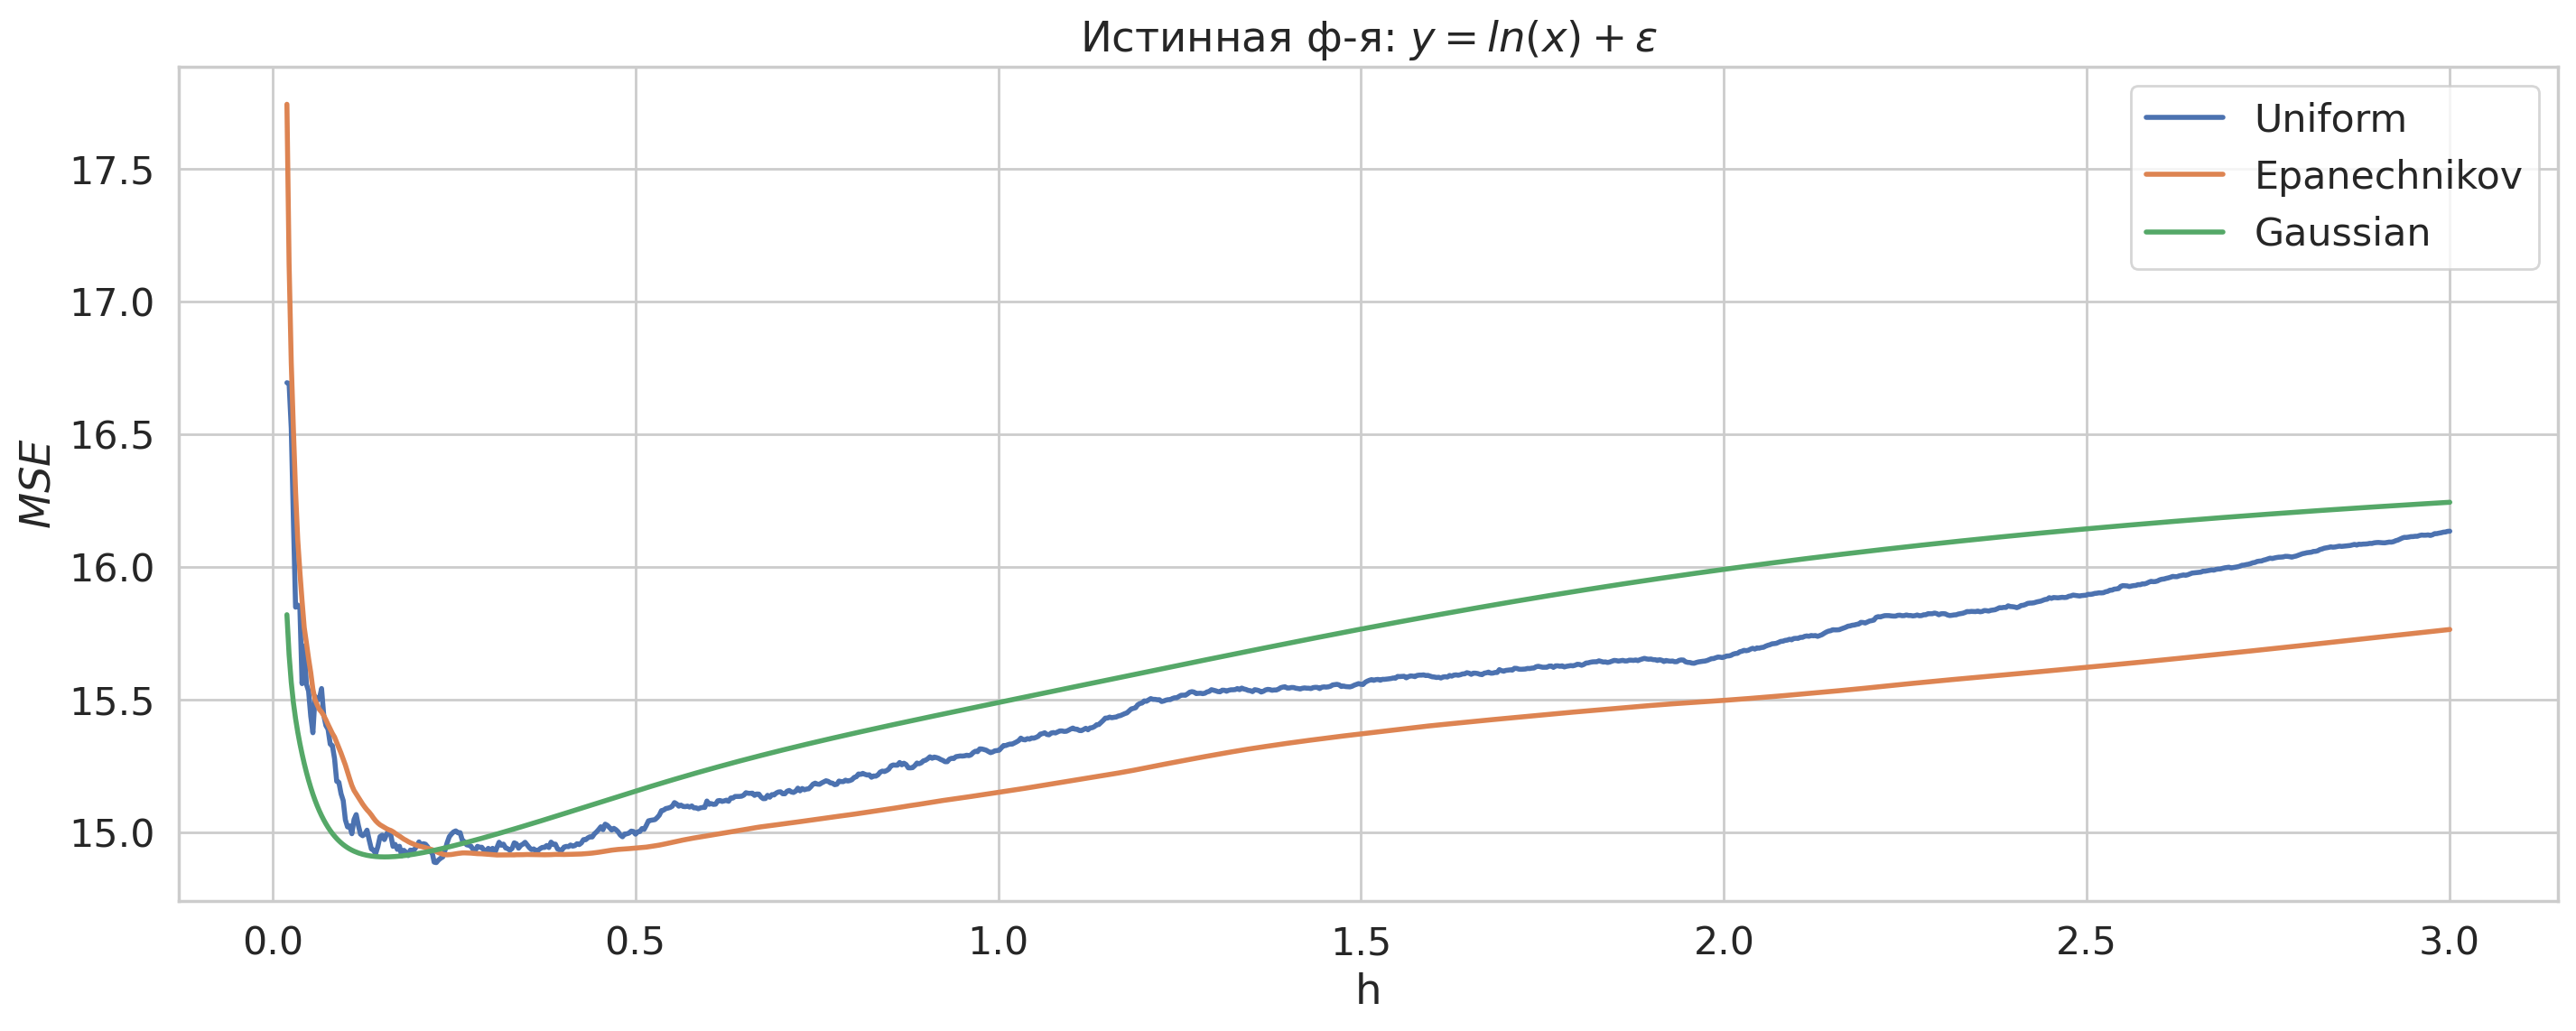

/tmp/ipykernel_2083725/2440401931.py:36: RuntimeWarning: divide by zero encountered in log
  f2 = lambda X: np.log(X)


<Figure size 1200x1800 with 0 Axes>

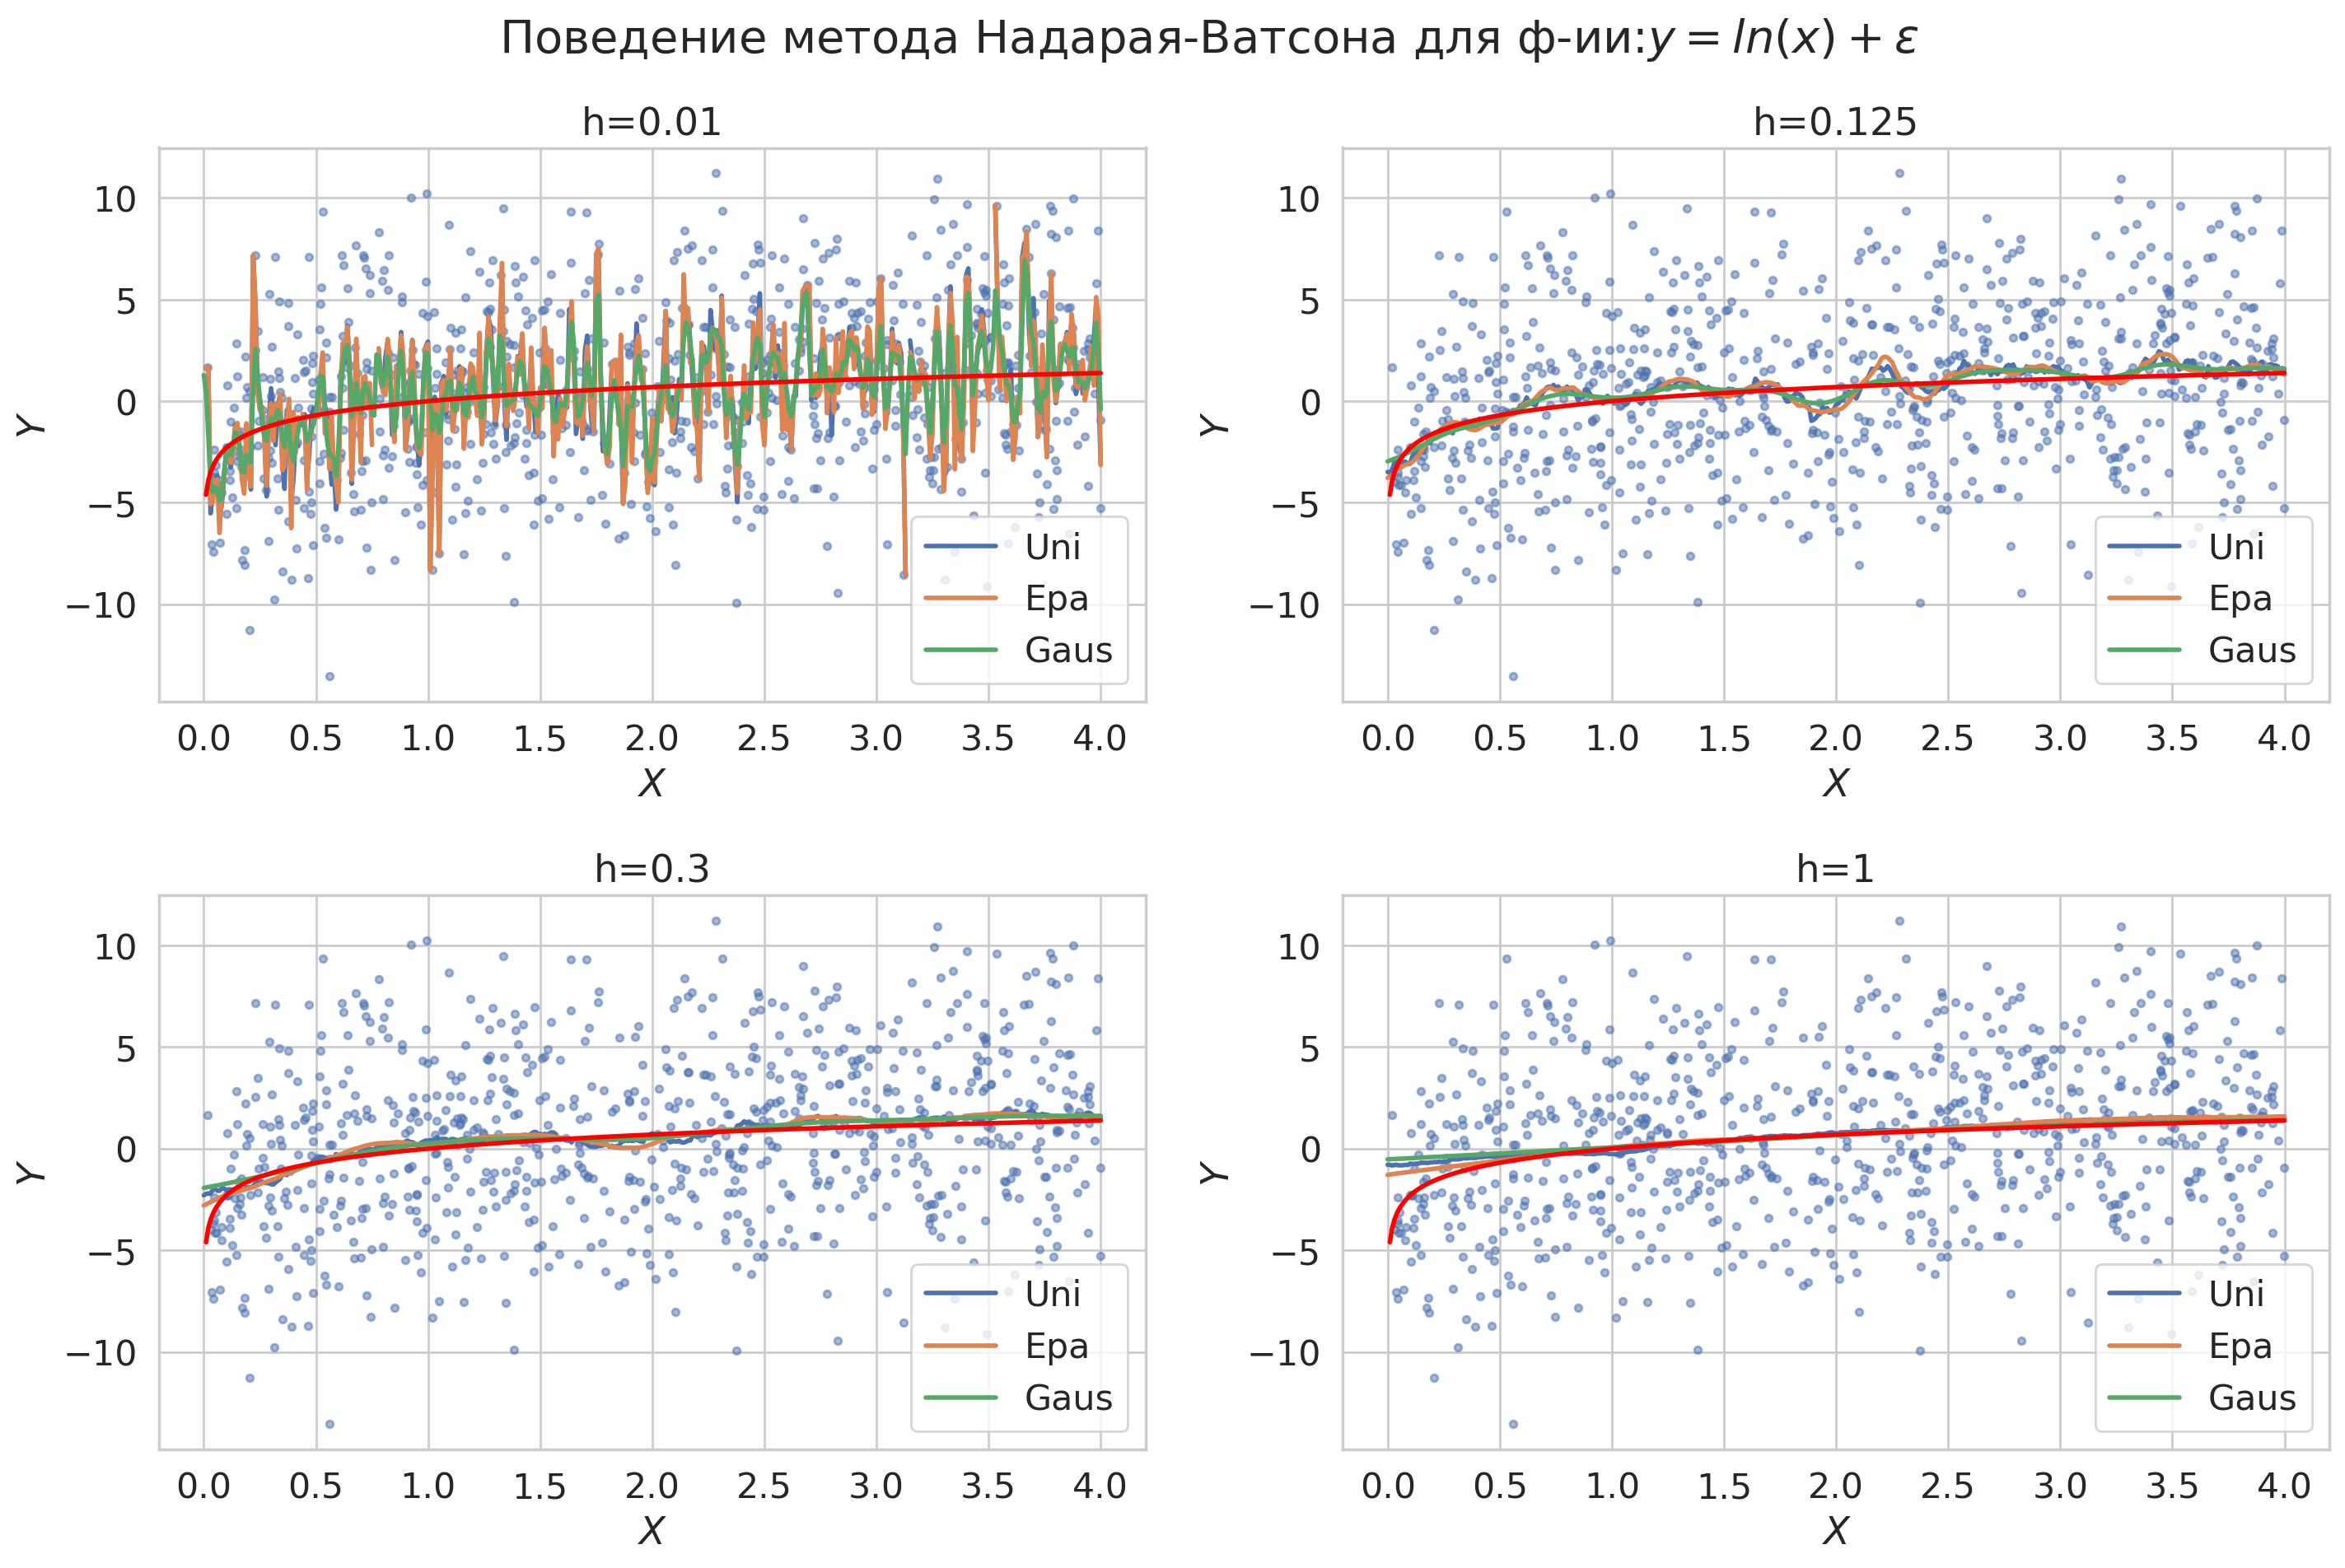

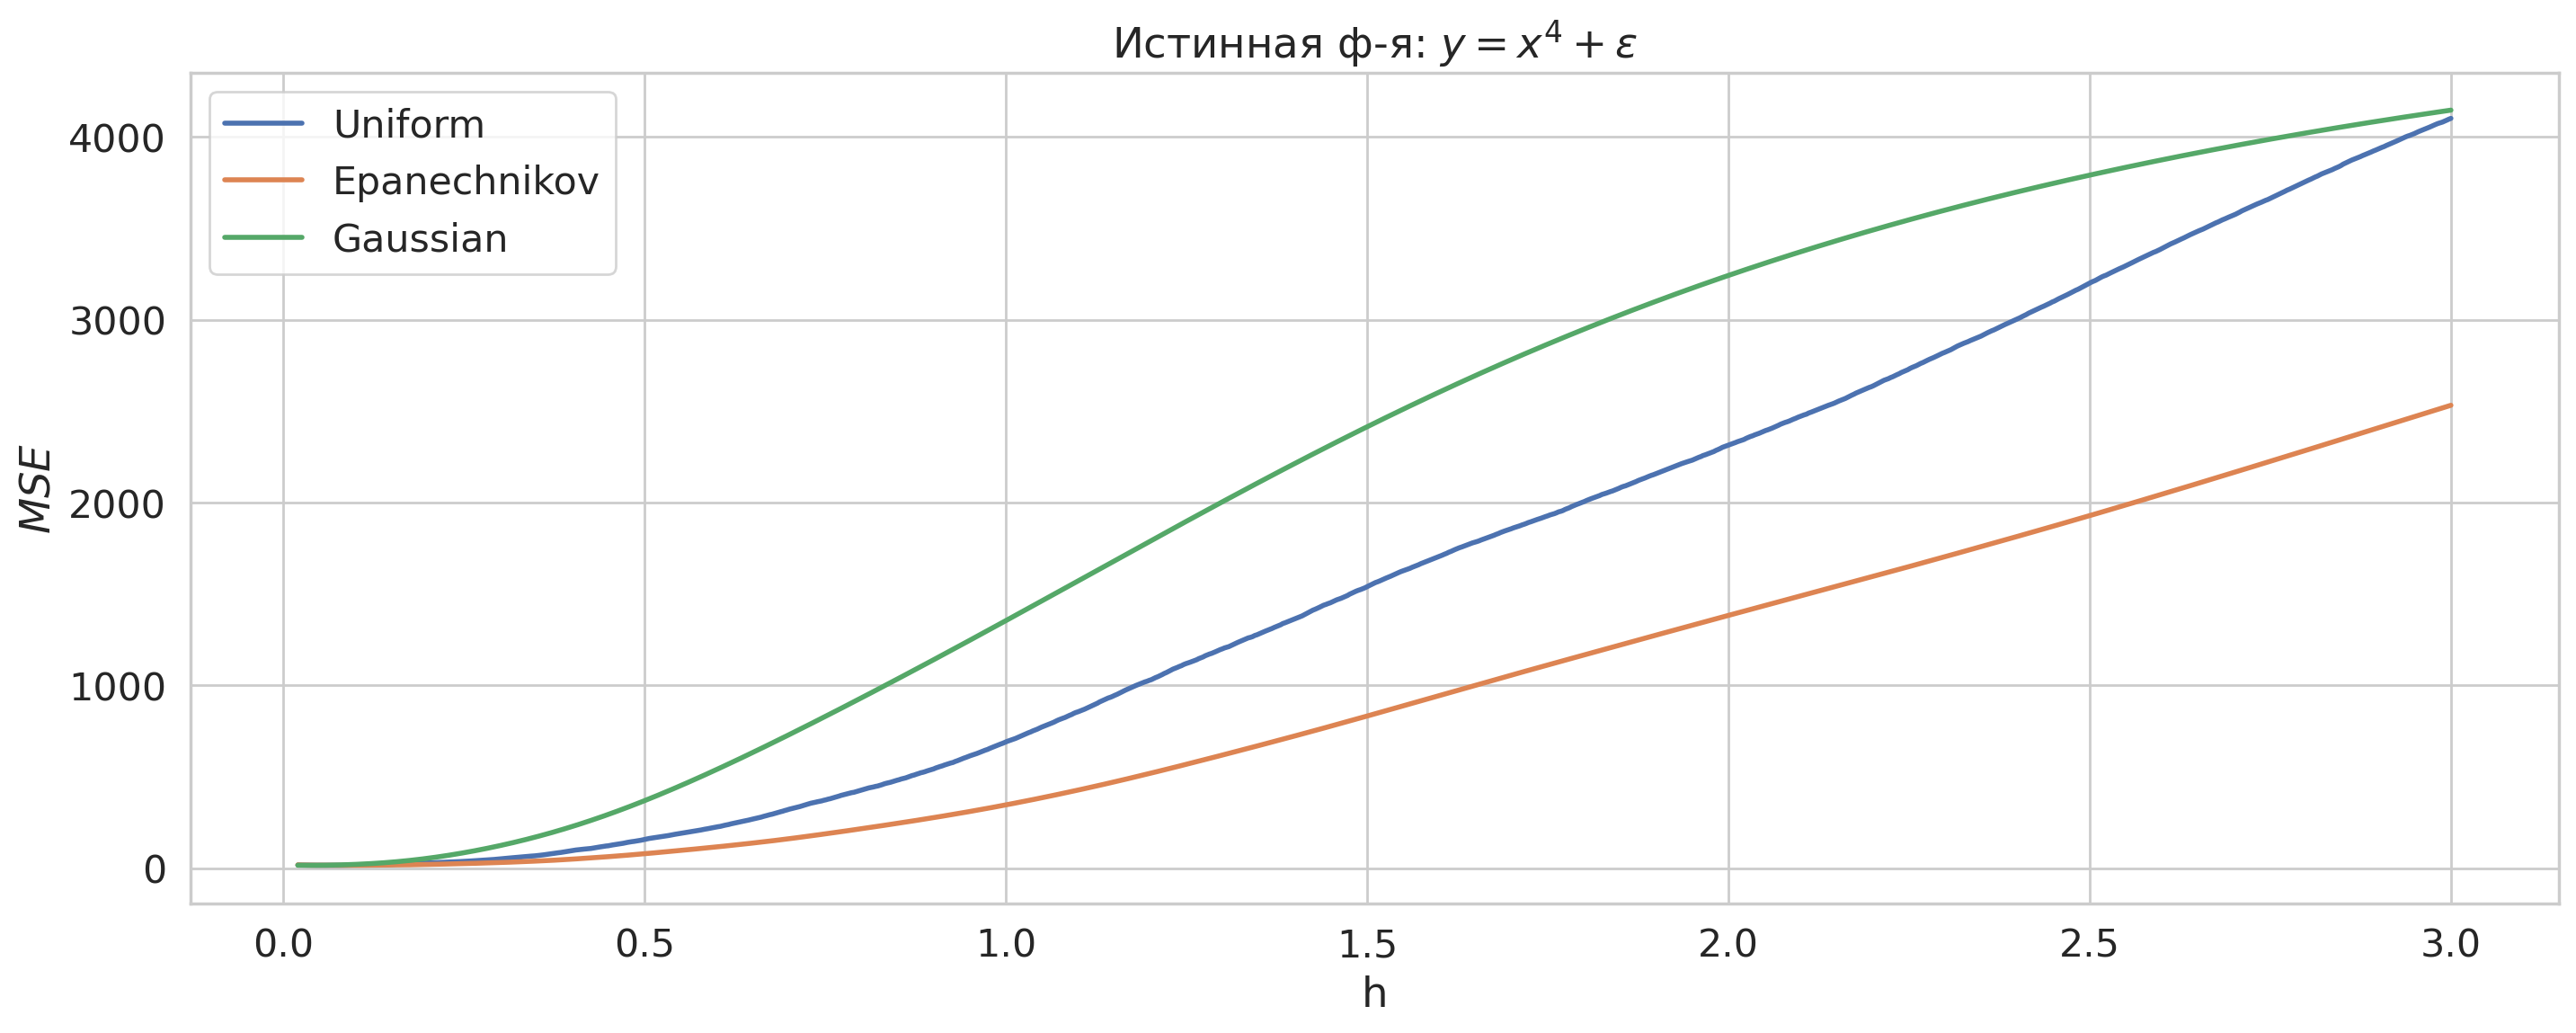

<Figure size 1200x1800 with 0 Axes>

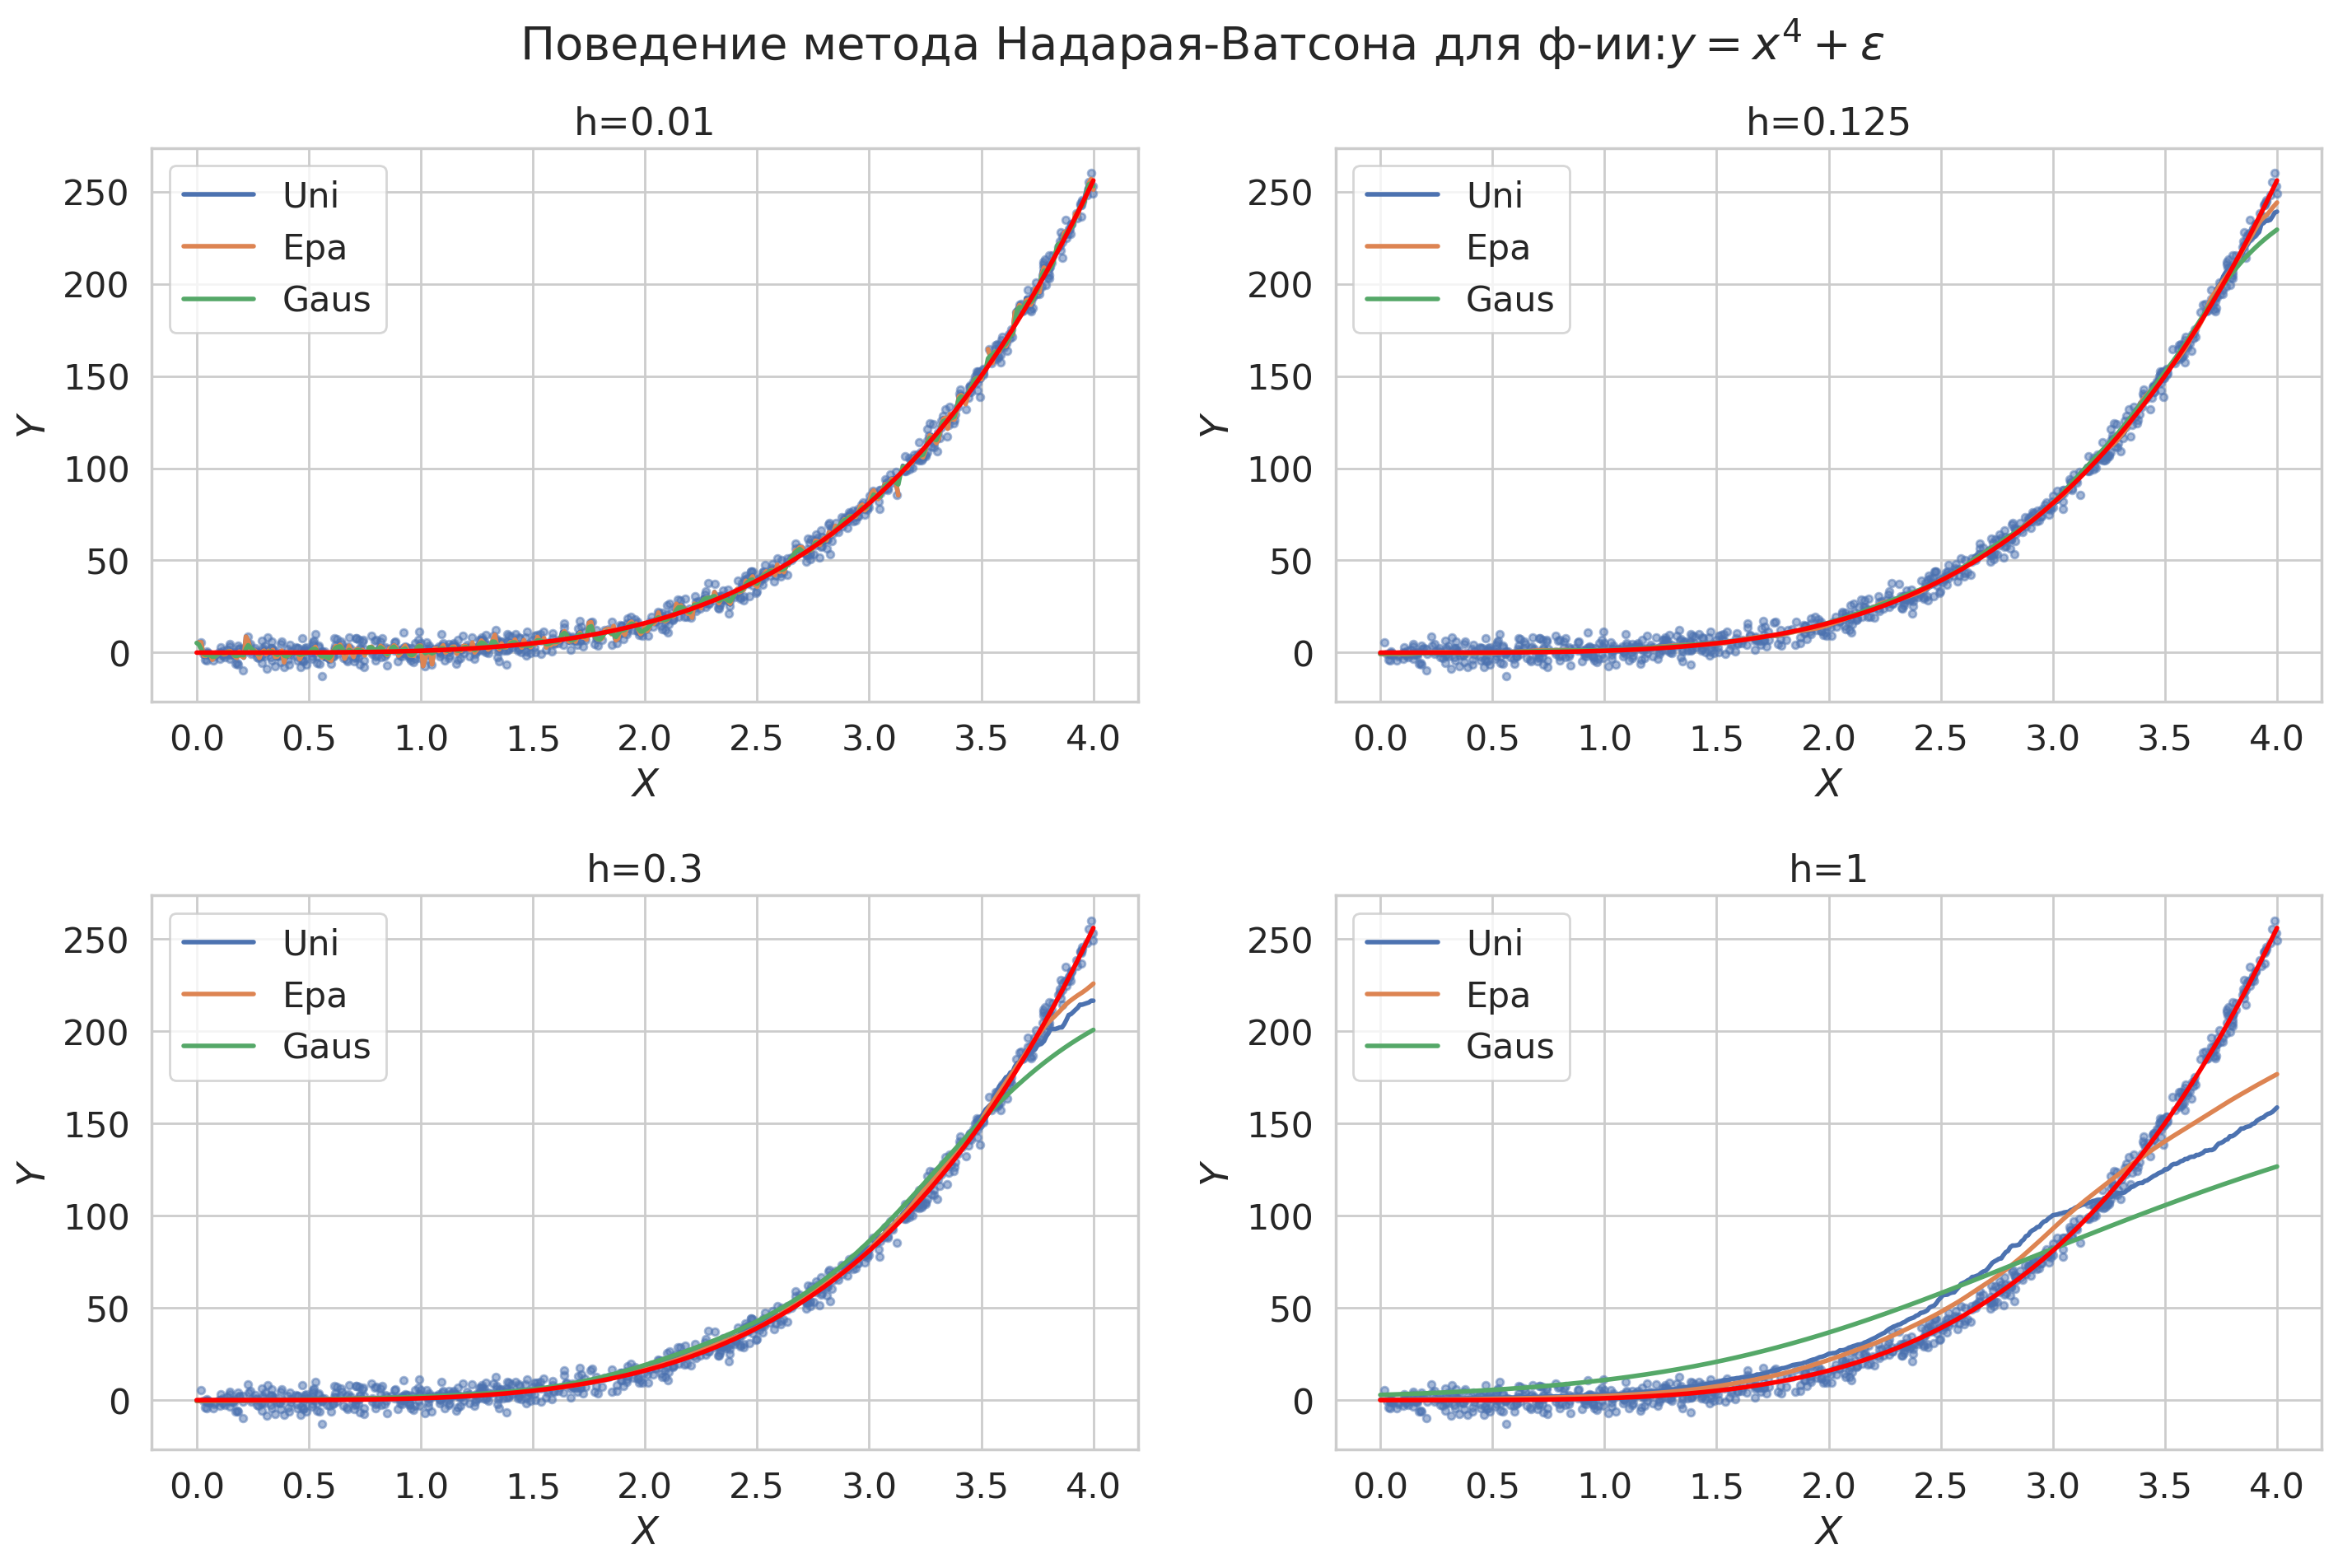

In [17]:
def narisovat_grafic_onlayn_bez_sms_i_registracii_zachem_wi_eto_chitaete(X, Y, name, f):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

    lables = ["Uniform", "Epanechnikov", "Gaussian"]

    mse = lambda K, X, Y, h: np.mean( (Y - (lambda A: (A @ Y_train) / A.sum(axis=1))    (K((X[:, None] - X_train[None, :]) / h))) ** 2 )

    h_grid = np.linspace(0.02, 3, 1000)
    plt.figure(figsize=(17,6))
    [plt.plot(h_grid, [mse(Kernels[j], X_val, Y_val, h) for h in h_grid], lw=2, label=lables[j]) for j in range(3)]
    plt.xlabel("h"); plt.ylabel(r"$MSE$"); plt.title("Истинная ф-я: " + name); plt.legend(loc="best")
    plt.show()

    x_grid = np.linspace(0, 4, 401)
    h_grid = [0.01, 0.125, 0.3, 1]

    model = lambda K, h, X: (lambda A: (A @ Y_train) / A.sum(axis=1))   (K((X[:, None] - X_train[None, :]) / h))

    plt.figure(figsize=(12,18))
    fig, axes_raw = plt.subplots(2, 2, figsize=(17, 10))
    fig.subplots_adjust(hspace=0.35, top=0.9)
    axes = axes_raw.ravel()
    fig.suptitle("Поведение метода Надарая-Ватсона для ф-ии:" + name)
    lables = ["Uni", "Epa", "Gaus"]

    for i in range(4):
        axes[i].scatter(X_train, Y_train, s=10, alpha=0.5) # Пожертвуем названием ради читаемости графика
        [axes[i].plot(x_grid, model(Kernels[j], h_grid[i], x_grid), label=lables[j], lw=2) for j in range(3)]
        axes[i].plot(x_grid, f(x_grid), lw=2, c="red")
        axes[i].set_xlabel(r"$X$"); axes[i].set_ylabel(r"$Y$"); axes[i].set_title(r"h=" + str(h_grid[i])); axes[i].legend(loc="best")
    plt.show


f1 = lambda X: 2 * np.sin(5 * X) + 15
f2 = lambda X: np.log(X)
f3 = lambda X: X ** 4

Y1 = f1(X) + sps.norm(0, 4).rvs(N, random_state=seed)
Y2 = f2(X) + sps.norm(0, 4).rvs(N, random_state=seed)
Y3 = f3(X) + sps.norm(0, 4).rvs(N, random_state=seed)

narisovat_grafic_onlayn_bez_sms_i_registracii_zachem_wi_eto_chitaete(X, Y1, r"$y = 2 * sin(5x) + \varepsilon$", f1)
narisovat_grafic_onlayn_bez_sms_i_registracii_zachem_wi_eto_chitaete(X, Y2, r"$y = ln(x) + \varepsilon$", f2)
narisovat_grafic_onlayn_bez_sms_i_registracii_zachem_wi_eto_chitaete(X, Y3, r"$y = x^4 + \varepsilon$", f3)

**Вывод:**

<font color="#ae69c9ff">

1. Оч оч важно подбирать h. Как я понял, внимательно изучив стену болтая, даже существует теор. способ это делать. Там было написано слезами, что для лин. сулчая оптимально $h=n^{\frac{-1}{5}}$, для нас это $\approx 0.26$, у меня получилось где-то 0.22 (круто!!!)
2. Я пока не умею байес-варианс считать численно, поэтому посмотрел глазами на результат на валидационной выборке. Получилось, что в случае минимального mse + оценки глазами, мы выходим на почти совпадение модели и искомой функции
3. Различные ядра работают по-разному, явного фаворита у меня не появилось. Принято использовать Epanechnikov по причинам, описанным на вики. Из того, что увидел, гауссово ядро работает с меньшим окном, оно как достигает минимального mse, так и начинает расти быстрее. Прикольно, что оно самое гладкое

<font color="#ae69c9ff">

Странные вопросы, которые появились у меня во время выполнения прака и на которые хочется уметь отвечать:
- Почему мы добавляем шум к тестовым данным?
- Что там происходит с ядром на краях? А на данных с малым размером выборки? Идейно, результат не должен быть корректен, т.к. интеграл не 1
- Почему мы забили на приведение к стандартной форме лин. регрессии?
- Что происходит при больших h?


Ответы:
- Т.к. хотим одинаковое распределение на данных (не уверен, что прям хотим)
- (0.) Ядро нормируется -> аля под интегралом всё-таки (1.) На краях выборки просто будет небольшое смещение, но сам "край" пройдём быстро, иначе - далее
- А вот так вот, Надарай-Ватсон умеет это учитывать самостоятельно. Идейно, мы вообще KNN реализовали, просто по-умному и чуть иначе (и вообще не KNN). (Считаем локальное взвешенно среднее вокруг x в каждой точке x)
- Оценка становится константой, т.к. под ядром делим на слишком большое число -> идейно везде считаем K(0)

_Зачем я себе так сильно работу усложнил_ $\dots$

Можете попробовать применить метод Надарая-Ватсона для выборки из задачи 3 и посмотреть, что получится (0 баллов)

## Задача 3. Библиотека statsmodels

*Данная задача стоит 10 баллов.*

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.yandexcloud.net/miptstats-public-files/pictures/housesbanner.png)

В частности мы будем смотреть на влияние различных признаков на стоимость дома (SalePrice) и проверим несколько гипотез.

In [18]:
# !pip install -q gdown
!gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe

Downloading...
From: https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe
To: /home/ivan/Desktop/stats/stats_private/HW_4_raw/train.csv
100%|████████████████████████████████████████| 461k/461k [00:00<00:00, 1.39MB/s]


In [19]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [20]:
df = pd.read_csv("train.csv")

# df.fillna("NA", inplace=True) Жесть, эта че... Зачем это?
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка.

Вспомните курс машинного обучения. Как можно обработать категориальные признаки, чтобы регрессионная модель была осмысленна?

Ответ:

<font color="#ae69c9ff">

Мда. Что тут происходит... Ну, давайте расскажу: идейно хотим, чтобы все признаки стали пихаемыми в лин. регрессию, пока мы знаем 2 типа:
- те, что тривиально линеаризуются (им можно циферки от 0 до n сопоставить)
- те, что являются категориальными (для них мы создали оч оч много столбцов и выкину по одному, чтобы добиться меньшей корреляции)

UPD: когда-то было сделано и второе, но прочитал задание далее и выпилил, ибо ну... не понадобилось.

In [21]:
qual_map = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_exposure_map = {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
bsmt_fin_type_map = {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]: df[col] = df[col].map(qual_map)
for col in ["BsmtExposure"]: df[col] = df[col].map(bsmt_exposure_map)
for col in ["BsmtFinType1", "BsmtFinType2"]: df[col] = df[col].map(bsmt_fin_type_map)


bin_maps = {"Street": {"Grvl": 0, "Pave": 1}, "Alley": {"Grvl": 0, "Pave": 1},
    "CentralAir": {"N": 0, "Y": 1}, "Utilities": {"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3}}
for col, m in bin_maps.items(): df[col] = df[col].map(m)


df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley LotShape  \
0   1          60       RL         65.0     8450       1    NaN      Reg   
1   2          20       RL         80.0     9600       1    NaN      Reg   
2   3          60       RL         68.0    11250       1    NaN      IR1   
3   4          70       RL         60.0     9550       1    NaN      IR1   
4   5          60       RL         84.0    14260       1    NaN      IR1   

  LandContour  Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl          3  ...        0    NaN   NaN         NaN       0   
1         Lvl          3  ...        0    NaN   NaN         NaN       0   
2         Lvl          3  ...        0    NaN   NaN         NaN       0   
3         Lvl          3  ...        0    NaN   NaN         NaN       0   
4         Lvl          3  ...        0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

<font color="#ae69c9ff">

Наверное стоит читать задание полностью, прежде чем его делать............................

### Визуализируйте данные
Прочитайте описание датасета на Kaggle.

Сначала надо произвести выбор признаков. В рамках этой задачи будет достаточно предложить не менее 10 признаков, которые Вам просто кажутся разумными. Более честный подход -- отбор признаков -- будет рассмотрен в следующей задаче, так что, как вариант, можете сначала решить её, а потом вернуться сюда с найденными признаками.

Перед тем как начать использовать линейные модели, необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать [корреляцию Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#For_a_sample). Используя ``sns.heatmap``, постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика адекватным, например, ``figsize=(11, 10)``.

Какие признаки Вам кажутся самыми полезными?

In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns # Ну, собственнно, оставим только численные.
print(df[num_cols].shape)

(1460, 55)


<font color="#ae69c9ff">

Ого, а их мгного. 4 задачу до тертьей делать вайба не нахожу (авторам предлагается поменять нумерацию, если это важно. Я волнуюсь, что она могла быть не просто так именно такой), так что пойдём тривиальным путём - посмотрим на корреляцию признаков с ценой и выберем лучшие 12.

<bound method IndexOpsMixin.tolist of Index(['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual',
       'BsmtQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'Alley', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')>


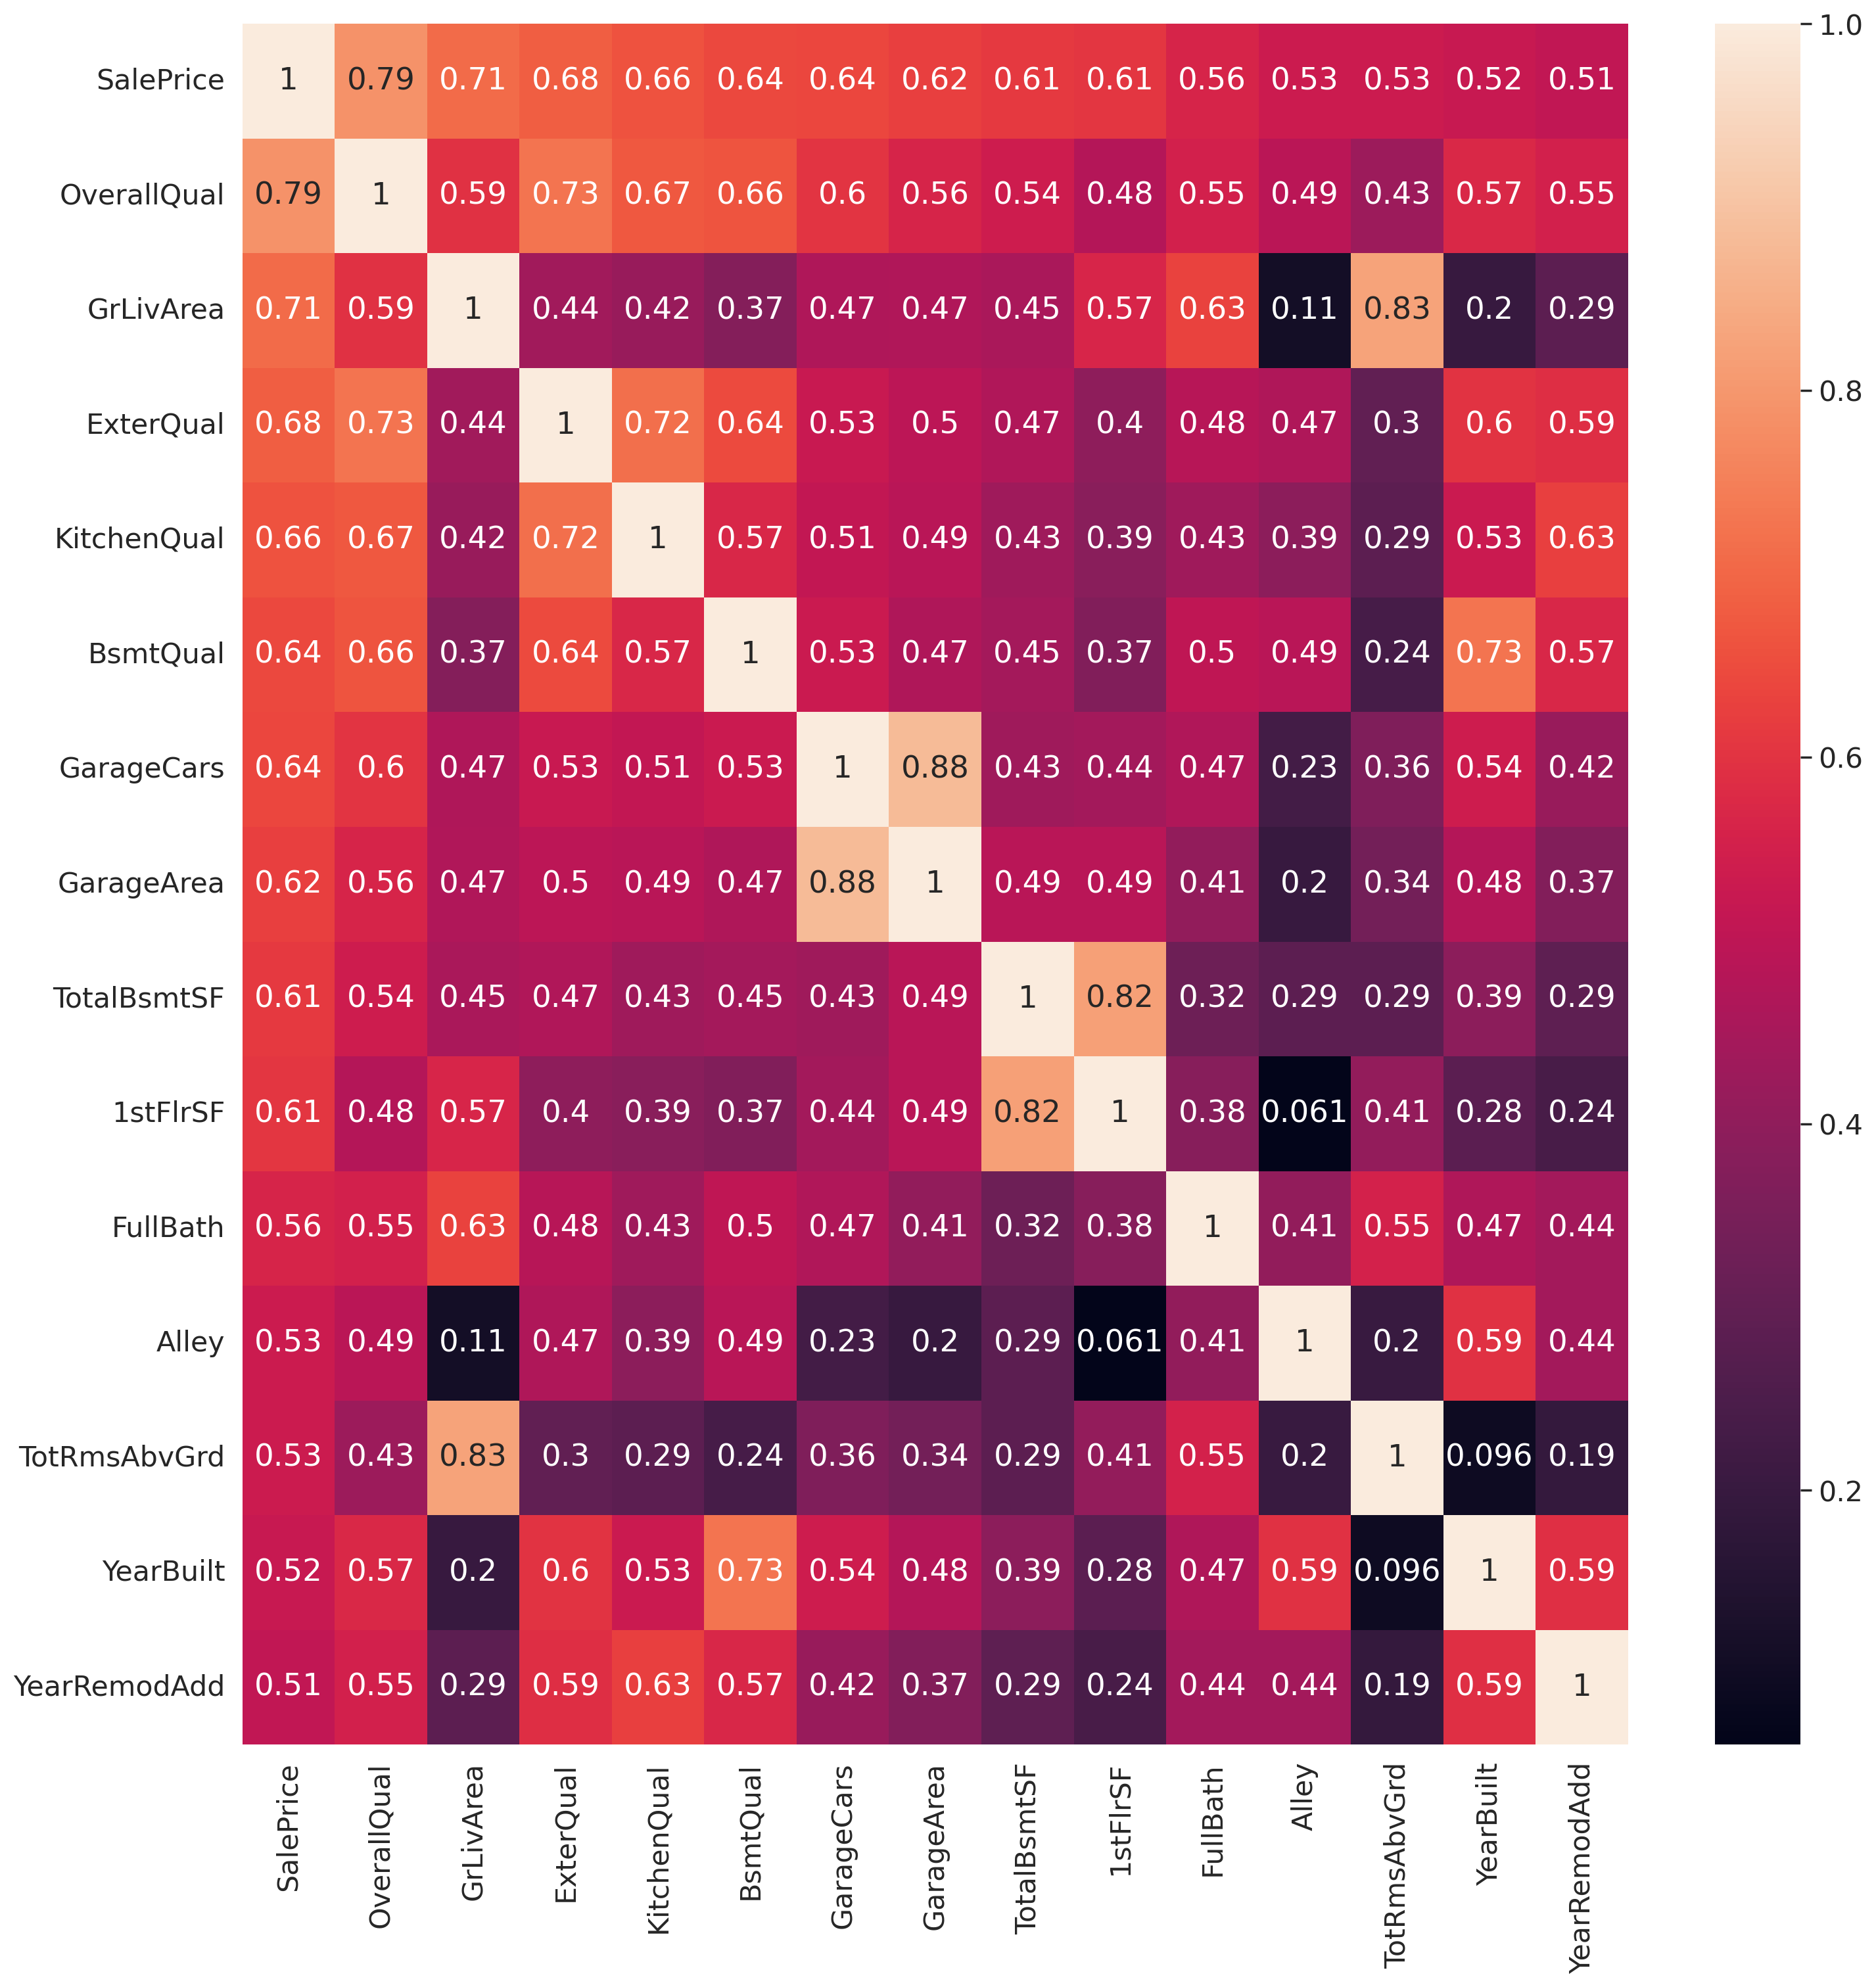

In [23]:
filtered_df = df[df[num_cols].corr()["SalePrice"].abs().sort_values(ascending=False).head(15).index.tolist()]
# filtered_df.dropna(inplace=True)
print(filtered_df.columns.to_list)

plt.figure(figsize=(17, 17))
sns.heatmap(filtered_df.corr().abs(), annot=True)
plt.show()

Изучите карту и сделайте по ней выводы о зависимости в данных ($|r_{XY}| > 0.9$). А чем плохи зависимые признаки? Для ответа на последний вопрос напишите, чему равно аналитическое решение задачи регрессии.

**Ответ:**

Удалите, если требуется, скоррелированные признаки (все, кроме одного).

<font color="#ae69c9ff">

Больше 0.9 корреляция встретилась 0 раз, но это не значит, что оставим всё, как есть. Мной предлагается бахнуть порог 0.63 и посмотреть на всё, что выше. Там из названий очев, что есть что и что они сильно связаны. (Вот, например, OverallQual и ExternalQual сильно связаны из соображний здравого смысла). Дальше, чтобы ответить на вопрос: а какой признак стоит выкинуть? посмотрим на корреляцию с ценой: где ниже, тот и выбросим

In [24]:
print(filtered_df.head)

<bound method NDFrame.head of       SalePrice  OverallQual  GrLivArea  ExterQual  KitchenQual  BsmtQual  \
0        208500            7       1710          4            4       4.0   
1        181500            6       1262          3            3       4.0   
2        223500            7       1786          4            4       4.0   
3        140000            7       1717          3            4       3.0   
4        250000            8       2198          4            4       4.0   
...         ...          ...        ...        ...          ...       ...   
1455     175000            6       1647          3            3       4.0   
1456     210000            6       2073          3            3       4.0   
1457     266500            7       2340          5            4       3.0   
1458     142125            5       1078          3            4       3.0   
1459     147500            5       1256          4            3       3.0   

      GarageCars  GarageArea  TotalBsmtSF  1s

In [25]:
# filtered_df.drop(columns=["ExterQual", "KitchenQual", "BsmtQual", "TotRmsAbvGrd", "GarageArea", "1stFlrSF", "FullBath"], inplace=True)
filtered_df.drop(columns=["TotRmsAbvGrd", "GarageArea", "1stFlrSF"], inplace=True) # С таким набором признаков получим R^2 = 0.787

/tmp/ipykernel_2083725/1268960246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["TotRmsAbvGrd", "GarageArea", "1stFlrSF"], inplace=True) # С таким набором признаков получим R^2 = 0.787


<font color="#ae69c9ff">

Решение задачи лин. регрессии - есть: $\hat\theta = (Z^\top Z)^{-1}Z^\top X$, явно видно, что мы хотим обратить матрицу, но если признаки имеют лин. зависимость, то определитель матрицы $0$ (или очень близок к нему, т.к. всё-таки есть фактор шума), т.е. при обращении мы получим около бесконечное число, что плохо для подсчёта

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонали $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

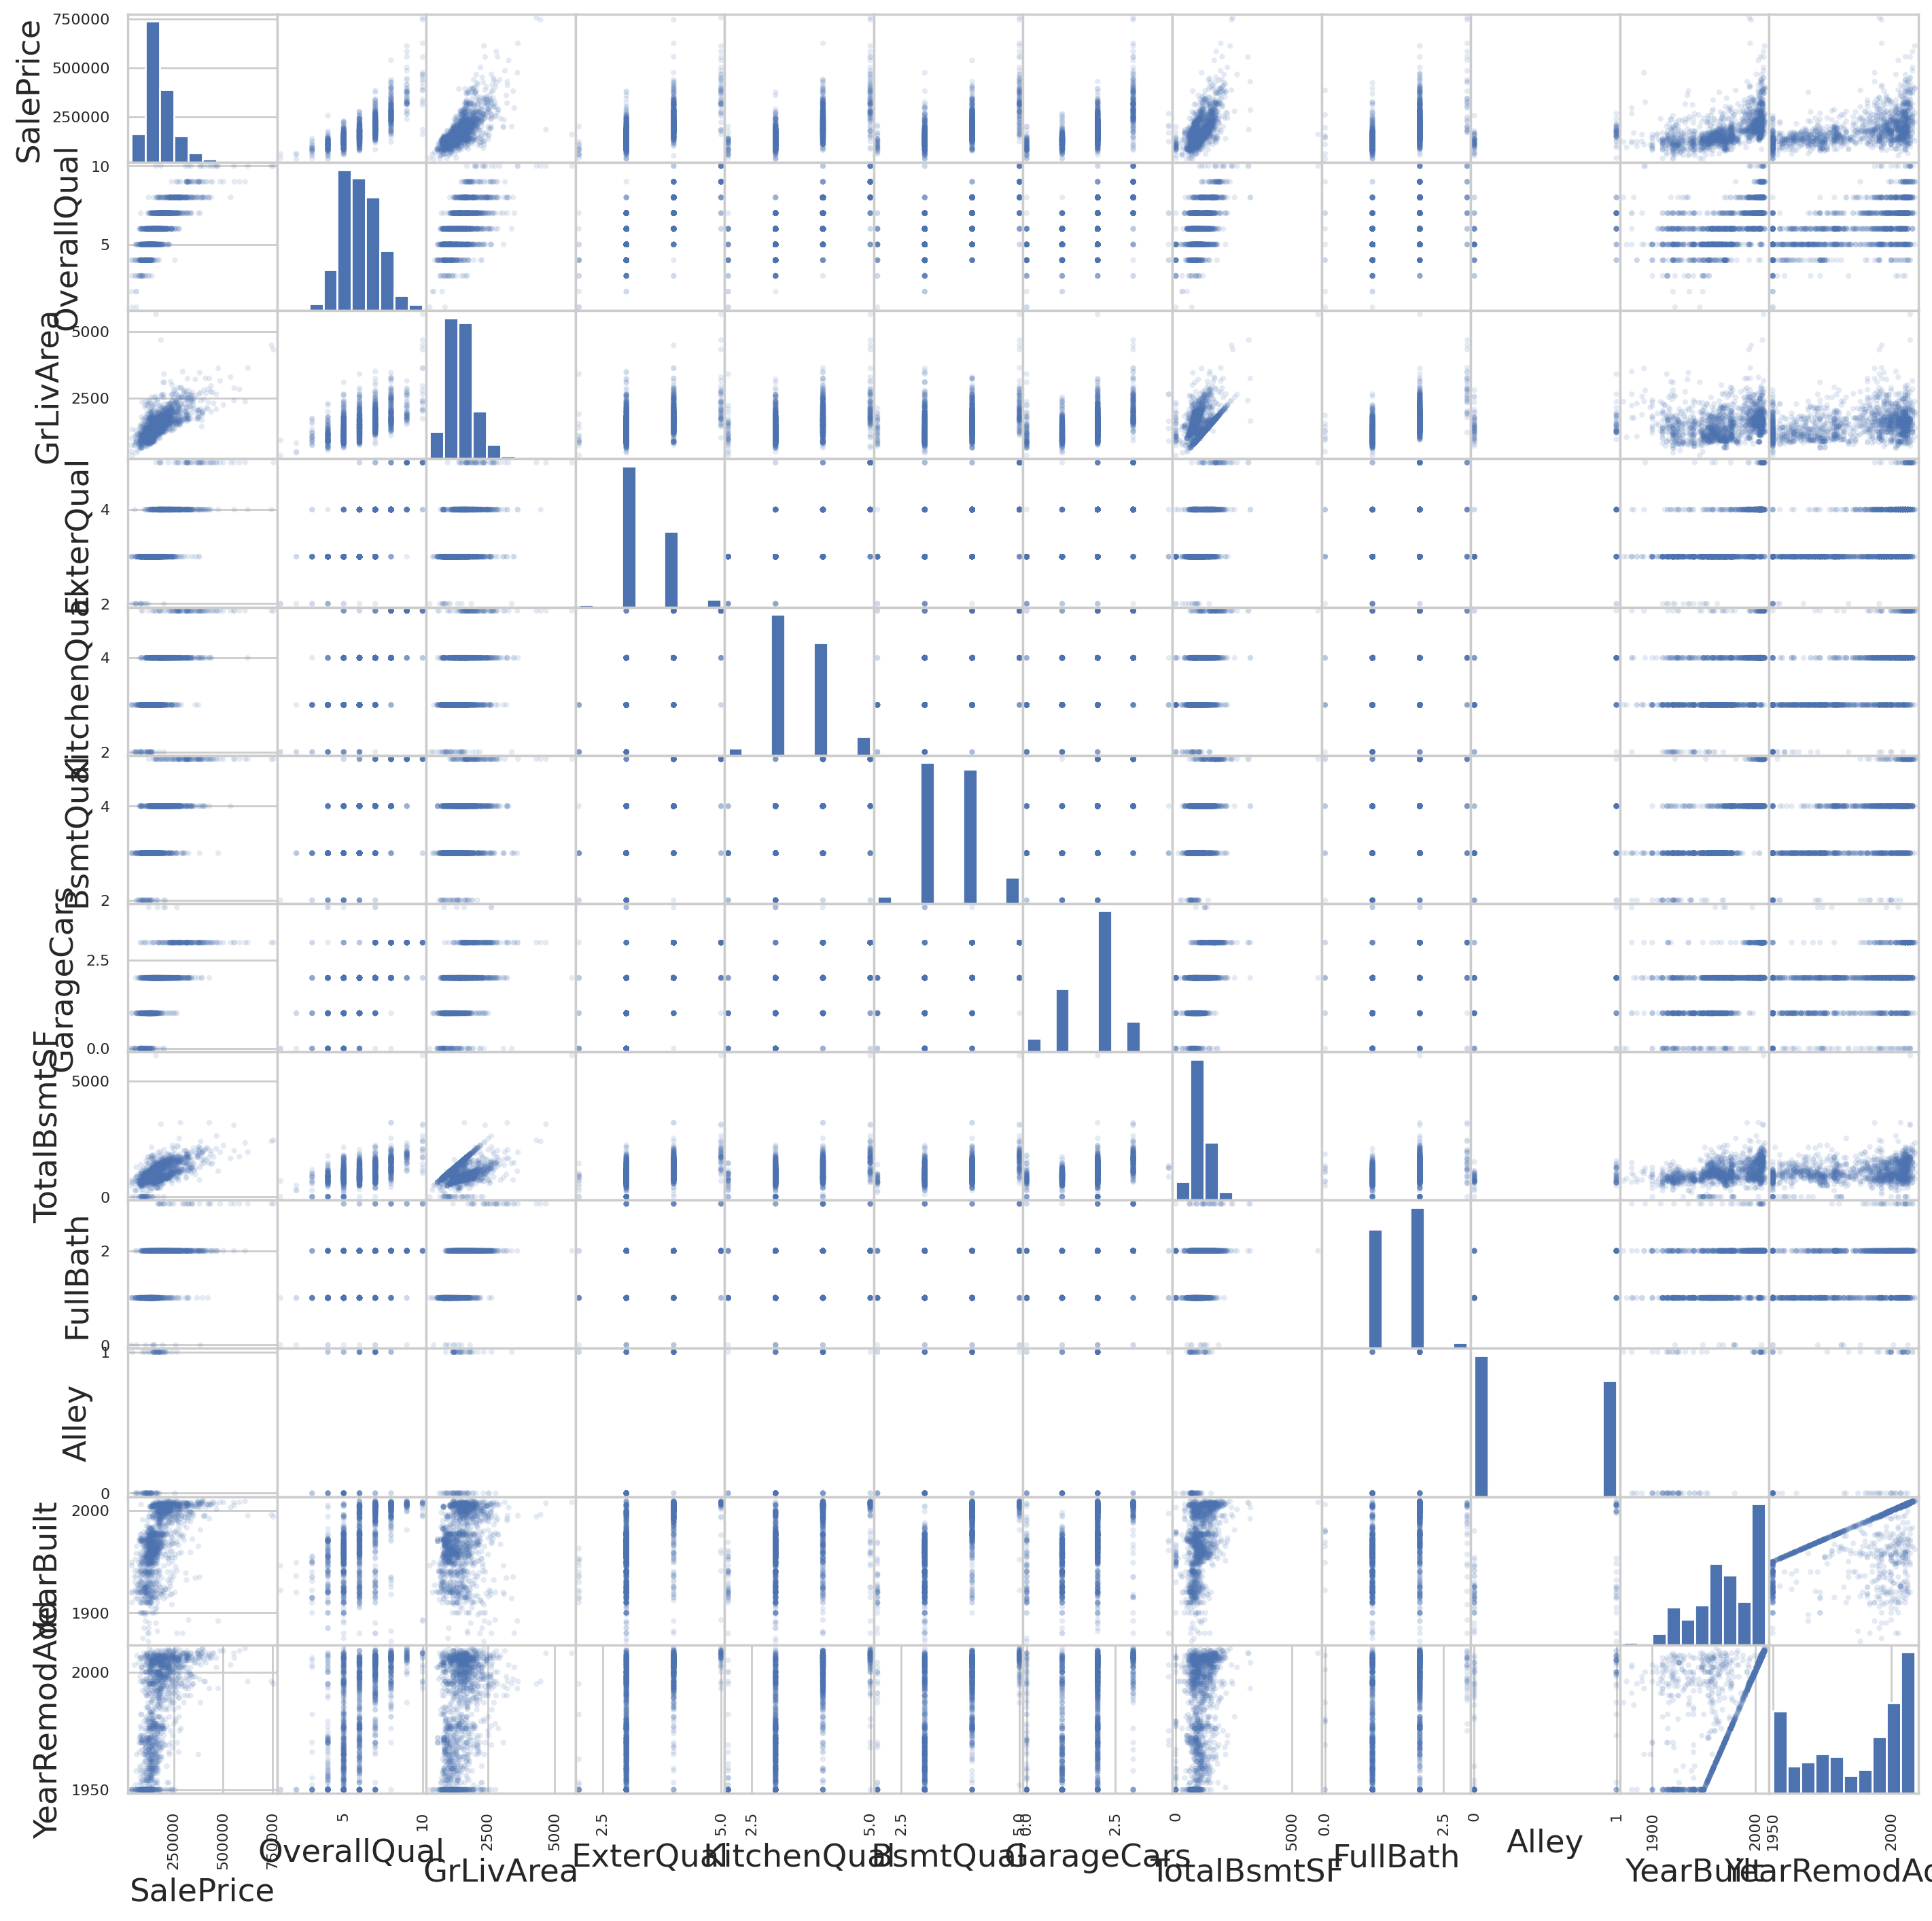

In [26]:
pd.plotting.scatter_matrix(filtered_df, figsize=(17, 17), diagonal='hist', alpha=0.15)
plt.show()

Сделайте вывод о данных. Опишите, нужна ли регуляризация и почему?

<font color="#ae69c9ff">

Сложно. Сложно из-за полного отсутствия насмотренности в этом вопросе.\
Каких-то страшных сильных явно-линейных зависимостей я не вижу (кроме `YearBuilt` и `YearRemodAdd`, удалим последнее). Может быть, `TotalBsmtSF` и `GrLivArea` могут давать что-то похожее, но там и совариация низковата, и очень много шума.

Есть предположение, что мы можем обойтись здесь без регуляризации. У нас достаточно низкое число наблюдений и очень много шума в предположительно зависимых наблюдениях -> матрица не должна оказаться вырожденной

In [27]:
filtered_df.drop(columns=["YearRemodAdd"], inplace=True)

/tmp/ipykernel_2083725/3772664906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["YearRemodAdd"], inplace=True)


### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит, что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать, понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [28]:
print(filtered_df.shape)
print(filtered_df.isna().sum())

(1460, 11)
SalePrice         0
OverallQual       0
GrLivArea         0
ExterQual         0
KitchenQual       0
BsmtQual         37
GarageCars        0
TotalBsmtSF       0
FullBath          0
Alley          1369
YearBuilt         0
dtype: int64


<font color="#ae69c9ff">

А, ну, всё, увы, аллею мы тоже не учитываем.

In [29]:
filtered_df.drop(columns=["Alley"], inplace=True)

/tmp/ipykernel_2083725/3139370421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["Alley"], inplace=True)


In [30]:
my_columns = filtered_df.columns.tolist()[1:]
formula = "SalePrice ~ " + " + ".join(my_columns)

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + BsmtQual + GarageCars + TotalBsmtSF + FullBath + YearBuilt


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``.

In [31]:
simple_model = smf.ols(formula, data=filtered_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     578.5
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:22:00   Log-Likelihood:                -16974.
No. Observations:                1423   AIC:                         3.397e+04
Df Residuals:                    1413   BIC:                         3.402e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.972e+05   9.99e+04     -2.974      

<font color="#ae69c9ff">

Хочется сделать промежуточный вывод по поводу того, что мы получили:
- моделька получилась с `R-squared` = 0.768, что есть классный результат для лин. модели
- данные репрезентативны, т.к. коэффициенты отличны от нуля и их p-value по мнению `smf` очень близки к нулю, как и вероятность общей гипотезы, что все коэф. разом 0
- `Condition Number` высокий по мнению модельки, может указывать на неортогональность признаков

### Гетероскедастичность ошибки

**Гомоскедастичностью** называют свойство одинаковости дисперсии и независимость остатков модели.

**Гетероскедастичностью** наоборот называют свойство неодинаковости (например, с зависимостью от номера измерения)
дисперсии и независимость остатков модели.

Оценка, полученная с помощью гауссовской линейной модели, будет "хорошей" лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается, то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_simple_model.resid``, а параметры из ``fitted_simple_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [32]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid,
                                            exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.261279424664414e-82


Отвергается ли гипотеза о гомоскедастичности остатков? Что это означает?

**Ответ:**

<font color="#ae69c9ff">

`p-value` мало, при любом разумном уровне доверия гипотеза о гомоскедастичности отвергается. Получается, дисперсия скорее всего не постоянна и сильно зависит от исходных данных

А ещё на стене болтая выведено слезами, что t и F критерии в случае гетероскедастичности пеерстают быть корректными

В случаях, когда распределение остатков не является гомоскедастичным, оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [33]:
fitted_simple_model = simple_model.fit(cov_type="HC1")

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     278.3
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          2.25e-305
Time:                        15:22:00   Log-Likelihood:                -16974.
No. Observations:                1423   AIC:                         3.397e+04
Df Residuals:                    1413   BIC:                         3.402e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.972e+05   1.23e+05     -2.426      

Проанализируйте результаты. Как изменились показатели из таблицы?

**Ответ:**

<font color="#ae69c9ff">

Коэфициенты, `R`, `l-ll` - всё, как и было\
Изменилось:
- стал `z`-критерий, до этого был `t`
- Немного выросли `P>|z|`
- Немного расширились доверительные интервалы
- Очев изменился тип ков. мтарицы

### Преобразование целевого признака

Посмотрим на распределение остатков линейной модели с целевой величиной `SalePrice`. Постройте QQ-plot для нормального распределения и гистограмму остатков.

In [34]:
resid = fitted_simple_model.resid
# resid = sorted(np.asarray(resid.values))[20:-20] <- "так" ниже - это вот так

<font color="#ae69c9ff">

Взглянув на резултаты ниже я подумал, что вообще центральная часть выглядит, как нормальное распределение, а ошибки по краям хорошо описываются выбросами (кстати, вероятно, из-за них робастная модель ранее дала чуть более широкие ДИ ранее). Так давайте же просто избавимся от них.

Посовещавшись с умными людьми под луной и со стеной болтая я приш1л к тому, что это всё-таки плохое решение и стоит обосновывать такие процедуры с данными до начала исследования. Да и в принципе вся эта идея звучит, как 0 баллов за прак по причине подгонки модели под желаемый результат

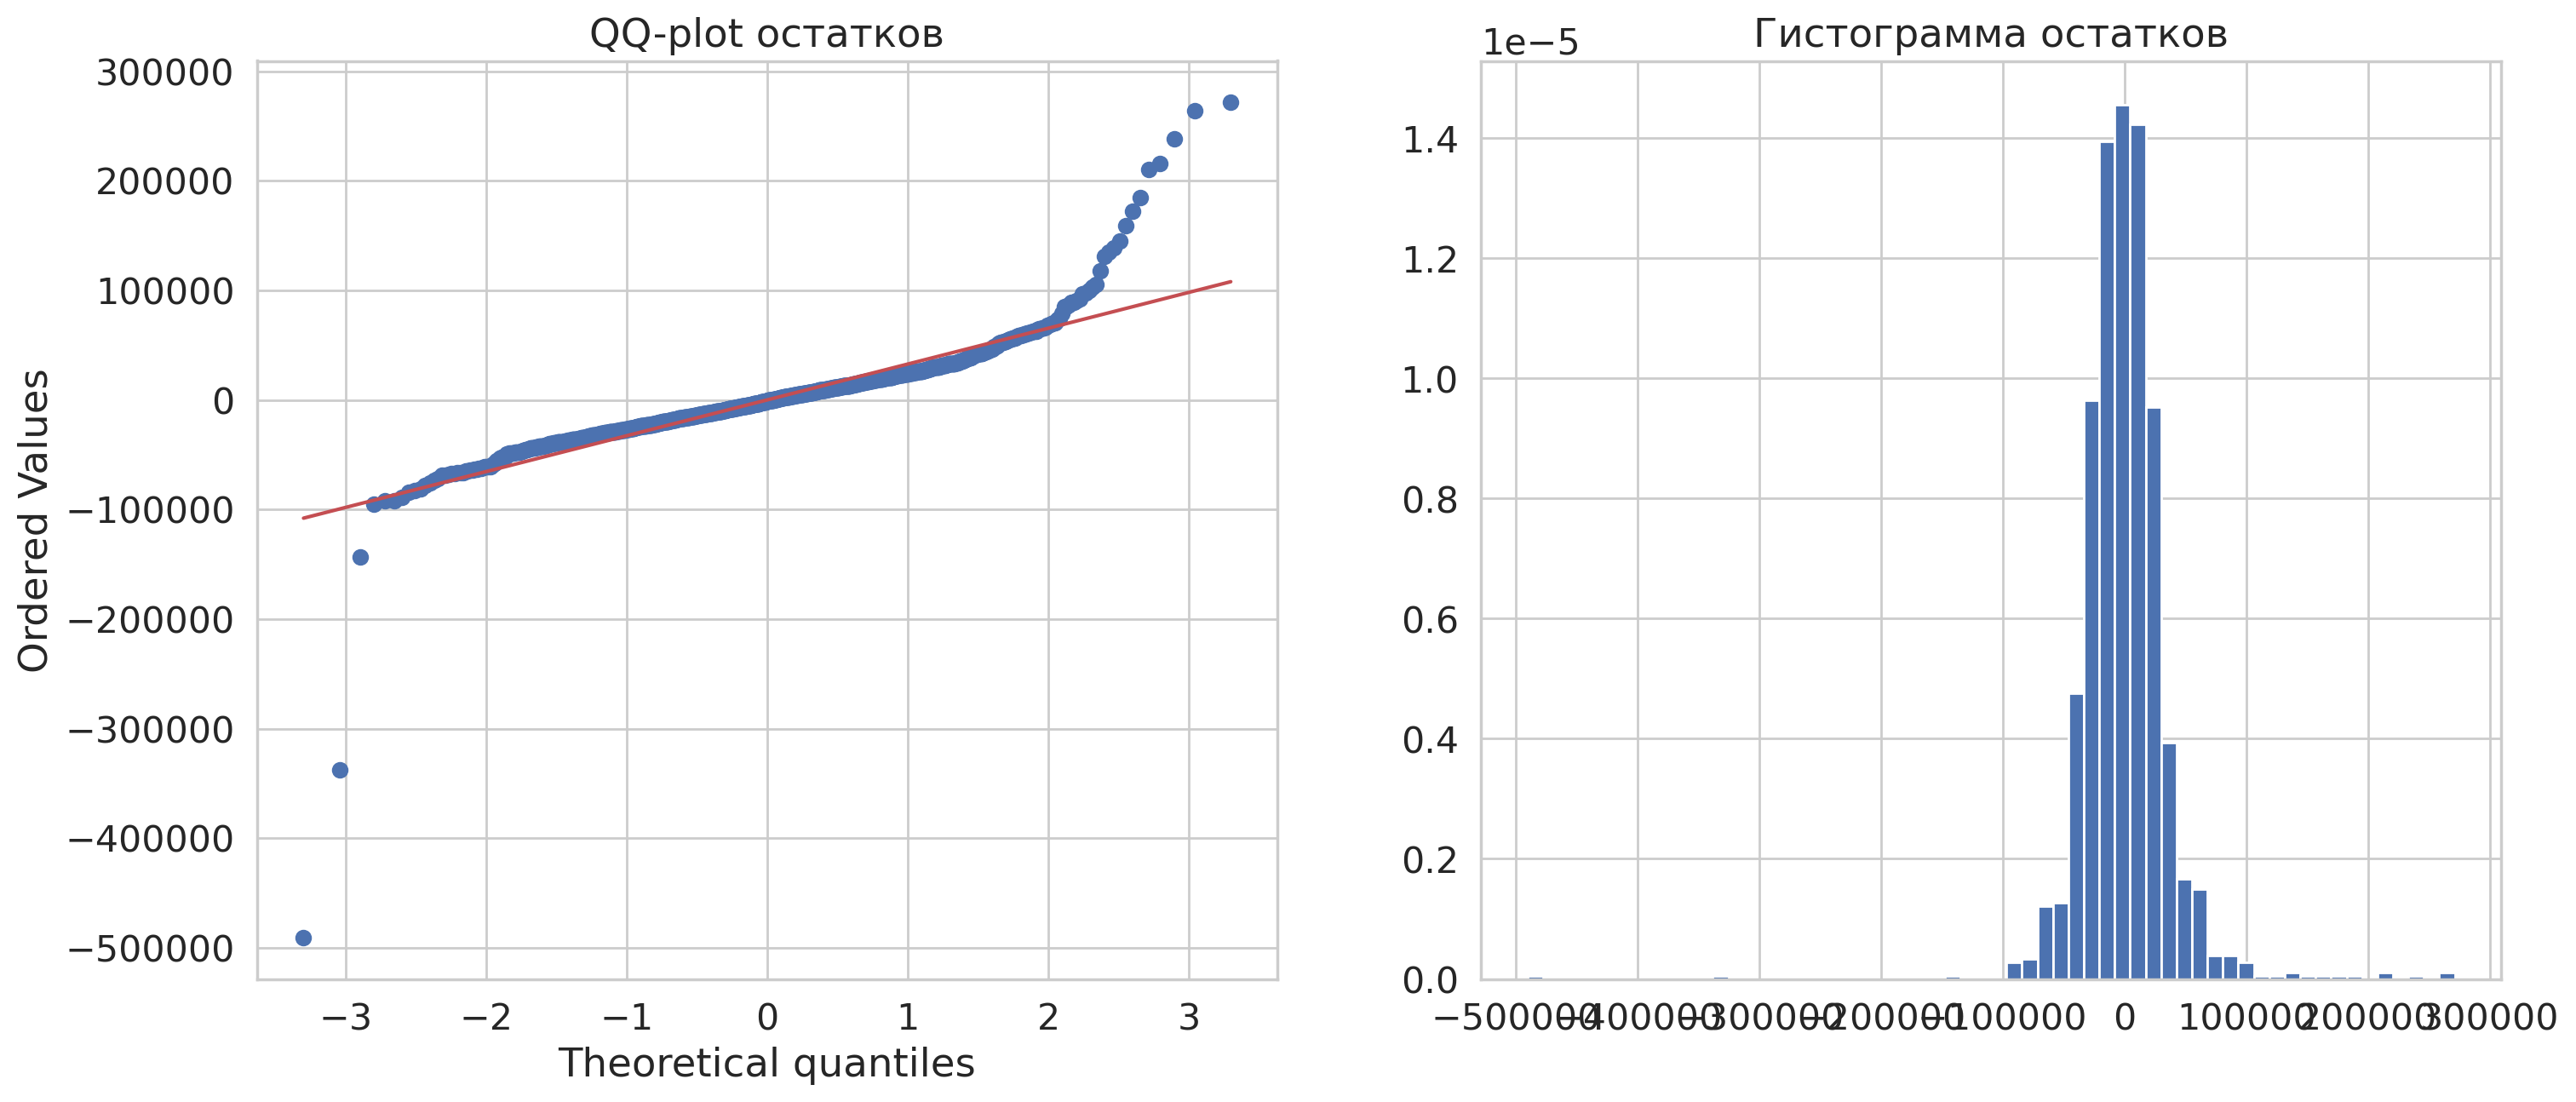

По мнению критерия Шапиро-Уилка нормальность распределения ошибок отвергается
p-value = 7.989622141858386e-39


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

sps.probplot(resid, dist="norm", plot=axes[0])
axes[0].set_title("QQ-plot остатков")
axes[1].hist(resid, bins=60, density=True)
axes[1].set_title("Гистограмма остатков")
plt.show()

pvalue = sps.shapiro(resid).pvalue
print("По мнению критерия Шапиро-Уилка нормальность распределения ошибок", "отвергается" if pvalue < ALPHA else "не отвергается")
print("p-value =", pvalue)

Как вы считаете, можно ли сказать, что распределение остатков нормально?

**Ответ:**

<font color="#ae69c9ff">

Принимать нормальность ошибок в этой модели будет очень грубым нарушением, мы никак не выходим на неё. Про гистограмму я ничего не могу сказать (ну очень низкая дисперсия, и ладно, фиг бы с ней), а вот qq-plot и тест Шапиро-Уилка явно говорят об отсутствии нормальности при любом разумном уровне доверия. (очень уж тяжелые хвосты)

UPD: После выполнения задания я понял, что плохо отобрал признаки (там прям сильно налажал, по ошибке выкинул почти все не численные признаки), поэтому было принято решение переделать. Вывод врока как тот же

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например, можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" --- и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

In [36]:
formula = "np.log(SalePrice) ~ " + " + ".join(my_columns[:-1])
print(formula)

simple_model = smf.ols(formula, data=filtered_df)
fitted_simple_model = simple_model.fit(cov_type="HC1")
print(fitted_simple_model.summary())

np.log(SalePrice) ~ OverallQual + GrLivArea + ExterQual + KitchenQual + BsmtQual + GarageCars + TotalBsmtSF + FullBath
                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     524.5
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:22:00   Log-Likelihood:                 473.15
No. Observations:                1423   AIC:                            -928.3
Df Residuals:                    1414   BIC:                            -880.9
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-----------

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:**

<font color="#ae69c9ff">

ОГО! Мы за бесплтано повысили точность модели на $3\%$. Однако, это не то чтобы прям честное (сравнительно малые приращения на очень больших значениях стоимости станут не различимыми. Мы теперь предсказываем количество нулей в ценнике) улучшение. Просто сделали связь чуть более линейной и как раз-таки коственно обрезали верхний край распределения, он стали вносить много меньшую ошибку (но при этом мы завалили нижний)


Постройте графики остатков, аналогичные тем, что встретились нам на две ячейки выше (QQ-plot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм.

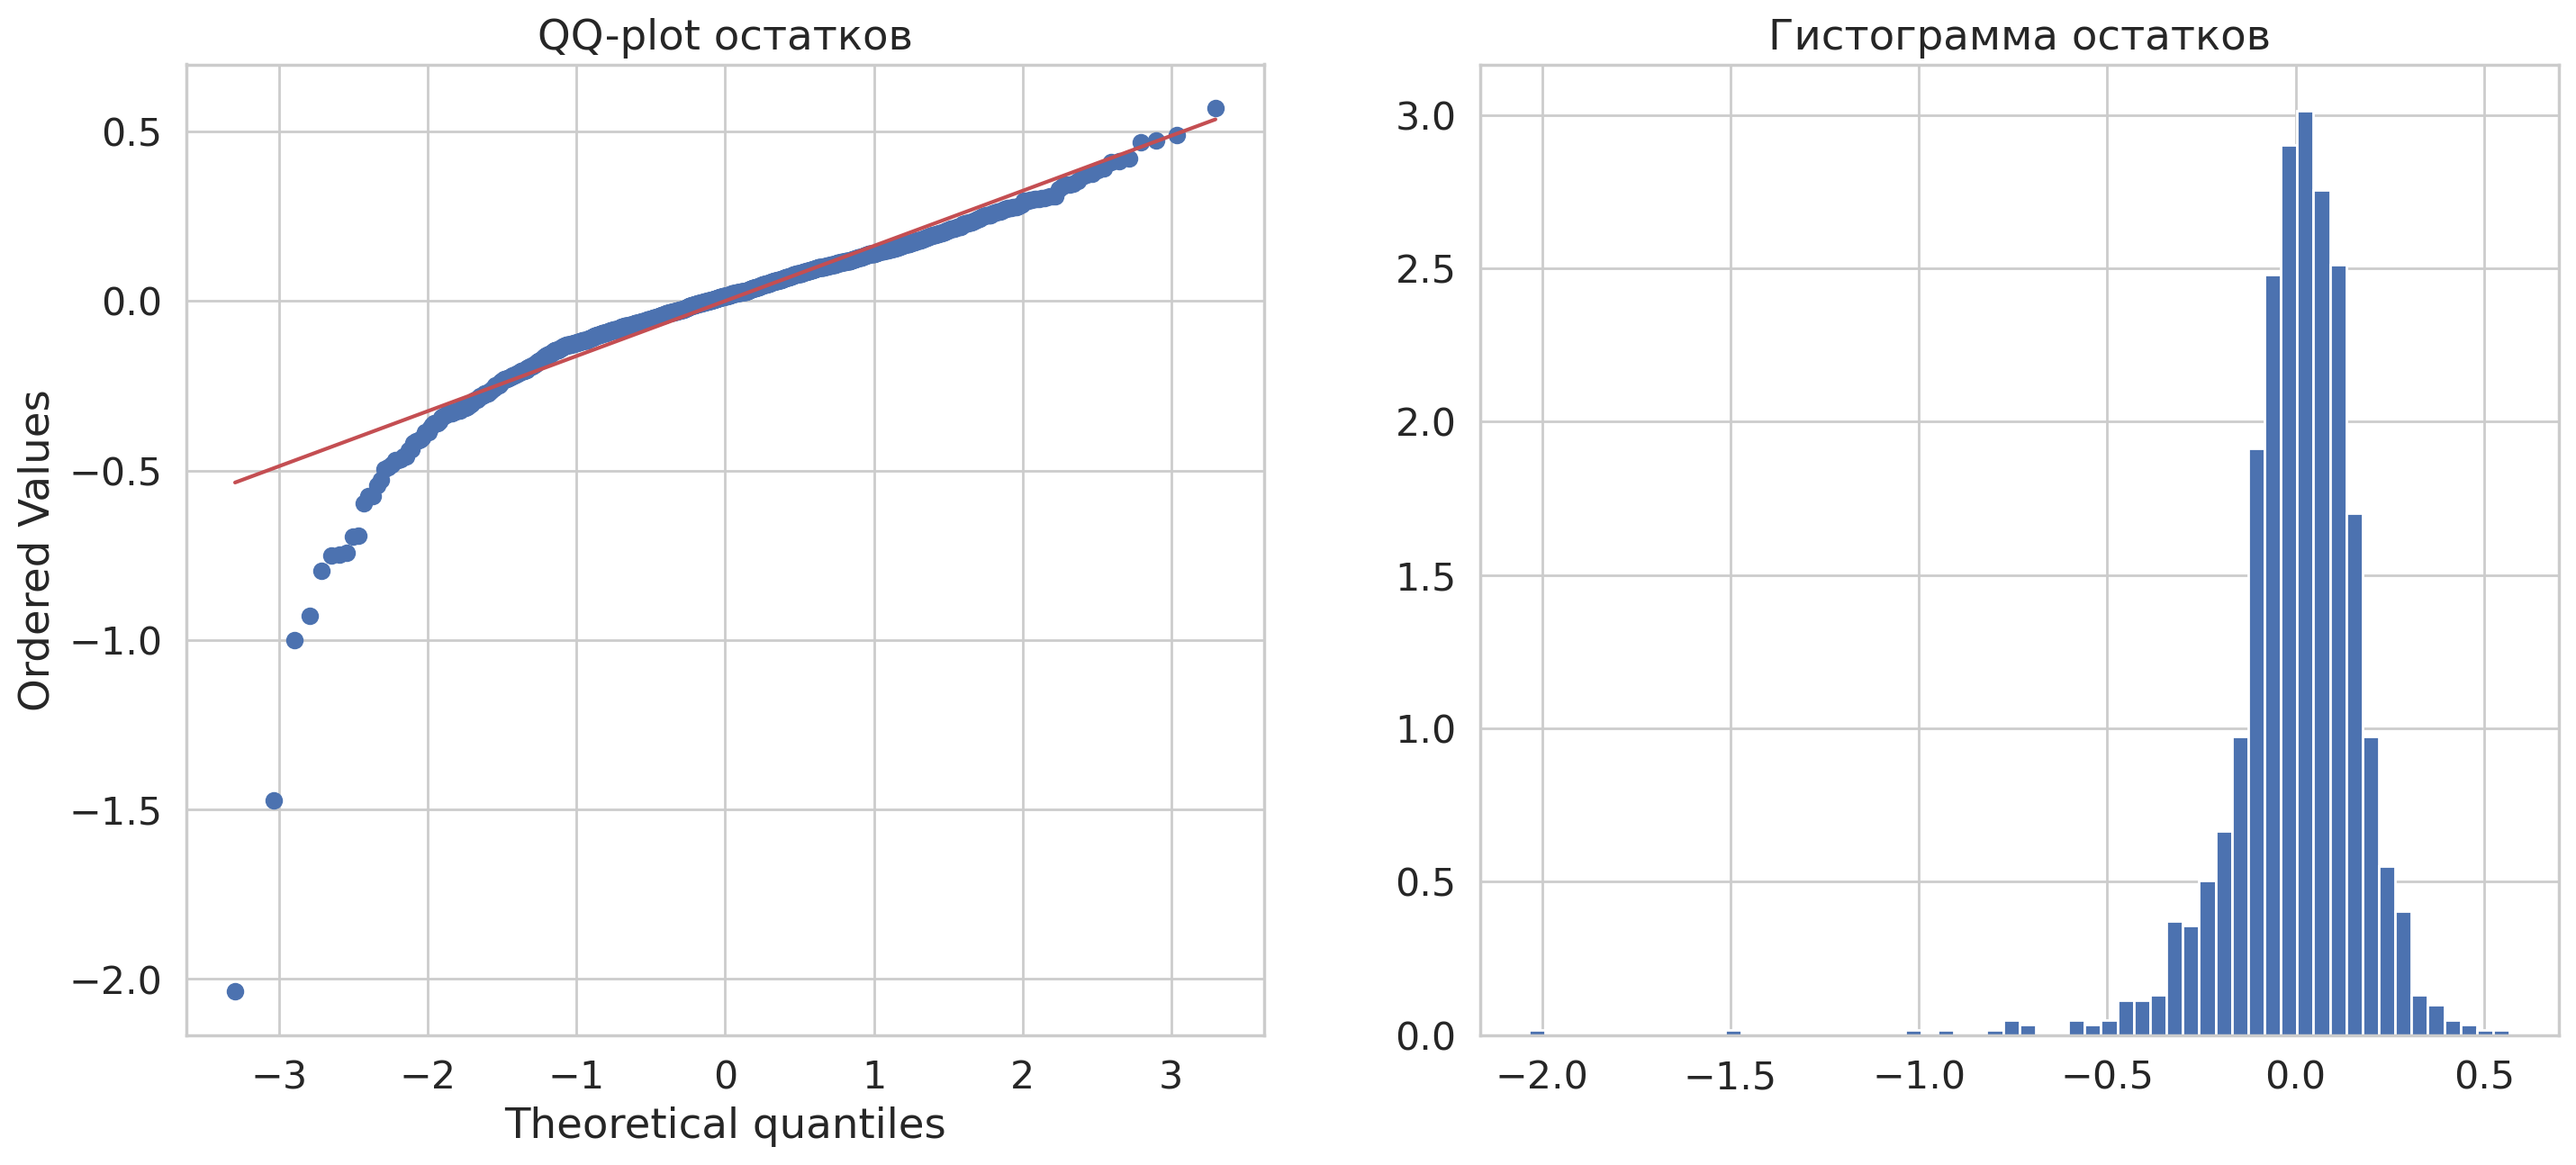

По мнению критерия Шапиро-Уилка нормальность распределения ошибок отвергается
p-value = 2.8876342675167496e-32


In [37]:
resid = fitted_simple_model.resid

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

sps.probplot(resid, dist="norm", plot=axes[0])
axes[0].set_title("QQ-plot остатков")
axes[1].hist(resid, bins=60, density=True)
axes[1].set_title("Гистограмма остатков")
plt.show()

pvalue = sps.shapiro(resid).pvalue
print("По мнению критерия Шапиро-Уилка нормальность распределения ошибок", "отвергается" if pvalue < ALPHA else "не отвергается")
print("p-value =", pvalue)

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:**

<font color="#ae69c9ff">

Результат здесь ожидаем, остатки всё ещё вообще не распределены нормально, у нас различия стали не линейными, т.е. в начале диапазона различия существенны, ближе к концу - уже нет. Отсюда и очень тяжелый хвост в начале рапсределения -> и отсутствие нормальности ошибок -> мы проиграли.

## Задача 4. Отбор признаков

*Данная задача стоит 10 баллов.*

**Дисклеймер:** задача будет засчитана, если задача 3 этого задания сделана до пункта "Гетеросгедантичность ошибки" включительно!

В прошлой задаче мы строили линейные модели на основании признаков, выбранных по текстовому описанию. Конечно, так делать не очень хорошо, а к выбору признаков нужно подойти с умом. В этом задании мы проведём исследование о том, какие признаки оказываются более или менее информативными. Для построения регрессионных моделей можно пользоваться библиотекой statsmodels.

1.  Добавьте ещё 5 осмысленных признаков в модель. В каждом пункте мы будем очередным способом выбирать 5 и 10 лучших признаков.

2. Используя критерий Стьюдента проверьте гипотезу о бесполезности для каждого признака (для этого надо запустить модель один раз, а не 15 раз). Если вдруг эта гипотеза не отвергается, удалите признак и замените его другим. Обратите внимание, что если таких признаков 2, то, чтобы удалить их вместе, нужно либо применить критерий Фишера, либо после удаления первого признака применить снова критерий Стьюдента. Ответьте на вопрос "зачем"?

2. Самым простым показателем качества модели является $R^2$. Из summary возьмите $R^2$ для всей модели и для каждого признака изучите, как он меняется для модели без этого признака. Пожалуйста, не выводите на экран 15 таблиц.

Как изменяется $R^2$? Что известно теоретически о том, как он должен вести себя при удалении признака? Отсортируйте признаки по "вкладу" в $R^2$. Сделайте вывод о том, насколько разумным получился отбор.

3. Для "честного" сравнения моделей с разным числом признаков коэффициент $R^2$ корректируют. Сравните скорректированный $R^2$ для модели с всеми признаками и 15ти моделей без одного признака. Какие модели оказались лучше? Отсортируйте снова признаки по важности и сделайте вывод.

4. *Информационный подход к отбору признаков*. Для 1+15 моделей из пункта выше рассчитайте коэффициенты AIC и BIC. Сравните модели по ним и отсортируйте признаки по важности. Одинаковый ли порядок? Чему больше доверия: $R^2$ с поправкой или информационным коэффициентам?

5. *Оптимизационный подход к отбору признаков*. В пакете sklearn найдите lasso-регрессию и реализуйте её с 5 разными коэффициентами регуляризации, так чтобы в каждом случае обнулились коэффициенты у разного числа признаков. Те признаки, который обнуляются раньше мы будем считать более бесполезными, так как модель жертвует ими в первую очередь. Отсортируйте признаки согласно важности в терминах лассо-регрессии и сравните порядок с предыдущими.

6. Бонусный пункт (+5 баллов). *Теоретико-игровой подход к отбору признаков*. Посмотрите лекцию, сходите на семинар по теории игр или любым другим способом узнайте о том, что такое вектор Шепли. Отберите от 5 до 15 (в зависимости от мощности Вашего ПК) признаков-кандидатов и разыграйте между ними игру: для каждого подмножества признаков обучите модель и посмотрите как много $R^2$ (или любого другого коэффициента) они зарабатывают. Согласно вектору Шепли разделите "награду" $R^2$ модели из всех признаков по каждому признаку. Отсортируйте признаки согласно их "заработку" и сравните порядок с предыдущими.

Предложите итоговый порядок признаков по важности, 5 и 10 самых важных признаков. Какому методу Вы доверились? Подумайте о том, как лучше поступить в случае мультикорреляции (наличии зависимости между признаками): регуляризовать или отобрать независимое подмножество фичей?

**Вывод:**

## Задача 5. Дисперсионный анализ

*Данная задача стоит 10 баллов.*

На практике часто возникает необходимость сравнить средние значения в трёх и более группах. Наивный подход, заключающийся в попарном применении t-критерия, приводит к проблеме множественной проверки гипотез и увеличению доли ошибки I рода. Корректным методом для такой задачи является дисперсионный анализ (ANOVA) (ANalysis Of VAriance).

[comment]: <> (Поздравляю, ты нашёл пасхалку! Сообщи об этом в чат 4-ого практикума. Первому сообщившему до дедлайна полагается вкусная шоколадка.)


Основная идея ANOVA заключается в сравнении разницы данных между группами с разницой внутри групп. Если разница между группами значительно превышает разницу внутри них, мы заключаем, что средние значения в группах различаются.

### 1. Классический однофакторный ANOVA

Пусть у нас есть $k$ независимых выборок (групп) $X_{11} \ldots X_{1 n_1}, X_{2, 1}, \ldots, X_{k, n_k}$. Формально, модель однофакторного ANOVA предполагает, что каждое наблюдение $X_{ij}$ ($j$-е наблюдение в $i$-й группе) можно представить в виде:
$$
X_{ij} = \mu + \alpha_i + \varepsilon_{ij}
$$
где:
-   $\mu$ - общее среднее для всех наблюдений.
-   $\alpha_i$ - эффект, связанный с принадлежностью к группе $i$.
-   $\varepsilon_{ij}$ - независимые ошибки (шум), распределённые как $\mathcal{N}(0, \sigma^2)$.

И есть такие допущения модели:
1.  Независимость ошибок $\varepsilon_{ij}$.
2.  Нормальность их распределения: $\varepsilon_{ij} \sim \mathcal{N}(0, \sigma^2)$.
3.  Гомоскедантичность: равенство дисперсий во всех группах ($\sigma_1 = \ldots = \sigma_k = \sigma$).


Нулевая гипотеза о равенстве средних во всех группах $$H_0 : \mu_1 = \mu_2 = \dots = \mu_k$$
в терминах этой модели эквивалентна гипотезе об отсутствии групповых эффектов: $$H_0 : \alpha_1 = \alpha_2 = \dots = \alpha_k = 0$$

Для проверки этой гипотезы общая изменчивость данных (SST) раскладывается на межгрупповую (SSB) и внутригрупповую (SSW):
$$
\underbrace{\sum_{i=1}^{k} \sum_{j=1}^{n_i} (X_{ij} - \overline{\overline{X}})^2}_{\mathrm{SST} \text{ (Total Sum of Squares)}} = \underbrace{\sum_{i=1}^{k} n_i (\overline{X}_i - \overline{\overline{X}})^2}_{\mathrm{SSB} \text{ (Sum of Squares Between)}} + \underbrace{\sum_{i=1}^{k} \sum_{j=1}^{n_i} (X_{ij} - \overline{X}_i)^2}_{\mathrm{SSW} \text{ (Sum of Squares Within)}}
$$
Далее вычисляются такие штуки:
$$
\mathrm{MSB} = \frac{\mathrm{SSB}}{k-1}, \quad \mathrm{MSW} = \frac{\mathrm{SSW}}{N-k}
$$
где $N = \sum_{i=1}^k n_i$.

Их отношение даёт F-статистику, которая при верности $H_0$ имеет распределение Фишера:
$$
F = \frac{\mathrm{MSB}}{\mathrm{MSW}} \sim F_{k-1, N-k}
$$


<font color="#ae69c9ff">

О, нам это Карлос Буитраго рассказывал на семинарах

Проверим корректность классического ANOVA. Сгенерируйте 10000 наборов из 4-х нормальных выборок, находясь в рамках нулевой гипотезы (все $\alpha_i = 0$, например, все выборки из $\mathcal{N}(0, 1)$). Размеры выборок возьмите равными 30.

In [38]:
X, Y, Z, W = [sps.norm(7, 4).rvs((10000, 30)) for _ in range(4)]

Для всех наборов данных посчитайте p-value с помощью готовой реализации, например, [`scipy.stats.f_oneway`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html).

In [39]:
p_values = np.array([sps.f_oneway(X[i], Y[i], Z[i], W[i]).pvalue for i in range(10000)])

Визуализируйте распределение полученных p-value. Оцените вероятность ошибки I рода для уровня значимости $\alpha=0.05$ и постройте для неё 95%-й доверительный интервал. Сделайте вывод о корректности критерия в данных условиях.

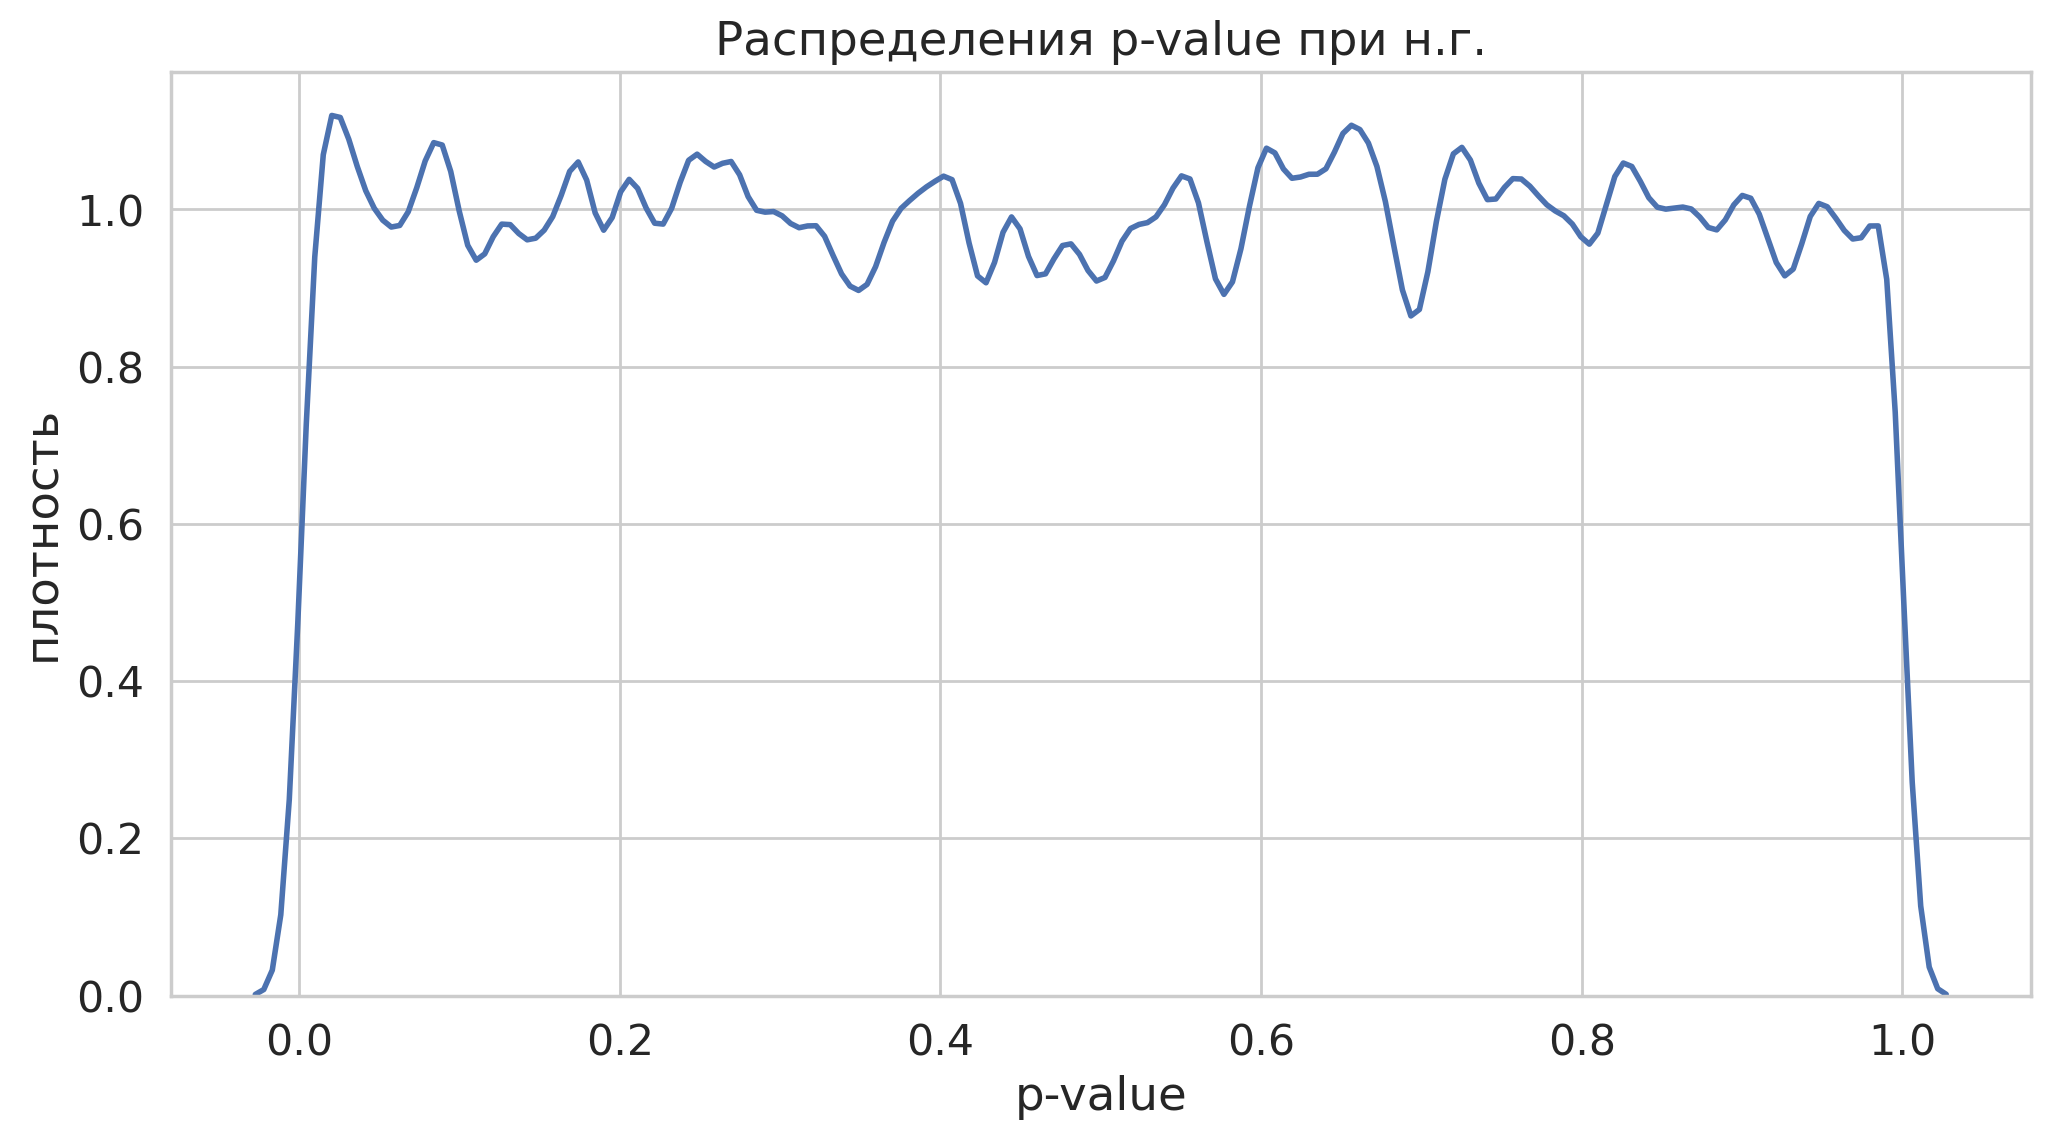

In [40]:
plt.figure(figsize=(12,6))
sns.kdeplot(p_values, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

**Вывод:**

<font color="#ae69c9ff">

Ну норм, рабоает. Получили равномерное распределение `p-value`, на основе чего хотим сказать, что ANOVA-критерий корректен



### 2. А что если допущения нарушаются

Классический ANOVA требует выполнения ряда строгих условий. Проверим, что происходит, когда они нарушаются, и рассмотрим альтернативы.


**A. Нарушение нормальности**

Когда допущение о нормальности нарушено, особенно для малых выборок, используют непараметрический аналог - критерий Краскела-Уоллиса. По сути это некоторая "ANOVA на рангах", поскольку его идея заключается в применении логики дисперсионного анализа не к исходным данным, а к их рангам.

В наиболее общем виде критерий Краскела-Уоллиса проверяет нулевую гипотезу о том, что все $k$ выборок взяты из одного и того же распределения. Если обозначить через $F_i(x)$ функцию распределения (CDF) для $i$-й группы, то гипотезу можно записать так:
$$
H_0: F_1(x) = F_2(x) = \dots = F_k(x)
$$

Если мы предполагаем, что формы и масштабы (дисперсии) распределений для всех групп одинаковы, они могут отличаться только сдвигом. В этом случае модель для данных можно записать как:
$$
F_i(x) = F(x - m_i)
$$
где $F$ — функция распределения общей формы, а $m_i$ — медиана (или любой другой параметр сдвига) для $i$-й группы. При таком допущении общая нулевая гипотеза $H_0: F_1 = \ldots = F_k$ становится эквивалентна более простой и понятной гипотезе о равенстве медиан:
$$
H_0: m_1 = m_2 = \dots = m_k
$$

**Непосредственно критерий**

Процедура такова:
1.  Все наблюдения из всех $k$ групп объединяются в один ряд.
2.  Этому объединённому ряду присваиваются ранги от 1 до $N$ (где $N$ — общее число наблюдений).
3.  Затем вычисляется статистика, которая, по сути, повторяет идею F-статистики ANOVA.

Вспомним, что F-статистика сравнивает межгрупповую дисперсию с внутригрупповой. Аналогично, статистика Краскела-Уоллиса $H$ основана на межгрупповой сумме квадратов отклонений для рангов ($SSB_R$). Если обозначить $R_{ij}$ как ранг наблюдения $X_{ij}$ в общей выборке, $\bar{R}_i$ как средний ранг в группе $i$, а $\overline{\overline{R}} = (N+1)/2$ как общий средний ранг, то:
$$
SSB_R = \sum_{i=1}^k n_i (\bar{R}_i - \overline{\overline{R}})^2
$$
Общая сумма квадратов для рангов ($SST_R$) является фиксированной величиной для заданного $N$:
$$
SST_R = \sum_{i=1}^k \sum_{j=1}^{n_i} (R_{ij} - \overline{\overline{R}})^2 = \frac{N(N^2-1)}{12}
$$
Тогда статистика $H$ определяется как отношение межгрупповой изменчивости рангов к общей, нормированное на $(N-1)$:
$$
H = (N-1)\frac{SSB_R}{SST_R}
$$
После алгебраических преобразований эта формула приводится к более известному и удобному для вычислений виду, использующему суммы рангов в группах ($R_i = \sum_{j=1}^{n_i} R_{ij}$):
$$
H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
$$
При верности нулевой гипотезы статистика $H$ асимптотически имеет распределение $\chi^2_{k-1}$

Сгенерируйте выборки (4 группы по 30 наблюдений) из следующих распределений, не забыв их отнормировать так, чтобы теоретические средние и дисперсии были одинаковы:
*   Все выборки из распределения Лапласа.
*   Все выборки из распределения Стьюдента $T_3$.
*   Две выборки из $\mathcal{N}(0, 1)$, одна из $\mathrm{Beta}(5, 1)$, одна из $\mathrm{U}[-1, 1]$.

Для каждого случая примените и классический ANOVA, и критерий Краскела-Уоллиса ([`scipy.stats.kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)). Визуализируйте распределения p-value и оцените ошибку I рода для обоих критериев. (Пометка, на самом деле ANOVA является довольно робастной относительно нарушения условия нормальности, поэтому вероятно получится, что с p-value будет ок, особенно для симметричных распределений)

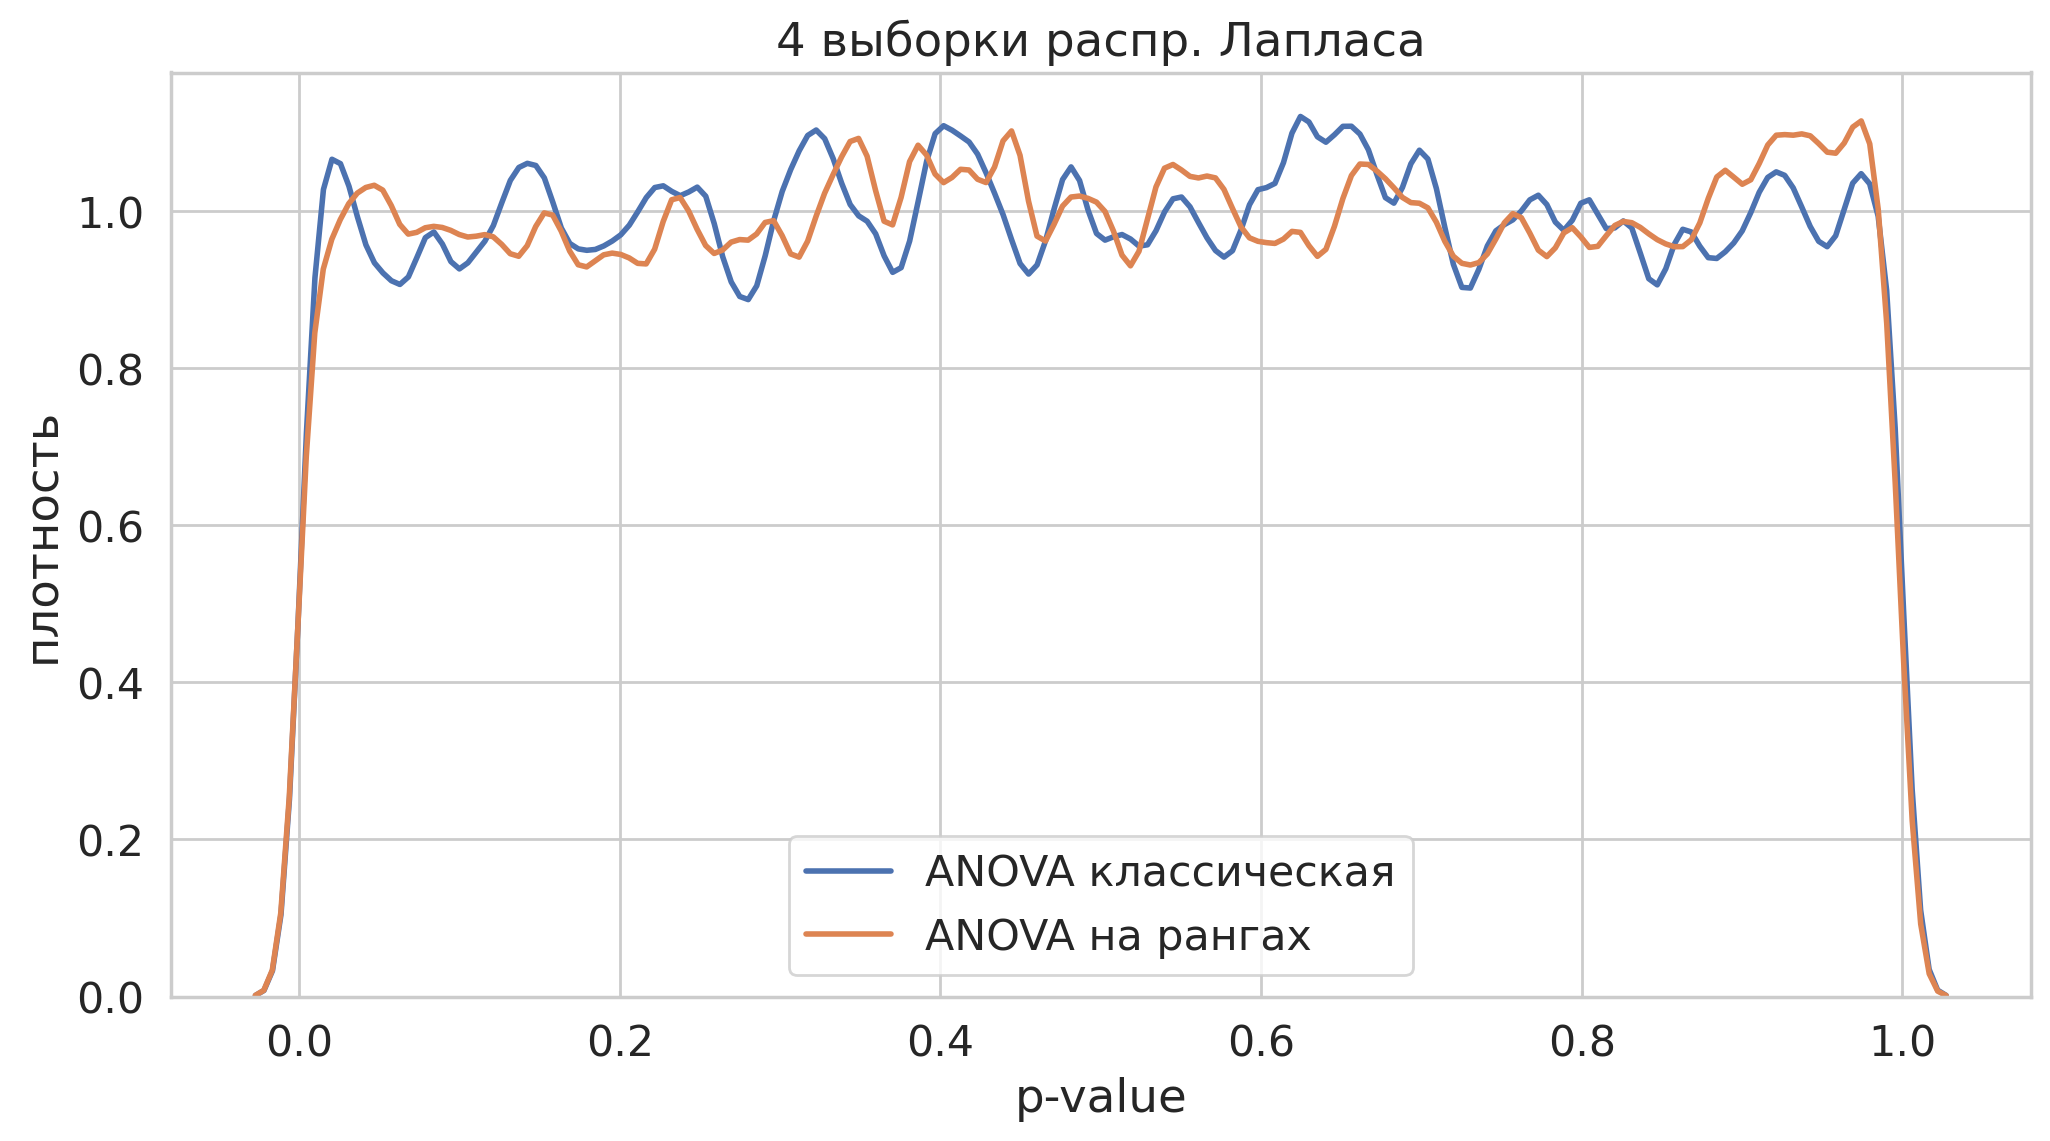

Вероятность ошибки первого рода для ANOVA классической 0.0511
Вероятность ошибки первого рода для ANOVA на рангах 0.05


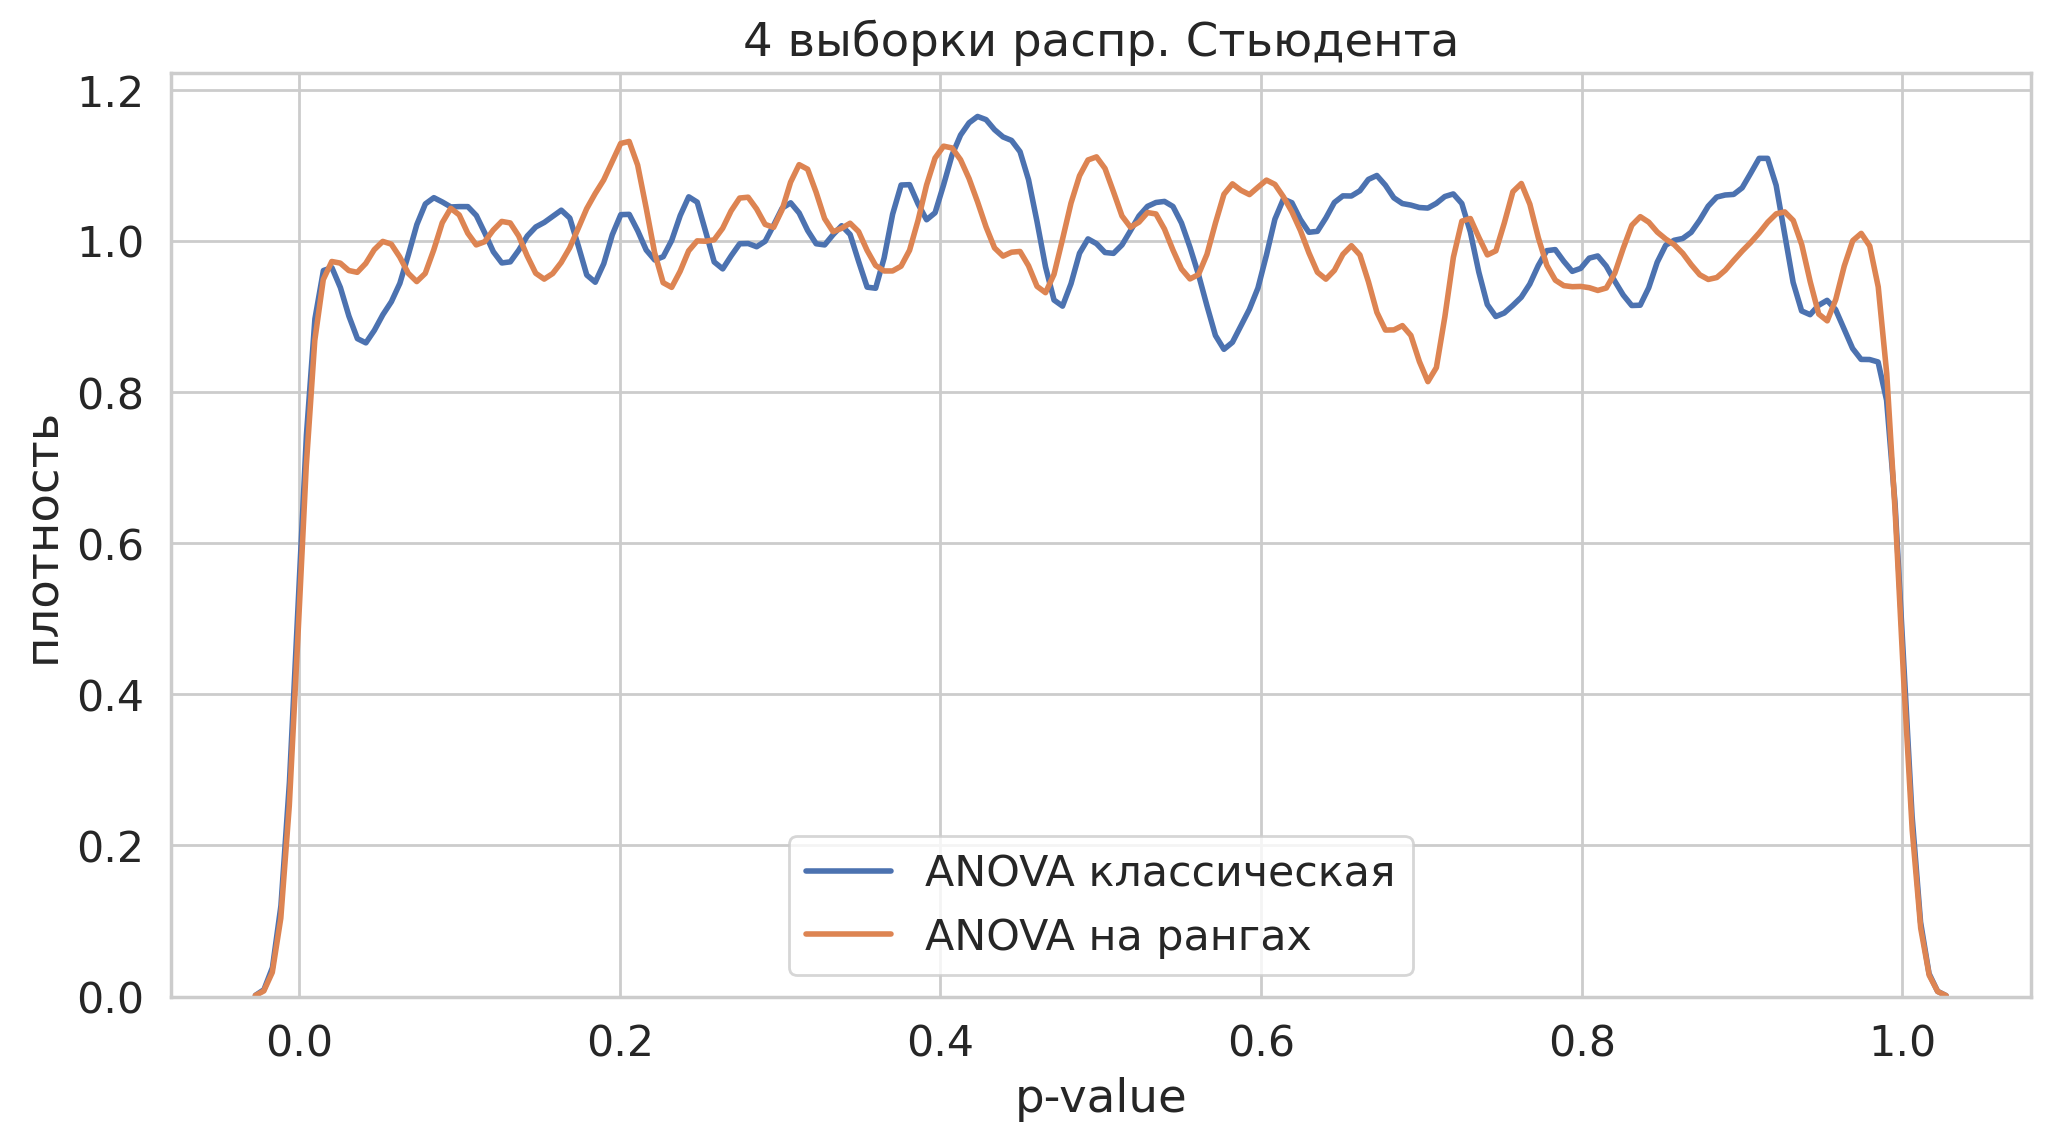

Вероятность ошибки первого рода для ANOVA классической 0.0476
Вероятность ошибки первого рода для ANOVA на рангах 0.0492


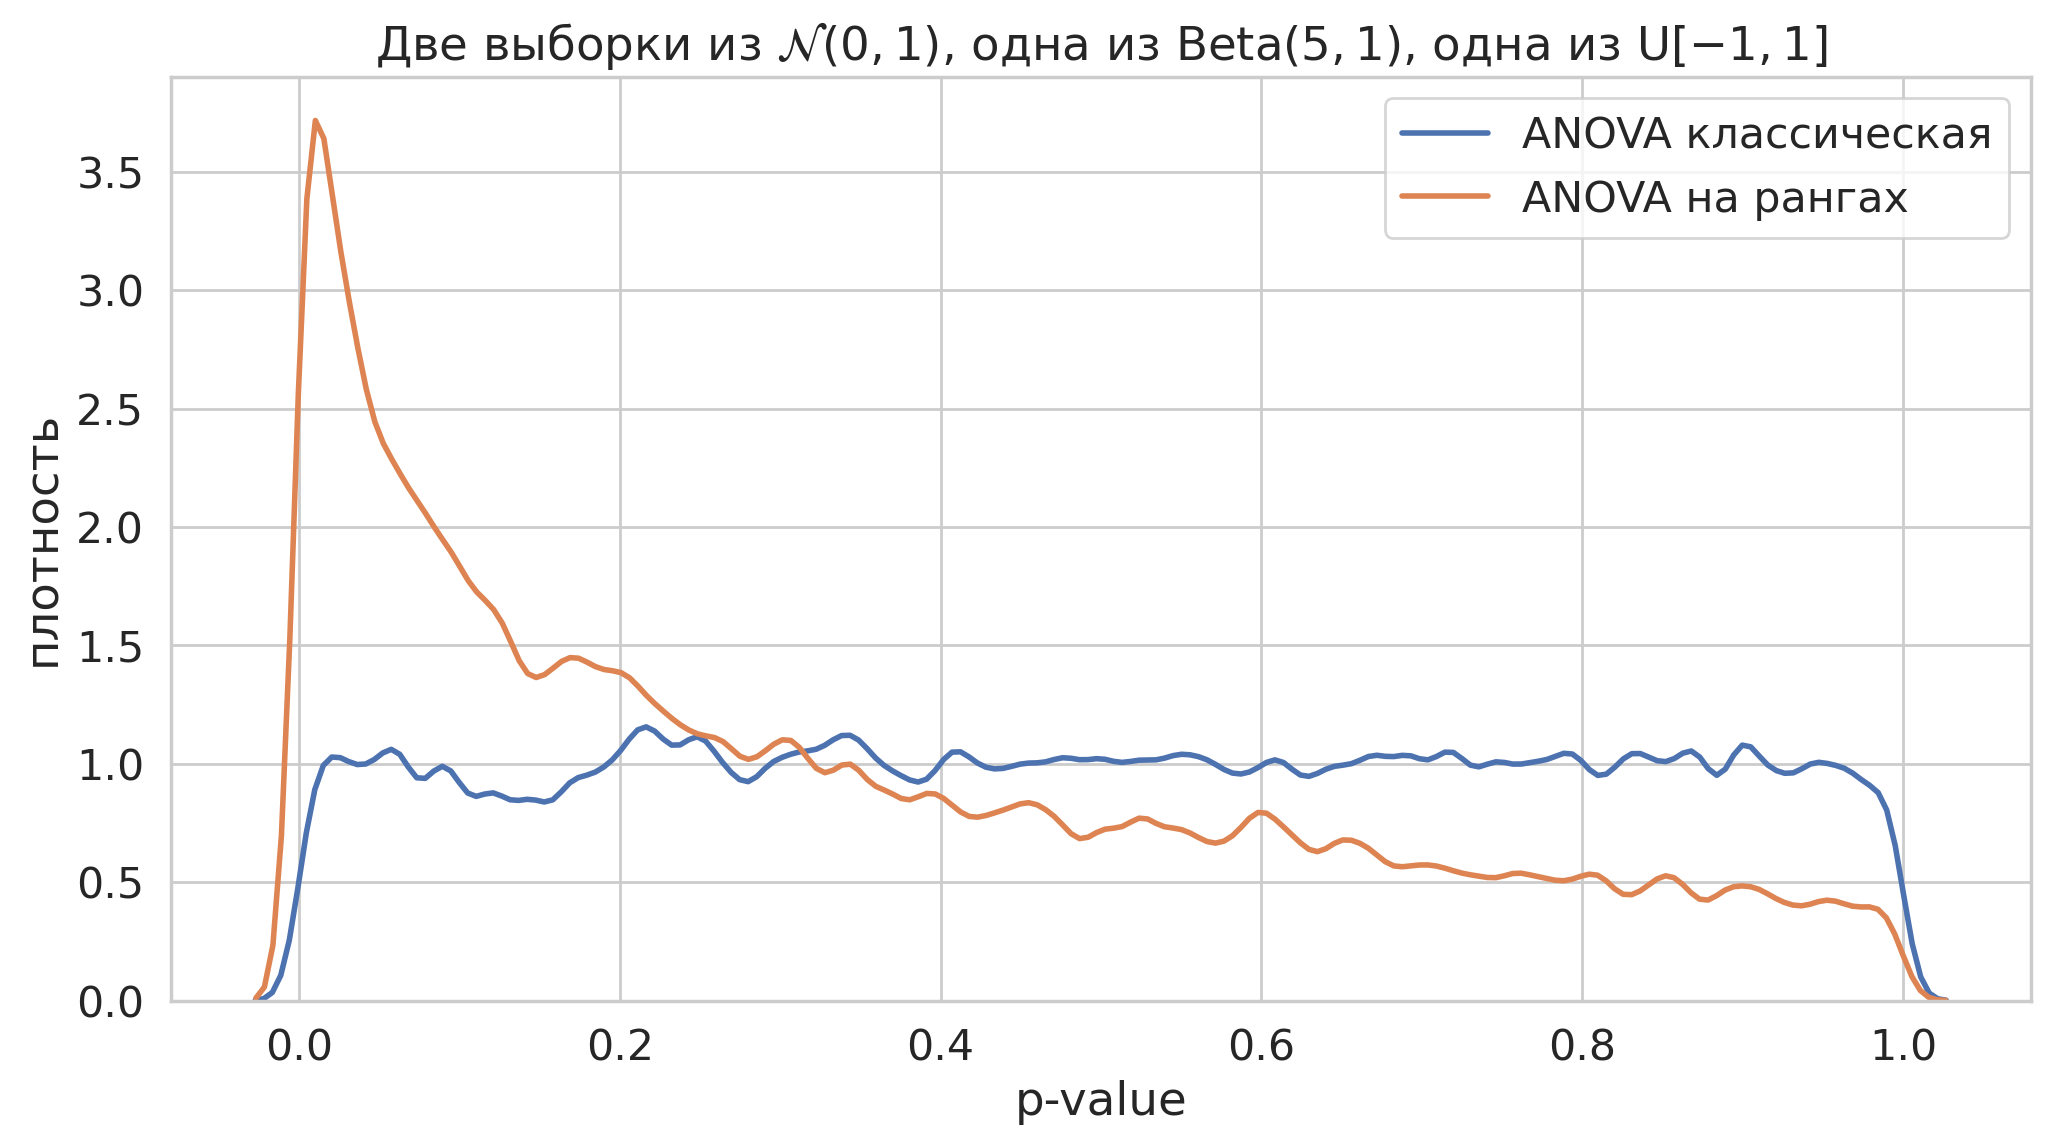

Вероятность ошибки первого рода для ANOVA классической 0.0504
Вероятность ошибки первого рода для ANOVA на рангах 0.1761


In [41]:
N = 10000
k = 300

def narisovat_grafic_onlayn_bez_sms_i_registracii_uluchshennaya_teper_ot_chetirex_viborok(A, B, C, D, name):
    p_values_classic = np.array([sps.f_oneway(A[i], B[i], C[i], D[i]).pvalue for i in range(N)])
    p_values_kruskal = np.array([sps.kruskal(A[i], B[i], C[i], D[i]).pvalue for i in range(N)])

    plt.figure(figsize=(12, 6))
    plt.title(name)
    sns.kdeplot(p_values_classic, lw=2, bw_adjust=0.2, label="ANOVA классическая")
    sns.kdeplot(p_values_kruskal, lw=2, bw_adjust=0.2, label="ANOVA на рангах")
    plt.title(name); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.legend(loc="best"); plt.grid(True)

    plt.show()

    print("Вероятность ошибки первого рода для ANOVA классической", np.mean(p_values_classic < ALPHA))
    print("Вероятность ошибки первого рода для ANOVA на рангах", np.mean(p_values_kruskal < ALPHA))


A, B, C, D = [sps.laplace(4, 7).rvs((N, k)) for _ in range(4)]
narisovat_grafic_onlayn_bez_sms_i_registracii_uluchshennaya_teper_ot_chetirex_viborok(A, B, C, D, "4 выборки распр. Лапласа")


A, B, C, D = [sps.t(3).rvs((N, k)) for _ in range(4)]
narisovat_grafic_onlayn_bez_sms_i_registracii_uluchshennaya_teper_ot_chetirex_viborok(A, B, C, D, "4 выборки распр. Стьюдента")


magic = lambda f: (f.rvs((N, k)) - f.mean()) / np.sqrt(f.var())
X = magic(sps.norm(0, 1))
Y = magic(sps.norm(0, 1))
Z = magic(sps.beta(5, 1))
W = magic(sps.uniform(0, 2))

narisovat_grafic_onlayn_bez_sms_i_registracii_uluchshennaya_teper_ot_chetirex_viborok(X, Y, Z, W, r"Две выборки из $\mathcal{N}(0, 1)$, одна из $\mathrm{Beta}(5, 1)$, одна из $\mathrm{U}[-1, 1]$")

Вывод:

<font color="#ae69c9ff">

Я не понимаю, зачем автор прака предложил работать с выборками по 30 элементов, на них ничего не видно. Сделал 300, всё, красота, второй критерий сломался

Ну, я понятия не имею, почему первый критерий настолько устойчив к отсутствию робастности, ну, классно)) Пусть будет. Он проверяет равенство матожей и пусть себе проверяет.\
Что по выторому? Он прикольнее: он смотрит уже на распределения, что вообще прикольно, и, делает это достаточно сильно. Здорово!

Ещё один момент: обсуждал с другом, он говорит, что здесь KDE не репрезентативно, а достаточно смотреть только на вероятность ошибки первого рода. У него на прогоне вышло, что на разных распределениях результаты классической ANOVA дают большую дисперсию, но я не смог получить чего-то похожего у себя при различных N и k, а так же при большом количестве прогонов 

**Б. Нарушение гомоскедантичности**

Теперь сгенерируйте 4 группы (по 50 наблюдений) из нормальных распределений с равными средними, но разными дисперсиями: $\mathcal{N}(0, 1)$, $\mathcal{N}(0, 4)$, $\mathcal{N}(0, 9)$, $\mathcal{N}(0, 16)$. Примените к ним классический ANOVA и оцените ошибку I рода.

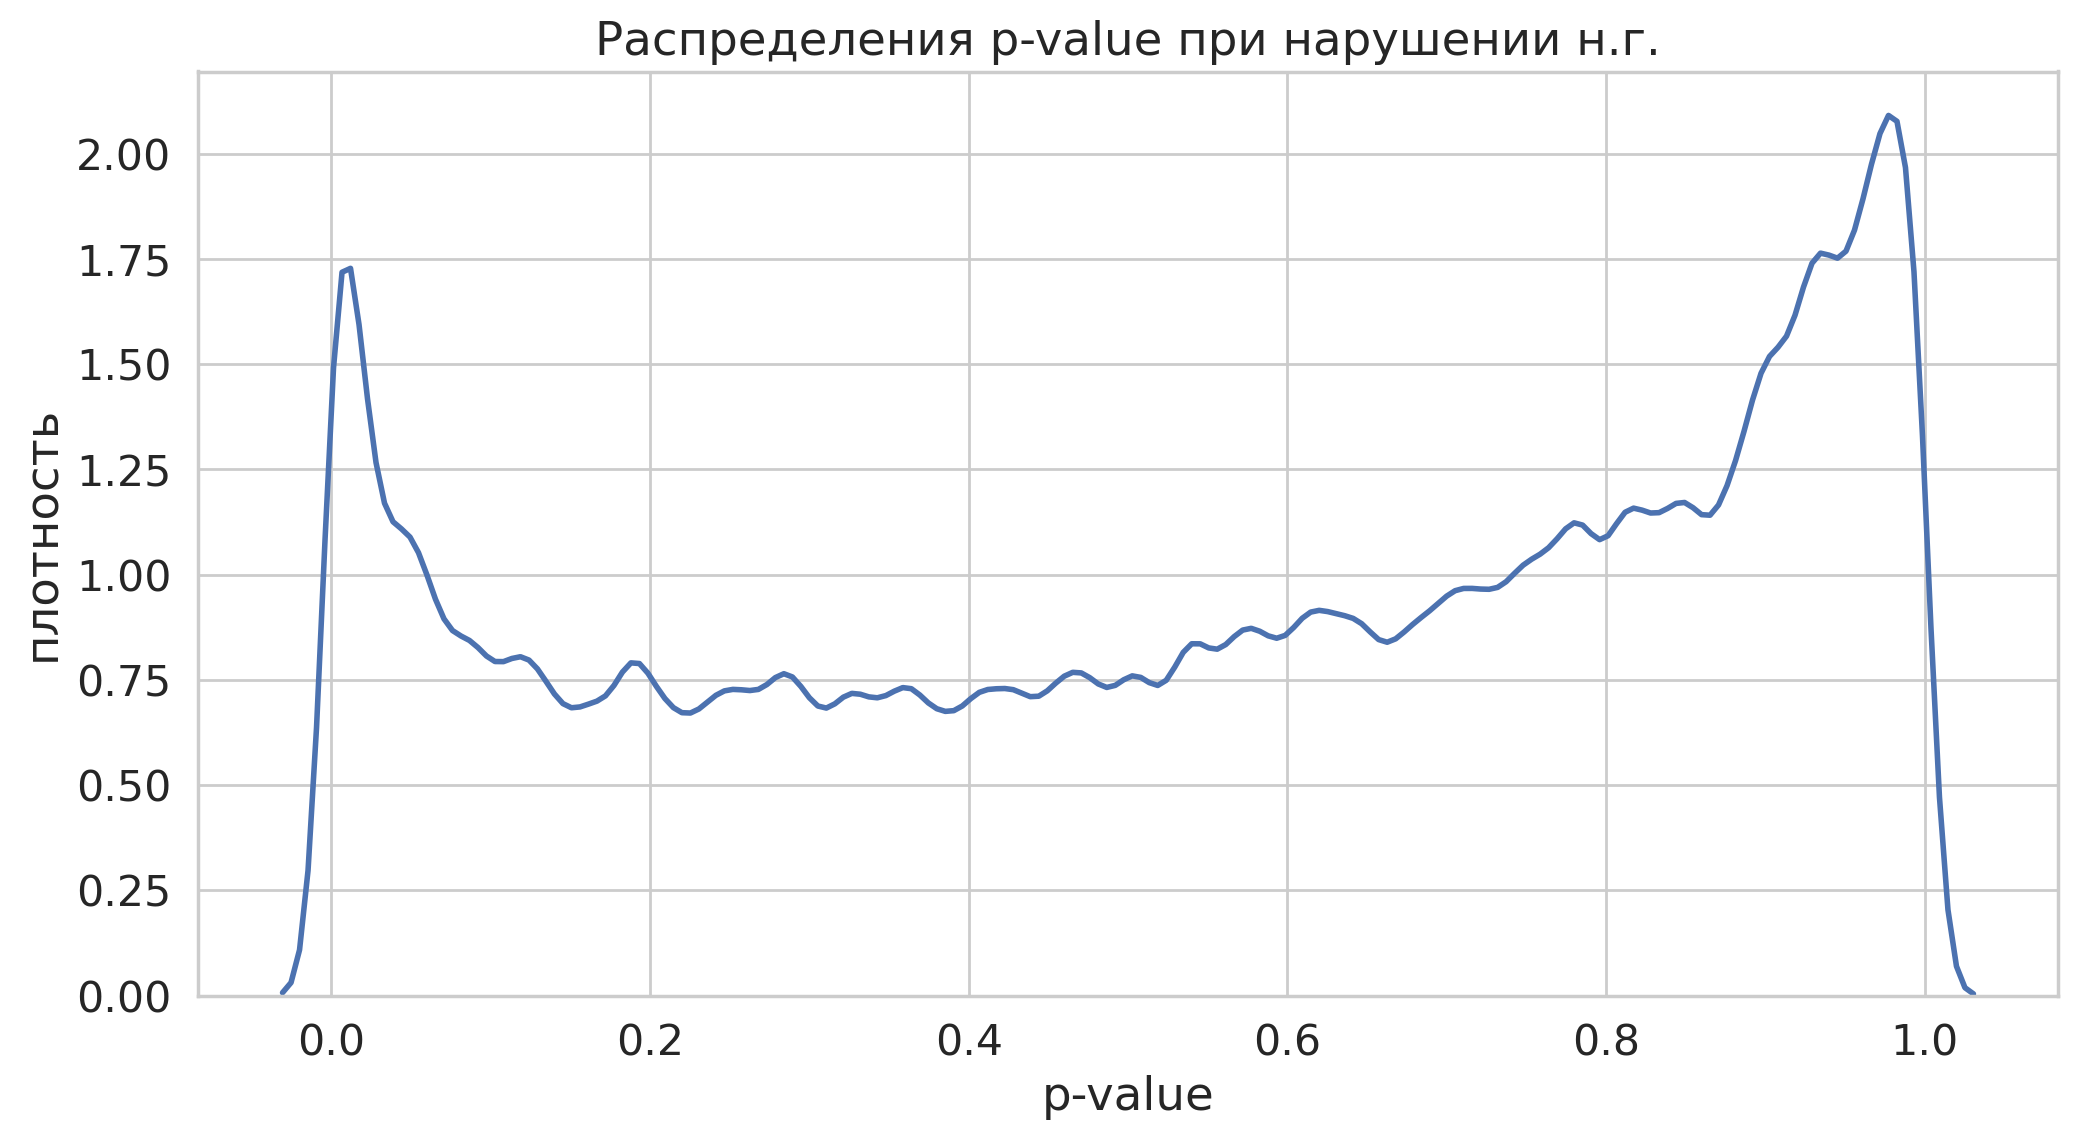

Ошибка первого рода - 0.0818


In [42]:
A = sps.norm(0, 1).rvs((10000, 50))
B = sps.norm(0, 4).rvs((10000, 50))
C = sps.norm(0, 9).rvs((10000, 50))
D = sps.norm(0, 16).rvs((10000, 50))

p_values_classic = np.array([sps.f_oneway(A[i], B[i], C[i], D[i]).pvalue for i in range(10000)])

plt.figure(figsize=(12,6))
sns.kdeplot(p_values_classic, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при нарушении н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

print("Ошибка первого рода -", np.mean(p_values_classic < ALPHA)) 

# Как будто бы так сделать неправильно, т.к. не верно предположение применения криетерия
# Типо... попросили посчитать ошибку первого рода, когда у нас нет верной H_0? А это как?
# Собственно, напоминает случай, когда я в Стьюдента Коши впихнул. Оно как бы не должно работать, но предельное распределение у p-value есть

Для случая гетероскедантичности существует ANOVA Уэлча. Его готовой реализации в `scipy.stats` нет, но он есть в `pingouin.welch_anova`.

Примените ANOVA Уэлча к данным с разными дисперсиями. Оцените ошибку I рода.

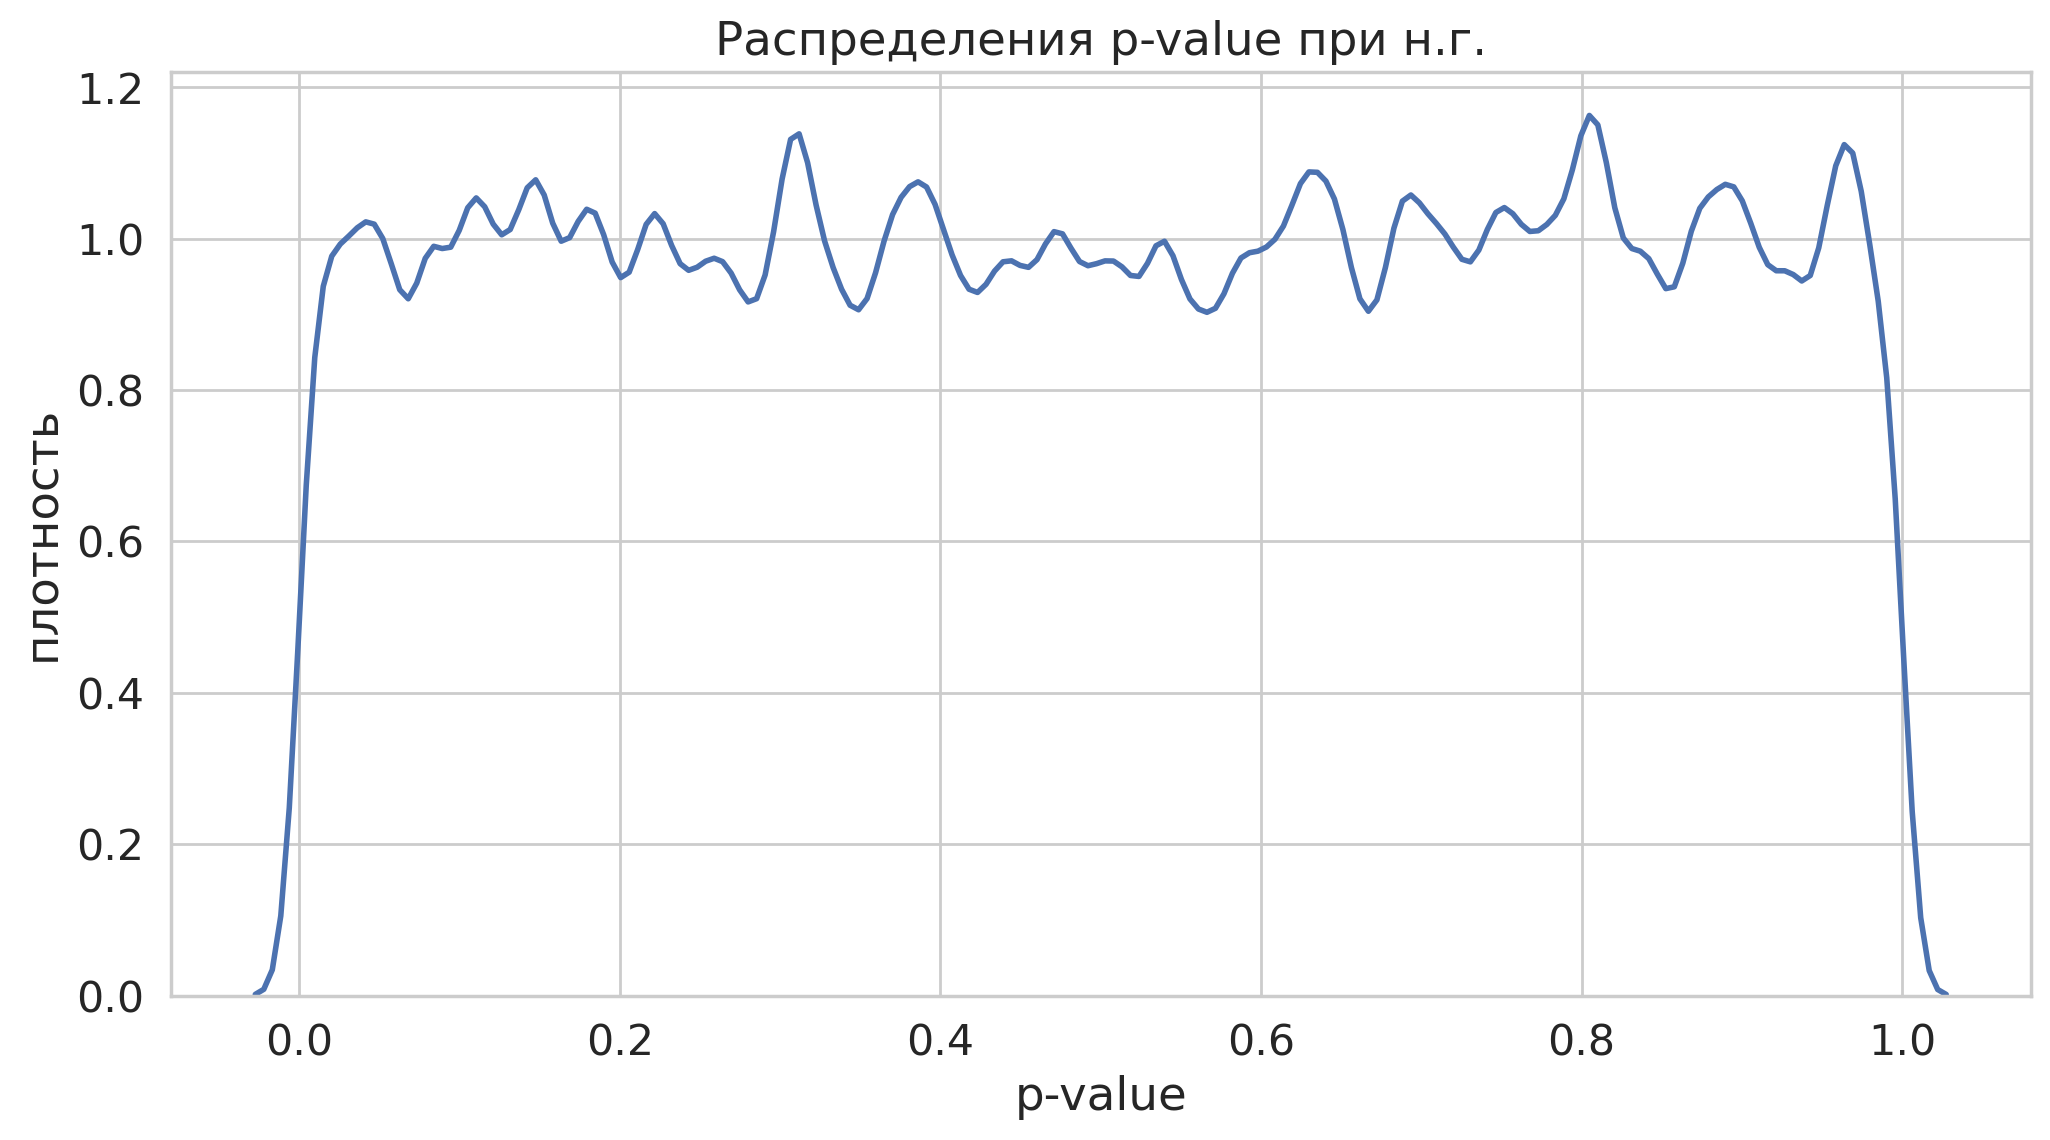

Ошибка первого рода - 0.0498


In [43]:
p_values_welch = np.array([sps.f_oneway(A[i], B[i], C[i], D[i], equal_var=False).pvalue for i in range(10000)])

plt.figure(figsize=(12,6))
sns.kdeplot(p_values_welch, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

print("Ошибка первого рода -", np.mean(p_values_welch < ALPHA)) # а вот тут уже да, вопросов нет

Вывод:

<font color="#ae69c9ff">

<!--
- Вы продаёте рыбов?        - Мы выводили сами критерии?
- Нет, показываю            - Нет, только применили
- Красивое...               - Красивое... -->

Ну... Да, оно работает. Про $H_0$ в первом подпункте я написал комментариями в коде, всё её не придумал, порчему это корректно, а так вообще прикольно: +1 очень сильный критерий


### 3. Бонусный пункт (+5 баллов) ANOVA для повторных измерений

В предыдущих пунктах мы исходили из допущения о независимости выборок. Однако во многих экспериментальных планах это условие нарушается намеренно. Классический пример — измерение некоторого показателя у одних и тех же испытуемых в нескольких разных условиях или в разное время (например, до, во время и после лечения). Такой дизайн называется дизайном с повторными измерениями.

Применение стандартного ANOVA к таким данным некорректно, из-за допущения о независимости наблюдений. Оценка одного и того же человека в разное время, очевидно, не является независимой: если у человека в принципе высокий уровень тревожности, его показатели, скорее всего, будут выше среднего во всех условиях. Эта систематическая изменчивость, связанная с индивидуальными различиями между испытуемыми, не является случайным шумом.

Приводит это всё к двум проблемам:
1. Знаменатель F-статистики становится завышенным.
2. Из-за большого знаменателя F-статистика становится меньше, и критерий реже обнаруживает реальные различия между условиями (ну или ещё можно сказать что он резко теряет мощность вплоть до бессмысленности применения).

Модель ANOVA для повторных измерений выглядит так:
$$
X_{ij} = \mu + \pi_j + \tau_i + \varepsilon_{ij}
$$
где:
*   $X_{ij}$ — наблюдение для $j$-го испытуемого ($j=1, \dots, n$) в $i$-м условии ($i=1, \dots, k$).
*   $\mu$ — общее среднее.
*   $\pi_j$ — случайный эффект, связанный с $j$-м испытуемым (его отклонение от общего среднего). Это и есть учет индивидуальных различий.
*   $\tau_i$ — фиксированный эффект, связанный с $i$-м условием (то, что мы хотим проверить).
*   $\varepsilon_{ij}$ — случайная ошибка (взаимодействие испытуемого и условия).

Также, разумеется, данные разных испытуемых должны быть независимы друг от друга (то есть зависимость мы допускаем только в рамках замера испытуемого $i$, $\forall i$)

Нулевая гипотеза заключается в отсутствии эффекта условия:

$$H_0: \tau_1 = \tau_2 = \dots = \tau_k = 0$$

F-статистика строится как отношение среднего квадрата для условия к среднему квадрату ошибки:
$$
F = \frac{SS_{\text{condition}} / (k-1)}{SS_{\text{error}} / ((n-1)(k-1))}
$$
Обратите внимание, что в знаменателе теперь стоит не общая внутригрупповая дисперсия. Полностью разложение дисперсии выглядит так:

$$
SS_{\text{total}} = \sum_{i=1}^{k} \sum_{j=1}^{n} (X_{ij} - \bar{X}_{..})^2
$$

$$
SS_{\text{subjects}} = k \sum_{j=1}^{n} (\bar{X}_{.j} - \bar{X}_{..})^2
$$

$$
SS_{\text{condition}} = n \sum_{i=1}^{k} (\bar{X}_{i.} - \bar{X}_{..})^2
$$

$$
SS_{\text{error}} = SS_{\text{total}} - SS_{\text{subjects}} - SS_{\text{condition}}
$$

**Допущение о сферичности**

Помимо нормальности, rANOVA имеет важное дополнительное допущение - сферичность. Оно означает, что дисперсии разностей между всеми возможными парами условий должны быть примерно одинаковы. Нарушение этого допущения (что случается довольно часто) завышает вероятность ошибки I рода. Для борьбы с этим применяют поправки (например, Гринхауса-Гейссера), которые корректируют степени свободы.

При верности нулевой гипотезы и выполнении допущений (включая сферичность), эта статистика имеет распределение Фишера $F_{k-1, (n-1)(k-1)}$





**А что если опять нет нормальности**

Тогда используется критерий Фридмана. По сути он является некоторым развитием критерия Краскела-Уоллиса для зависимых выборок.

1.  Для каждого испытуемого отдельно его наблюдения в разных условиях ранжируются (например, от 1 до $k$).
2.  Далее вычисляются суммы рангов для каждого условия.

Статистика Фридмана вычисляется по формуле:
$$
F_r = \left[ \frac{12}{nk(k+1)} \sum_{i=1}^{k} R_i^2 \right] - 3n(k+1)
$$
где $n$ — число испытуемых (блоков), $k$ — число условий, а $R_i$ — сумма рангов для $i$-го условия по всем испытуемым.

При верности $H_0$ и достаточно большом числе испытуемых ($n$), статистика Фридмана $F_r$ асимптотически имеет распределение $\chi^2_{k-1}$

Смоделируем эксперимент. Пусть у нас есть 50 испытуемых. Для каждого испытуемого сгенерируем его "базовый" уровень эффекта $b_j \sim \mathcal{N}(0, 5^2)$. Затем измерим показатель для каждого испытуемого в трёх условиях. При верности $H_0$, эффект условия равен нулю. Таким образом, измерения будут:
$X_{1j} = b_j + \varepsilon_{1j}$, $X_{2j} = b_j + \varepsilon_{2j}$, $X_{3j} = b_j + \varepsilon_{3j}$, где $\varepsilon_{ij} \sim \mathcal{N}(0, 1)$ — случайный шум.

Сгенерируйте такие данные 10000 раз.

In [44]:
N = 10000
k = 50

b = sps.norm(0, 5).rvs((N, k))
X = sps.norm(0, 1).rvs((N, k, 3)) + b[..., None]

Примените к этим данным сначала обычный однофакторный ANOVA. Визуализируйте p-value и оцените ошибку I рода. Объясните результат.

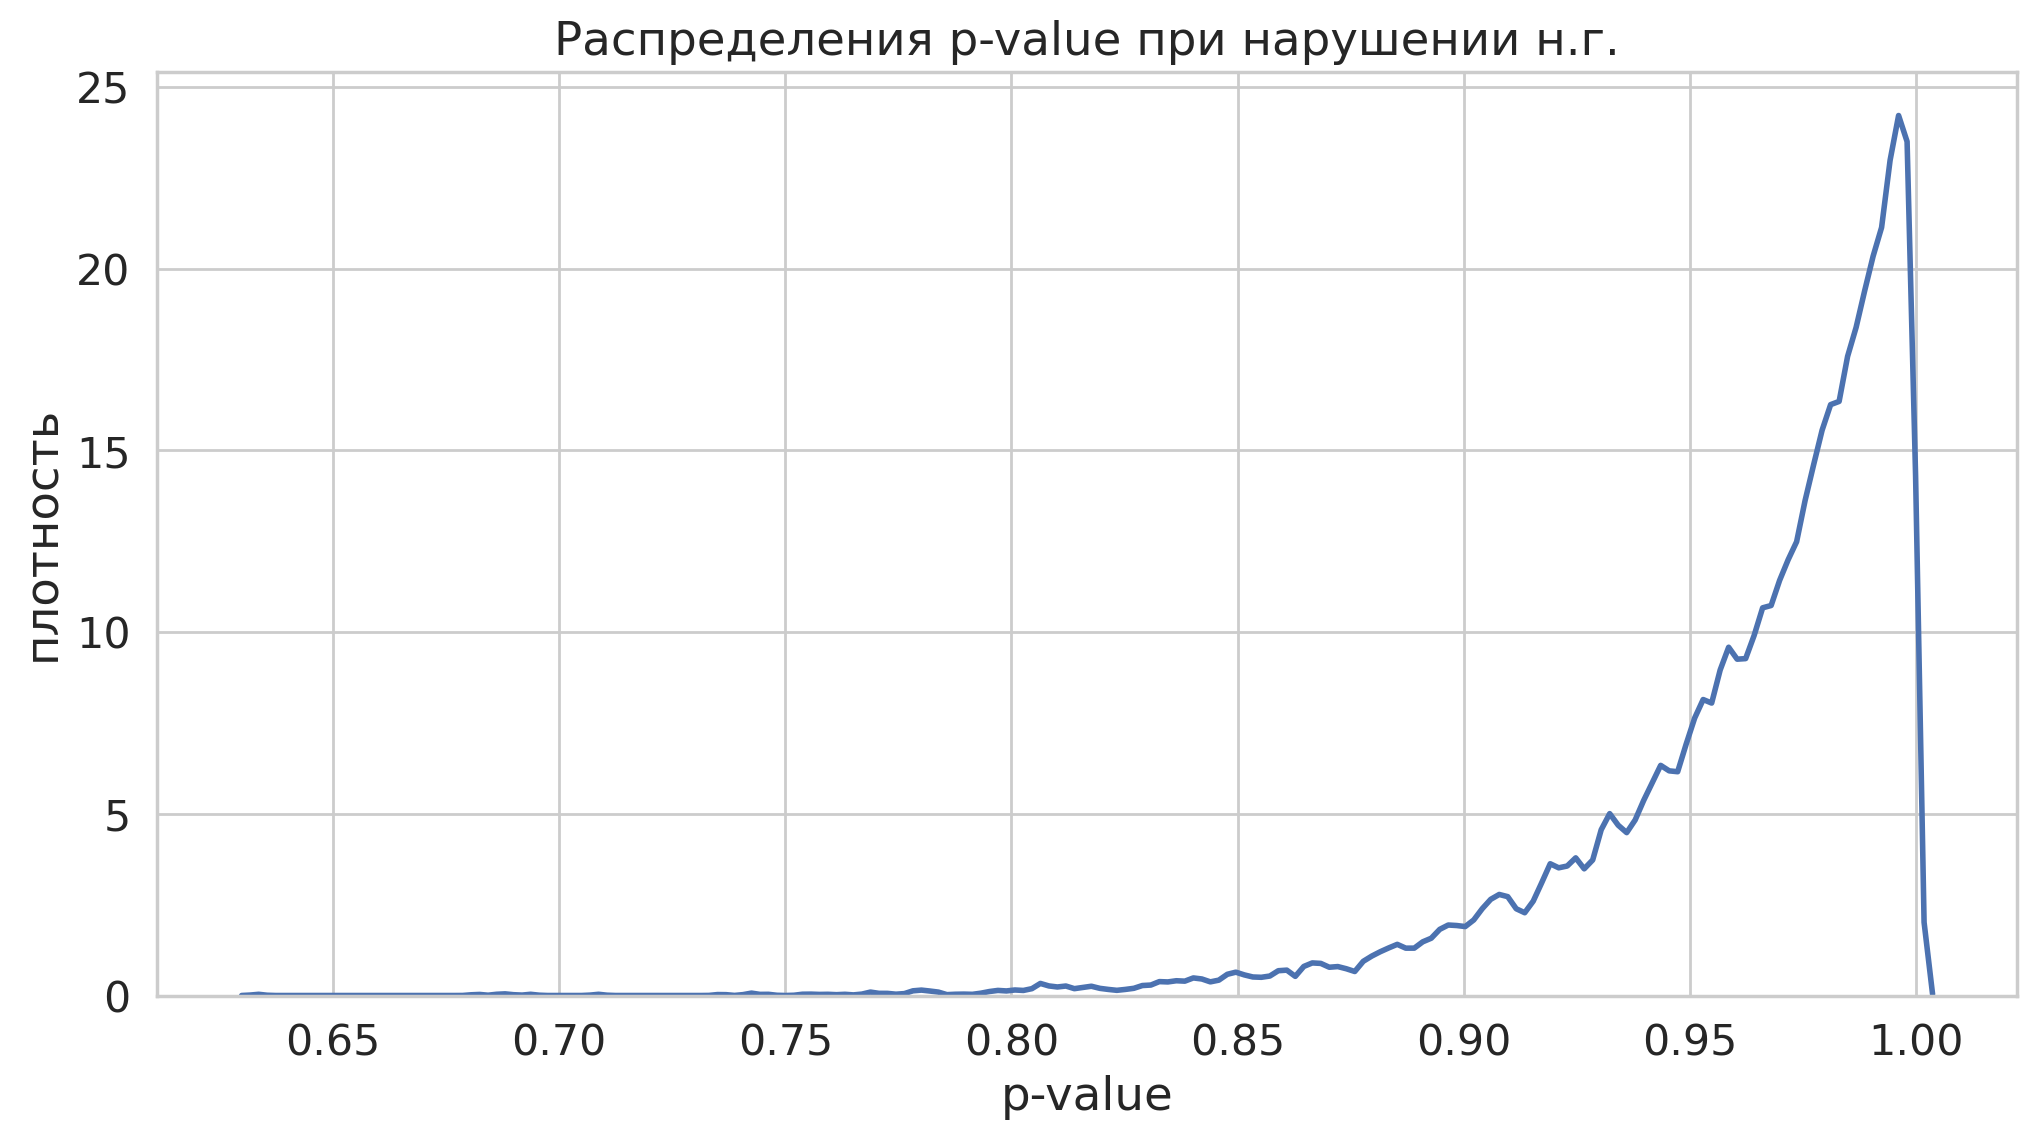

Ошибка первого рода - 0.0


In [45]:
p_values_classic = np.array([sps.f_oneway(X[i, :, 0], X[i, :, 1], X[i, :, 2]).pvalue for i in range(N)])

plt.figure(figsize=(12,6))
sns.kdeplot(p_values_classic, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при нарушении н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

print("Ошибка первого рода -", np.mean(p_values_classic < ALPHA)) 

<font color="#ae69c9ff">

Как и писал ранее автор задания, т.к. классический критерий предполагает более сильные условия, дисперсии при подсчёте начинают взрываться и мы получаем вовсе не равномерное распределение. Собственно, да, при очень высоких дисперсиях вероятность получить более экстримальную выборку при равенство $H_0$ расёт, что мы и видим

Теперь применим корректный параметрический метод. Используйте [`statsmodels.stats.anova.AnovaRM`](https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.AnovaRM.html). Для его использования данные необходимо представить в "длинном" формате с помощью `pandas.DataFrame`, указав колонки для идентификатора испытуемого, внутрисубъектного фактора (условия) и измеряемого значения. Оцените ошибку I рода для этого критерия.

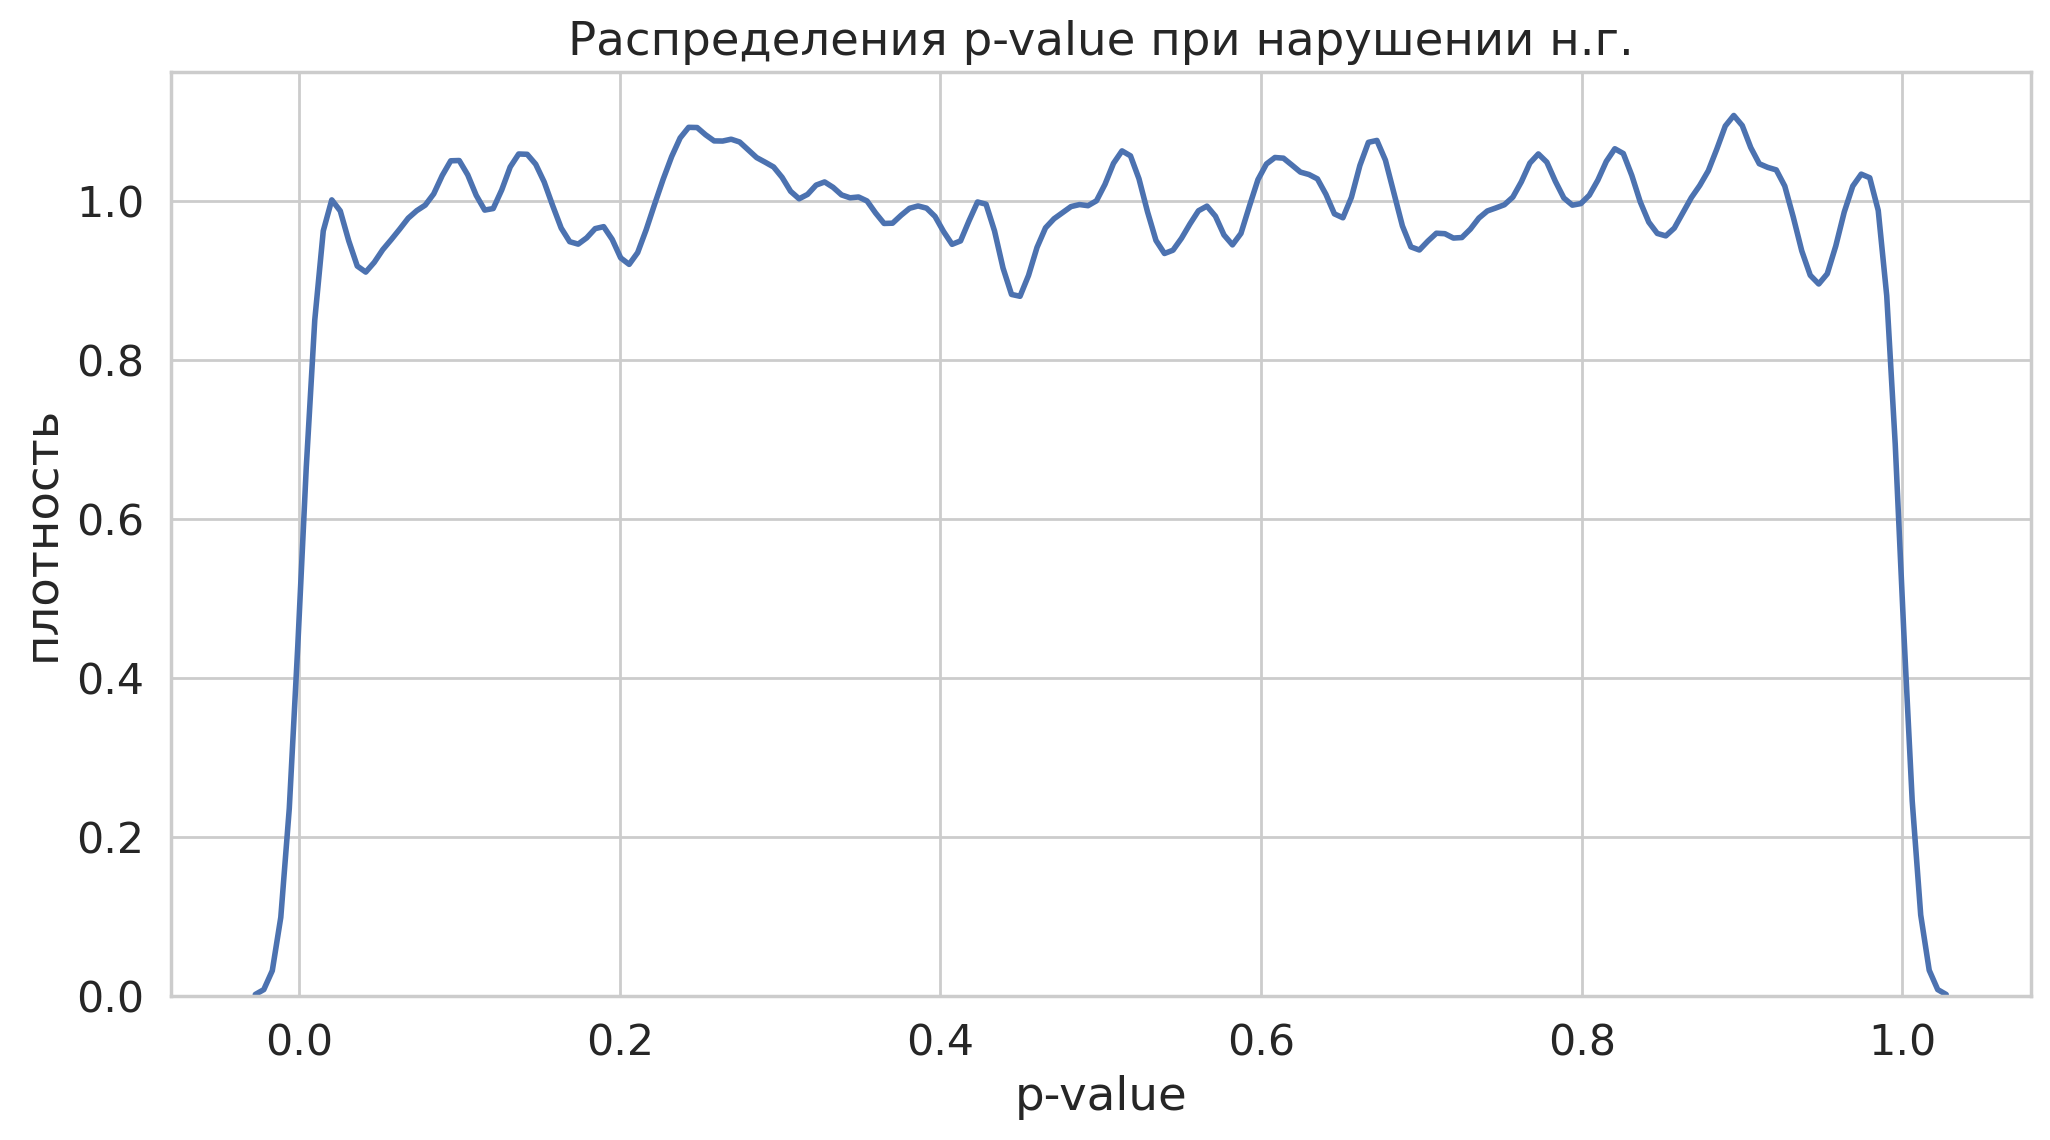

Ошибка первого рода - 0.048


In [46]:
subj_col  = np.repeat(np.arange(k), 3)
cond_col  = np.tile(np.array([0, 1, 2]), k)

make_df = lambda x: pd.DataFrame({"subj": subj_col, "cond": cond_col, "y": x.reshape(-1),})
get_p = lambda x: sts.anova.AnovaRM(make_df(x), depvar="y", subject="subj", within=["cond"]).fit().anova_table.loc["cond", "Pr > F"]

p_values_anovaRM = np.array([get_p(X[i]) for i in range(N)]) # Очень хочется поставить этой ячейке стикер блёвчика или банана


plt.figure(figsize=(12,6))
sns.kdeplot(p_values_anovaRM, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при нарушении н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

print("Ошибка первого рода -", np.mean(p_values_anovaRM < ALPHA)) 

Примените критерий Фридмана ([`scipy.stats.friedmanchisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html)) к сгенерированным данным и оцените его ошибку I рода.

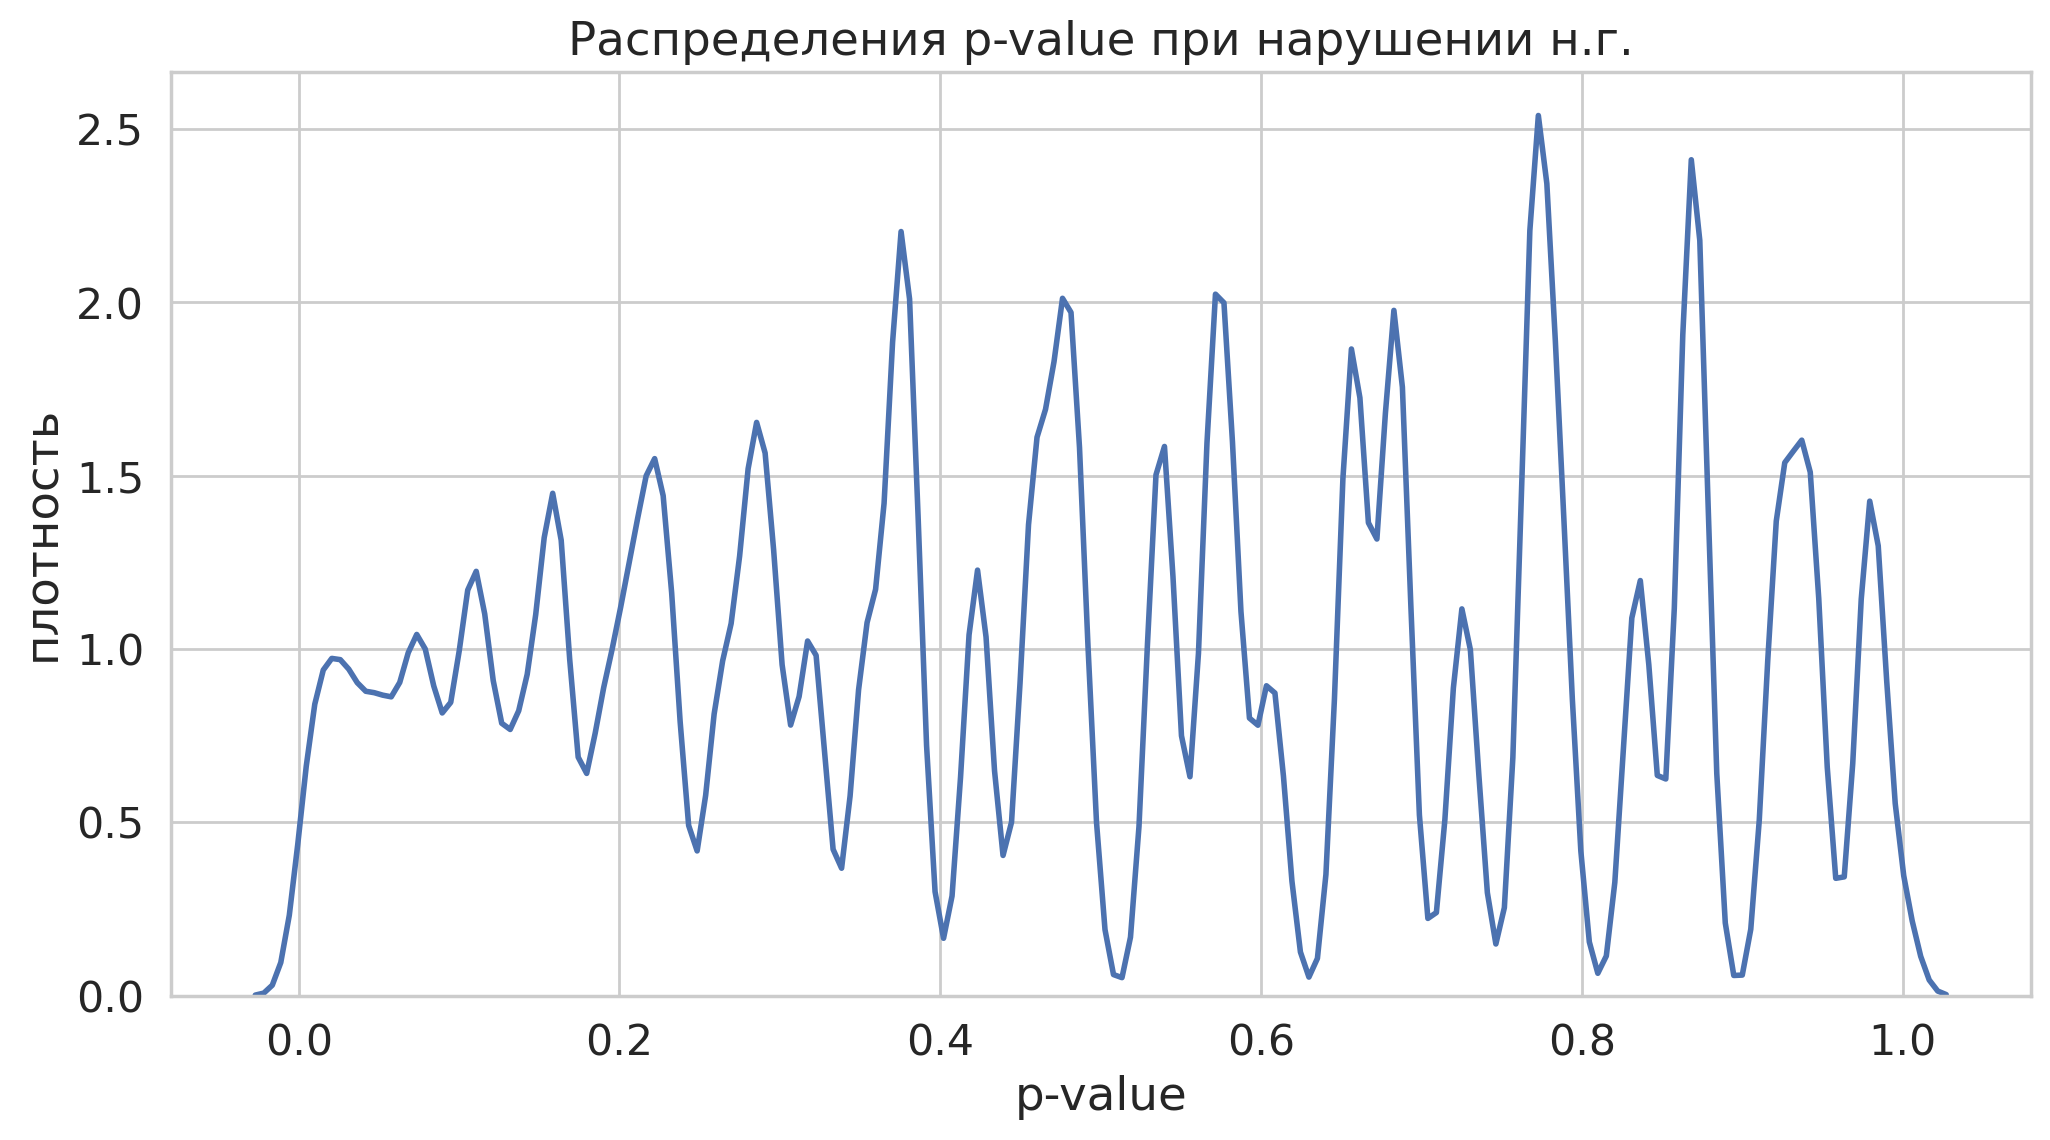

Ошибка первого рода - 0.0461


In [47]:
p_values_fridman = np.array([sps.friedmanchisquare(X[i, :, 0], X[i, :, 1], X[i, :, 2]).pvalue for i in range(N)])

plt.figure(figsize=(12,6))
sns.kdeplot(p_values_fridman, lw=2, bw_adjust=0.2)
plt.title(fr"Распределения p-value при нарушении н.г."); plt.xlabel("p-value"); plt.ylabel(r"плотность"); plt.grid(True)
plt.show()

print("Ошибка первого рода -", np.mean(p_values_fridman < ALPHA)) 

Вывод:

<font color="#ae69c9ff">

Посмотрели разные критерии, поговорили о том, когда корректно их применять. За кадром я побаловался с размерами выбоорок, при увеличении `k` распрелелние Фридмана явно стремится к равномерному, хотя при `k` $= 50$, получается какое-то некрасивое равномерное (очень уж неоднородные пики)

По заданию явно не просили погонять Фридмана на не нормальных распределениях; сделаю, если успею. ( Не повезло(( )

### 4. Бонусный пункт (+5 баллов). Двухфакторный ANOVA

Часто на отклик влияет не один, а сразу несколько факторов. Двухфакторный ANOVA позволяет оценить их эффекты по отдельности и совместно. Модель выглядит так:
$$
X_{ijk} = \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ijk}
$$
где:
*   $X_{ijk}$ — $k$-е наблюдение при $i$-м уровне фактора А и $j$-м уровне фактора Б.
*   $\mu$ — общее среднее.
*   $\alpha_i$ — главный эффект фактора А.
*   $\beta_j$ — главный эффект фактора Б.
*   $\gamma_{ij}$ — эффект взаимодействия факторов А и Б.
*   $\varepsilon_{ijk} \sim \mathcal{N}(0, \sigma^2)$ — случайная ошибка.

Эта модель позволяет проверить три гипотезы:

- об отсутствии главного эффекта фактора А ($H_{0,A}: \forall i: \alpha_i=0$)
- об отсутствии главного эффекта фактора Б ($H_{0,B}: \forall j: \beta_j=0$)
- и взаимодействия ($H_{0,AB}: \forall i,j: \gamma_{ij}=0$).

Суть оценки взаимодействия такая: вдруг ваши эффекты каким-то необычным образом накладываются друг на друга. Представьте что есть взаимозаменяющие друг друга лекарства, и вы сначала даёте больным одно лекарство (оно как то лечит), потом отдельно другое (оно тоже как то лечит), а потом оба вместе, от чего у них, к сожалению, происходит передоз (анлак)

Логика та же, что и в однофакторном ANOVA: общая сумма квадратов (SST) раскладывается на компоненты, каждая из которых относится к своему источнику изменчивости.
$$
SST = SSA + SSB + SSAB + SSE
$$
Здесь SSA, SSB, SSAB — суммы квадратов для факторов А, Б и их взаимодействия, а SSE — остаточная сумма квадратов (ошибка).

Для каждой гипотезы вычисляется своя F-статистика путем деления соответствующего среднего квадрата (MS) на средний квадрат ошибки (MSE):

1.  Для главного эффекта фактора А:
    $$ F_A = \frac{MSA}{MSE} = \frac{SSA / (a-1)}{SSE / (N-ab)} $$
    При верности $H_{0,A}$ эта статистика имеет распределение $F$ с $a-1$ и $N-ab$ степенями свободы, где $a$ — число уровней фактора А, $b$ — число уровней фактора Б, $N$ — общее число наблюдений.

2.  Для главного эффекта фактора Б:
    $$ F_B = \frac{MSB}{MSE} = \frac{SSB / (b-1)}{SSE / (N-ab)} $$
    При верности $H_{0,B}$ эта статистика имеет распределение $F$ с $b-1$ и $N-ab$ степенями свободы.

3.  Для эффекта взаимодействия:
    $$ F_{AB} = \frac{MSAB}{MSE} = \frac{SSAB / ((a-1)(b-1))}{SSE / (N-ab)} $$
    При верности $H_{0,AB}$ эта статистика имеет распределение $F$ с $(a-1)(b-1)$ и $N-ab$ степенями свободы.

А что если мы нарушаем условия?

-   Нарушение нормальности: Как и однофакторный ANOVA, двухфакторный достаточно робастен к этому нарушению при больших выборках. Существует критерий Шайрера-Рэя-Хэйра. Это, по сути, двухфакторный аналог критерия Краскела-Уоллиса, который выполняет ANOVA на ранжированных данных. Однако он редко используется и не реализован в `scipy`.

-   Нарушение гомоскедантичности: Если дисперсии в ячейках дизайна сильно различаются, это может серьезно исказить результаты. Специализированных аналогов "ANOVA Уэлча" для двухфакторного случая в стандартных библиотеках нет. В таких ситуациях используют более продвинутые методы, такие как робастный ANOVA или модели со взвешенными наименьшими квадратами, но это выходит за рамки нашей задачи.


Смоделируем эксперимент в дизайне 2x2 (по 30 наблюдений в каждой из 4 ячеек). Сначала сгенерируйте данные по модели, где нет никаких эффектов (все $\alpha_i, \beta_j, \gamma_{ij}$ равны нулю), например, из $\mathcal{N}(10, 2^2)$ (тоже много выборок, скажем, 10000)

In [48]:
N = 1000
k = 30

X = sps.norm(10, 2).rvs((N, 4, k))

Используя `statsmodels` (`from statsmodels.formula.api import ols` и `from statsmodels.stats.anova import anova_lm`), проведите двухфакторный ANOVA. Для каждого из трёх эффектов (A, B, A:B) оцените ошибку I рода на уровне $\alpha=0.05$.

In [49]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [50]:
A = np.repeat([0, 1], 2 * k)
B = np.tile(np.repeat([0, 1], k), 2)

def get_pvals_one_exp(x):
    y = x.reshape(-1)
    df = pd.DataFrame({"y": y, "A": A, "B": B})
    df["A"] = df["A"].astype("category")
    df["B"] = df["B"].astype("category")

    table = anova_lm(smf.ols("y ~ A * B", data=df).fit(), typ=2)
    return table.loc["A", "PR(>F)"], table.loc["B", "PR(>F)"], table.loc["A:B", "PR(>F)"]

# ну идентично, закидать всё это блёвчиками и бананами


p_values_anova_lm = np.array([get_pvals_one_exp(X[i]) for i in range(N)])

print("Ошибка первого рода для A -", np.mean(p_values_anova_lm[:, 0] < ALPHA))
print("Ошибка первого рода для B -", np.mean(p_values_anova_lm[:, 1] < ALPHA))
print("Ошибка первого рода для взаимодействия A и B -", np.mean(p_values_anova_lm[:, 2] < ALPHA))


Ошибка первого рода для A - 0.037
Ошибка первого рода для B - 0.054
Ошибка первого рода для взаимодействия A и B - 0.052


Теперь исследуем мощность для обнаружения эффекта взаимодействия. Смоделируйте ситуацию, где главных эффектов нет, но есть взаимодействие. Например:
-   Уровень A1, B1: $\mu = 10$
-   Уровень A1, B2: $\mu = 10 + \Delta$
-   Уровень A2, B1: $\mu = 10 + \Delta$
-   Уровень A2, B2: $\mu = 10$

Постройте график зависимости мощности (доли отвергнутых $H_0$ для эффекта взаимодействия A:B) от величины $\Delta$.

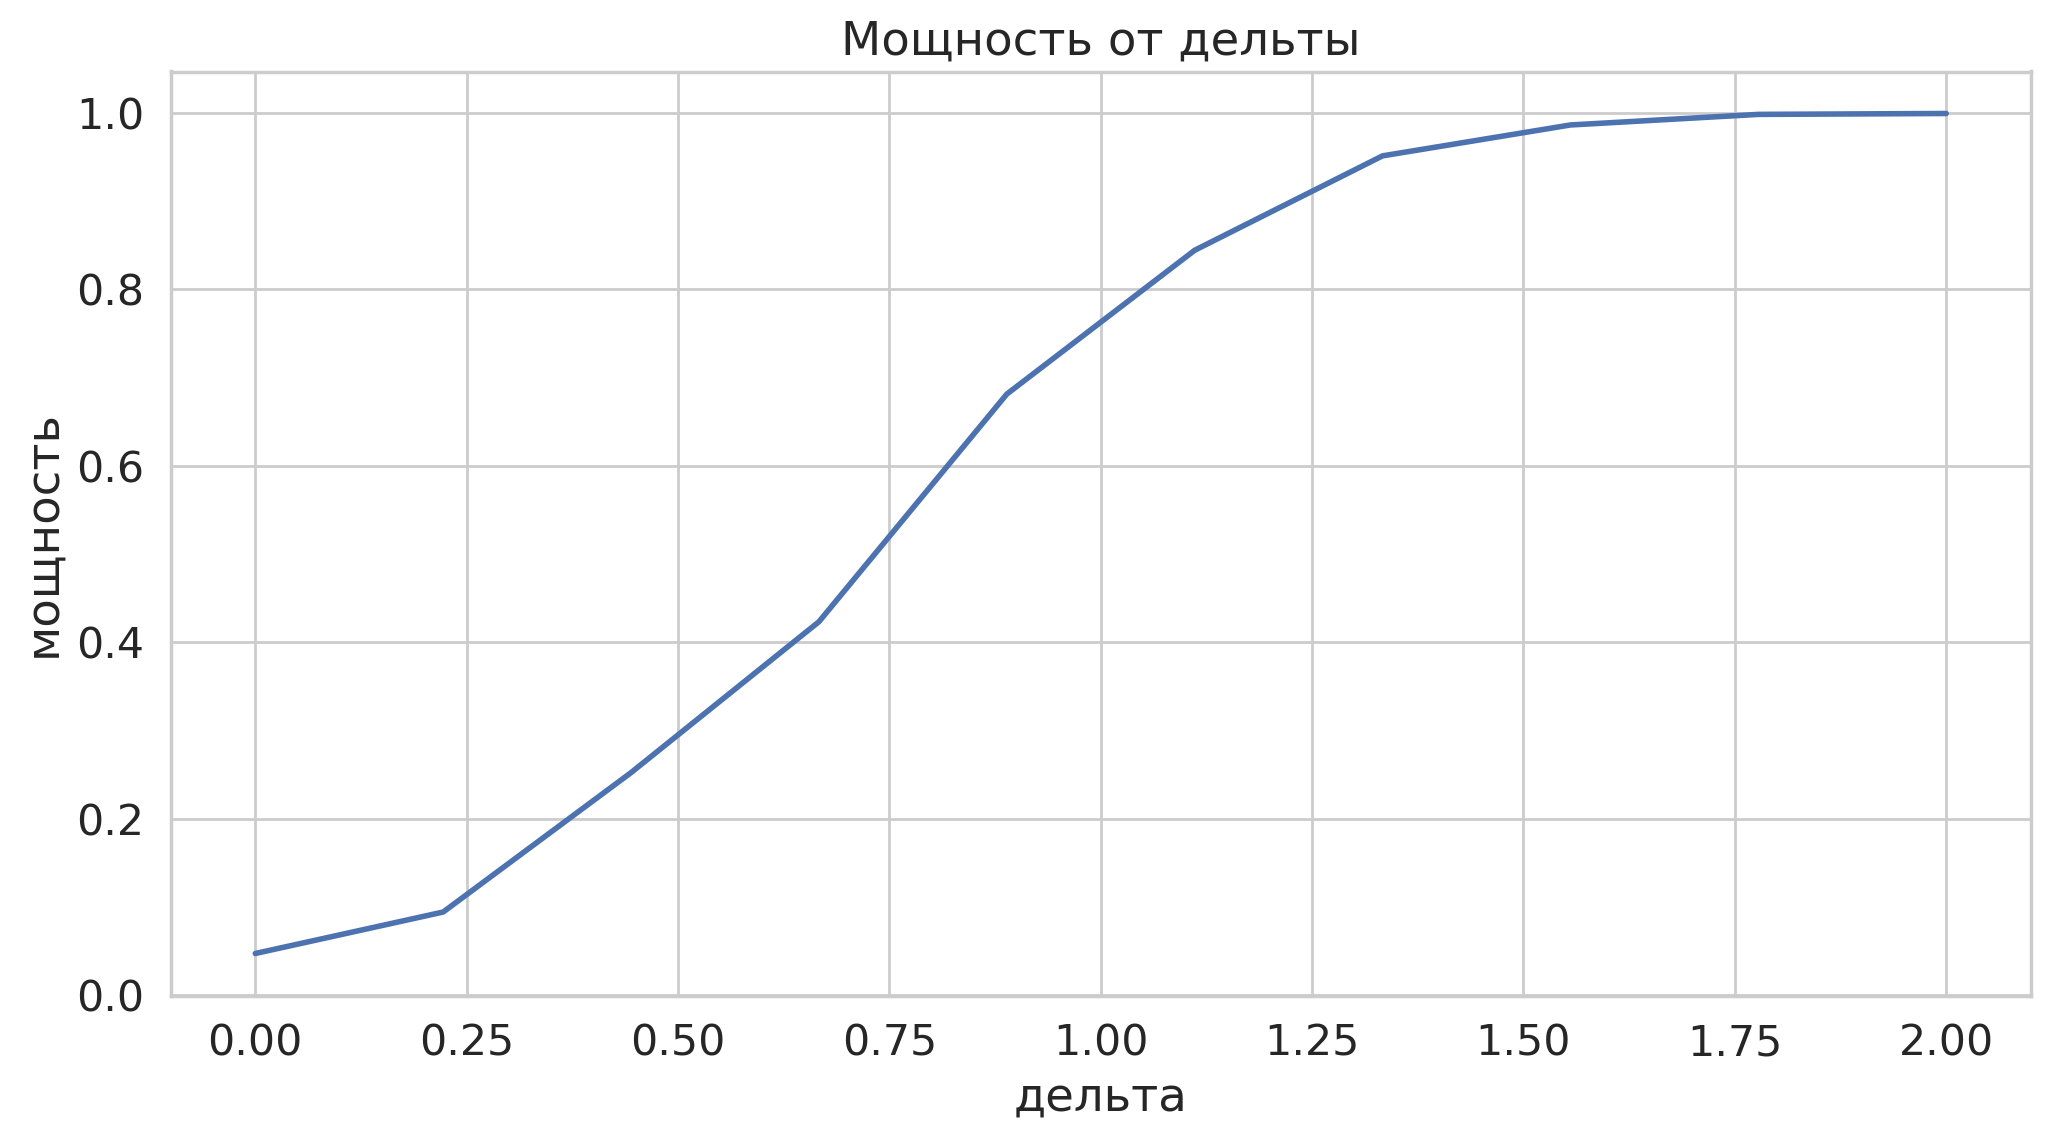

In [51]:
nums = []
deltas = np.linspace(0, 2, 10)
for delta in deltas:
    X = sps.norm(10, 2).rvs((N, 4, k)) + np.array([0, delta, delta, 0])[None, :, None]
    nums.append(np.mean(np.array([get_pvals_one_exp(X[i])[2] for i in range(N)]) < ALPHA))

plt.figure(figsize=(12,6))
plt.plot(deltas, nums, lw=2)
plt.title(fr"Мощность от дельты"); plt.xlabel("дельта"); plt.ylabel(r"мощность"); plt.grid(True)
plt.show()

Вывод:

<font color="#ae69c9ff">

Ощущение, что мне дали в руки космический корабль, очень крутая и сильная штука, жаль, что мы ан курсе не уделяем ей больше времени

Ошибки в первом пункте близки к $\alpha$, что есть хорошо. А кривая во втором пункте похожа на уровень значимости, что вроде как даже и согласуется с теорией

Ну и да, на 10к не успеваю, сделал только на 1000. Идейно ничего не должно сломаться

на этом задача про ANOVA подходит к концу, но даже так мы не охватили большую часть этой штуки

кому стало очень интересно, могут ещё самостоятельно изучить (часть из этого, например, будет на МСПС)

1. Post-Hoc Анализ

    ANOVA говорит, что есть различие между тремя и более группами. Какие конкретно группы отличаются друг от друга? Для этого есть Post-hoc тесты

2. ANCOVA

    Что если на ваш результат, помимо основного фактора, влияет какая-то побочная непрерывная переменная (например, возраст испытуемых или их исходный уровень знаний)? ANCOVA позволяет удалить или проконтролировать влияние этой переменной

3. Смешанный ANOVA и Факторный ANOVA > 2 факторов

    Что если у вас в исследовании есть и межгрупповые факторы (например, "лекарство" vs "плацебо"), и внутригрупповые (замеры "до", "во время" и "после" лечения)? Для этого есть Смешанный ANOVA, который является комбинацией обычного ANOVA и ANOVA для повторных измерений.

4. Линейные смешанные модели

    ANOVA для повторных измерений имеет строгие допущения и плохо справляется с пропущенными данными. Что делать, если структура данных еще сложнее (например, ученики в классах, классы в школах)? Для этого есть смешанные модели